In [2]:
import sparse
import subprocess
import shlex
import pandas as pd
import numpy as np

import glob
import os
import wget
import requests
import glob
import time
import dask
import h5py

from Bio import SeqIO
import pickle
import sys
sys.setrecursionlimit( 10 **9 )
from sklearn.cluster import *
from sklearn.metrics import roc_curve , precision_recall_curve , auc

import scipy
import copy
from numpy import linalg as LA
from matplotlib import pyplot as plt
import random
import h5py
import itertools
import dendropy
import os
import psutil
import seaborn as sns


overwrite = False
jk_iterations = 5
os.environ['MKL_ENABLE_INSTRUCTIONS'] = 'AVX2'

In [3]:
import torch
#create graphs on the fly to represent pairs of profiles
device = torch.device('cuda' )
#device = torch.device('cpu')
print(device)

cuda


In [4]:
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import ChebConv
from torch_geometric.nn import  to_hetero
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import HeteroData ,InMemoryDataset
import copy
import time
import pickle
import random

In [4]:
filedir = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/'

In [5]:

files = glob.glob( '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/apr_4_2022/mmsa_2022-04-04/2022-04-04_masked.fa_02022-06-14T07:53:44.200443small_test_coevmats.pkl')
print(files)

['/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/apr_4_2022/mmsa_2022-04-04/2022-04-04_masked.fa_02022-06-14T07:53:44.200443small_test_coevmats.pkl']


In [6]:
#treefile = '../validation_data/covid19/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.aln.EPIID.treefile'
#alnfile = '../validation_data/covid19/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.aln'
alnfile = filedir + 'datasets/covid_data/msa_0730/msa_0730.fasta'

treefile = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/feb_2021/GISAID-hCoV-19-phylogeny-2021-02-21/global.tree'
modeldir = filedir+'datasets/covid_data/structs/'

alnh5 = alnfile+'.h5'
#ts = '2021-08-08T11:16:34.358764'
#ts = '2021-08-08T14:37:59.736512'
#events = alnfile+'*'+ts+'*'
eventmats = files

In [7]:
with open(treefile) as treelines:
    print( next(treelines)[0:1000])

(EPI_ISL_406801:0,(EPI_ISL_413691:0.0,EPI_ISL_414663:0.0,EPI_ISL_414691:0.0,EPI_ISL_414690:0.0,EPI_ISL_414689:0.0,EPI_ISL_413729:0.0,EPI_ISL_413750:0.0,EPI_ISL_413746:0.0,EPI_ISL_413748:0.0,EPI_ISL_428470:0.0,EPI_ISL_428471:0.0,EPI_ISL_428476:0.0,EPI_ISL_429854:0.0,EPI_ISL_429091:0.0,EPI_ISL_429090:0.0,EPI_ISL_429093:0.0,EPI_ISL_429092:0.0,EPI_ISL_429075:0.0,EPI_ISL_429082:0.0,EPI_ISL_429084:0.0,EPI_ISL_429083:0.0,EPI_ISL_407893:0.0,EPI_ISL_416326:0.0,EPI_ISL_416352:0.0,EPI_ISL_407976:0.0,EPI_ISL_411926:0.0,EPI_ISL_421246:0.0,EPI_ISL_421244:0.0,EPI_ISL_421242:0.0,EPI_ISL_421240:0.0,EPI_ISL_421237:0.0,EPI_ISL_421249:0.0,EPI_ISL_421247:0.0,EPI_ISL_412979:0.0,EPI_ISL_408480:0.0,EPI_ISL_449481:0.0,EPI_ISL_449484:0.0,EPI_ISL_451384:0.0,EPI_ISL_457687:0.0,EPI_ISL_457688:0.0,EPI_ISL_457689:0.0,EPI_ISL_457690:0.0,EPI_ISL_457692:0.0,EPI_ISL_457693:0.0,EPI_ISL_457695:0.0,EPI_ISL_457696:0.0,(EPI_ISL_463895:5e-09,((EPI_ISL_537438:0.000134997,(((EPI_ISL_412982:0.00010032,(((EPI_ISL_428674:3.3427e-0

In [8]:
tree = dendropy.Tree.get( path=treefile, schema='newick' )

In [9]:
#setup the internal nodes for the fitch algo
for i,l in enumerate(tree.nodes()):
    l.event = {}
    l.scores = {}
    l.symbols = None
    l.char= None
    l.matrow = i
    

In [10]:
import networkx as nx
import colour
#quick and dirty check of trees

def tree_circle(node, start , sliver  ):
    if start == True :
        global count
        count = 0
    for i,child in enumerate(node.child_nodes()):
        if child.is_leaf() == True:
            child.radians = count*sliver
            count+=1
        if child.radians is None and child.is_leaf() == False :
            tree_circle( child , start = False , sliver = sliver  )
    radians = np.mean([ child.radians if child.radians else 0 for child in node.child_nodes() ])
    if node.radians is None:
        node.radians = radians

def phylograph(treein,labels , title = None):
    N = len(treein.nodes())
    tree = copy.deepcopy(treein)
    pdm = tree.phylogenetic_distance_matrix()
    sliver = 2*np.pi / len(tree.leaf_nodes())
    
    root = tree.seed_node
    radii = [ n.distance_from_root() for n in tree.nodes()]
    for n in tree.nodes():
        n.radians = None
    tree_circle(tree.seed_node, start=True , sliver = sliver)
    thetas = [n.radians for n in tree.nodes() ]
    pos = { i: [ np.sin(thetas[i])*radii[i] , np.cos(thetas[i])*radii[i]] for i in range(len(thetas)) }
    index = np.vstack([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
    connectmat = np.zeros(( N ,  N ) )
    connectmat[index[:,0],index[:,1]] = 1 
    connectmat += connectmat.T
    G = nx.from_numpy_array(connectmat)
    red = colour.Color("red")
    blue = colour.Color("blue")
    crange = dict( zip ( list(set(labels)),  [ c.hex_l for c in list(red.range_to(blue, len(set(labels)) ) ) ] ) )
    colors = [crange[n] for n in labels ]
    #color according to downstream node
    edge_colors= [crange[labels[v]] for u,v in G.edges() ]
    #node size inversly proportional to number in graph
    plt.figure(figsize= (20,20) )
    if title:
        plt.title(title)
    nx.draw_networkx(G, pos = pos,  node_color = colors , node_size = 5, width = .5 , edge_color = edge_colors , with_labels=False)
    plt.show()

In [11]:
def ROC_curve(y_data, label = None):
    plt.figure(figsize=(10,10))
    plt.plot([0, 1], [0, 1], 'k--')
    for l in y_data:
        print(l)
        y_pred_grd = y_data[l]['Ytrue']
        y_test = y_data[l]['Ypred']
        fpr, tpr, _ = roc_curve(   y_pred_grd ,y_test)
        plt.plot(fpr, tpr, label=l + 'auc'+ str(auc(fpr, tpr) ))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    if label:
        plt.savefig( str(label) +'_ROC.svg' )
    plt.show()
    
    
    plt.figure(figsize=(10,10))
    for l in y_data:
        y_pred_grd = y_data[l]['Ytrue']
        y_test = y_data[l]['Ypred']
        precision, recall, thresholds = precision_recall_curve( y_pred_grd, y_test)
        plt.plot( recall, precision , label= l )
        plt.ylabel('Precision')
        plt.xlabel('Recall')
    
    plt.title('PR curve')
    plt.legend(loc='best')
    if label:
        plt.savefig(str( label )+'_PR.svg' )
    plt.show()
    
def ROC_curve_single(y_test, y_pred_grd):
    fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

    plt.plot([0, 1], [0, 1], 'k--')

    fpr, tpr, _ = roc_curve(y_test, y_pred_grd)
    plt.plot(fpr, tpr, label='single')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    precision, recall, thresholds = precision_recall_curve(  y_test , y_pred_grd)
    plt.plot(precision, recall , label='single')
    plt.xlabel('Precision')
    plt.ylabel('Recall')

    plt.title('PR curve')
    plt.legend(loc='best')
    plt.show()


In [12]:
print( eventmats )

['/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/apr_4_2022/mmsa_2022-04-04/2022-04-04_masked.fa_02022-06-14T07:53:44.200443small_test_coevmats.pkl']


In [13]:

if os.path.exists( alnfile + '_IDs.pkl'):
    with open( alnfile + '_IDs.pkl' , 'rb') as idxin:
        IDindex = pickle.loads(idxin.read())
    IDs = dict(zip( IDindex.values() , IDindex.keys() ) )
else:
    
    msa = SeqIO.parse(alnfile , format = 'fasta')
    def clipID(ID):
        return ''.join( [ s +'|' for s in str(ID).split('|')[:-1] ])[:-1].replace('_',' ') 
    IDs = {i:rec.id for i,rec in enumerate(msa)}
    IDindex = dict(zip( IDs.values() , IDs.keys() ) )
    print( [(t,IDindex[t]) for t in list(IDindex.keys())[0:10]] )
    with open( alnfile + '_IDs.pkl' , 'wb') as idxout:
        idxout.write(pickle.dumps(IDindex))

In [14]:
print(len(IDindex))

2212775


In [15]:
#https://www.ebi.ac.uk/thornton-srv/databases/cgi-bin/pdbsum/GetPage.pl?pdbcode=n/a&template=covid19.html

models = '7DZW, 6vxx,6zxn,5x58,6cs0,6sc1,6nb6, 2jw8, 2xab, 4aud1, 1yo4, 2acf, 2wct, 3vc8, 2gt7, 3ee7, 2g9t, 3ee7, 2g9t, 6jyt, 1ysy, 6nur, 2g9t, 5c8u, 2g9t, 2xyq, 4mm3, 6cs2, 6acg, 6acj, 6ack, 2dd8, 2ghw, 6nb6, 6nb7'
models += ',7tv0, 8ctk,  7vbf , 7k7p , 7k7p , 7msw , 5sp2 , 3vcb, 8d4l , 7lhq, 7cyq,  7kri, 7n0d'
models += ',7dte,7cxm, 7egq, 5sbf, 7l6r, 7kjr, 7ci3, 7jx6, 7kdt '

#models = '6vxx,6zxn'
models = models.split(',')

from Bio.PDB import *
dl_url = 'http://files.rcsb.org/download/'
dl_url_err = 'http://files.rcsb.org/download/'

structs = {}
already = glob.glob( modeldir+'/*.pdb' )
print(already)
#pull complexes
for m in models:
    structfile = modeldir+m.upper().strip()+'.pdb'
    if structfile not in already:
        print(m)
        time.sleep(1)
        try:
            wget.download(url = dl_url + m.strip() +'.pdb' , out =structfile)
            structs[m] = structfile
        except:
            try:
                wget.download(url = dl_url + m.strip() +'.pdb' , out =structfile)
                structs[m] = structfile
            except:
                print('err', m )
    else:
        structs[m.strip()] = structfile


['/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6NB7.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/3EE7.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/5SBF.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2ACF.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/7TV0.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2JW8.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/1YO4.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/7KDT.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6CS0.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/struct_chains.fasta.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6JYT.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/7LHQ.pdb', '/work/FAC/FBM/DBC/cdess

In [16]:
modelfiles = modeldir + '*.pdb'
modelfiles = glob.glob( modelfiles )
print(modelfiles)

['/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6NB7.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/3EE7.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/5SBF.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2ACF.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/7TV0.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2JW8.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/1YO4.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/7KDT.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6CS0.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/struct_chains.fasta.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6JYT.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/7LHQ.pdb', '/work/FAC/FBM/DBC/cdess

In [17]:
from Bio.PDB import MMCIFParser, PDBParser , PDBIO
from Bio.PDB.mmcifio import MMCIFIO
parser = PDBParser()
import warnings
from Bio import SeqUtils

###compile all pdbs to fasta 
converter = SeqUtils.IUPACData.protein_letters_3to1
converter = { res.upper():converter[res] for res in converter}
chain_sequences={}
for model in modelfiles:
    print(model)
    with warnings.catch_warnings():
        try:
            m = model.split('/')[-1].replace('pdb' , '') 
            warnings.simplefilter("ignore")
            structure = parser.get_structure(m, model)
            io=PDBIO()
            io.set_structure(structure)
            chain_sequences[model]= { c.id : ''.join(  [ converter[ r.get_resname()] for r in c.get_residues() if 'CA' in r ] ) for c in structure.get_chains() }
            chain_sequences[model]={ c: chain_sequences[model][c] for c in chain_sequences[model] if len(chain_sequences[model][c])> 0 }
        except:
            print('err', model)

/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6NB7.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/3EE7.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/5SBF.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2ACF.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/7TV0.pdb
err /work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/7TV0.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2JW8.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/1YO4.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/7KDT.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6CS0.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/struct_chains.fasta.pdb
err /work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/struct_chains.fasta.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmo

In [18]:
with open( modeldir + 'struct_chains.fasta', 'w') as fastout:
    for model in chain_sequences:
        for c in chain_sequences[model]:
            fastout.write( '> '+model+ ':'+c + '\n' + chain_sequences[model][c] + '\n' )

In [19]:

from dask.distributed import fire_and_forget
from dask.distributed import Client, Variable , Queue , Lock ,LocalCluster
from dask_jobqueue import SLURMCluster
from dask.distributed import  utils_perf
import dask
import dask.bag as db
import dask.array as da
import dask.dataframe as dd
from dask.delayed import delayed
from dask import delayed, compute

distributed_computation = False

print('flashing up a dask cluster')
if distributed_computation == True:
    
    NCORE = 4
    njobs = 20
    print('deploying cluster')
    cluster = SLURMCluster(
        walltime='1:00:00',
        n_workers = NCORE,
        cores=NCORE,
        processes = NCORE,
        interface='ib0',
        memory="10GB",
        env_extra=[
        'source /scratch/dmoi/miniconda/etc/profile.d/conda.sh',
        'conda activate ML'
        ],
        scheduler_options={'interface': 'ens3f0' }
    )
    print(cluster.job_script())
    cluster.adapt(minimum=10, maximum=100)
    time.sleep(5)

    print(cluster)
    print(cluster.dashboard_link)
    client = Client(cluster , timeout='450s' , set_as_default=True )
else:
    if __name__ == '__main__':
        NCORE = 10
        njobs = 1
        print('testing')
        cluster = LocalCluster(n_workers = NCORE )    
        print(cluster.dashboard_link)
        client = Client(cluster)
print('done')

/users/dmoi/.local/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


flashing up a dask cluster
testing
http://127.0.0.1:8787/status
done


In [20]:
nucleotide_mutation = None
AA_mutation = None
for mat in eventmats:
    with open( mat , 'rb') as pklin:
        mats = pickle.loads(pklin.read())
        print(mats)
        if AA_mutation is None:
            nucleotide_mutation = mats[1]
            AA_mutation = mats[0]
        else:
            nucleotide_mutation += mats[1]
            AA_mutation += mats[0]
print(nucleotide_mutation)
print(AA_mutation)

(<COO: shape=(741326, 29891, 380), dtype=float64, nnz=93228, fill_value=0.0>, <COO: shape=(741326, 29891, 12), dtype=float64, nnz=156073, fill_value=0.0>)
<COO: shape=(741326, 29891, 12), dtype=float64, nnz=156073, fill_value=0.0>
<COO: shape=(741326, 29891, 380), dtype=float64, nnz=93228, fill_value=0.0>


In [21]:
AAmat = AA_mutation.sum(axis = 2).to_scipy_sparse()

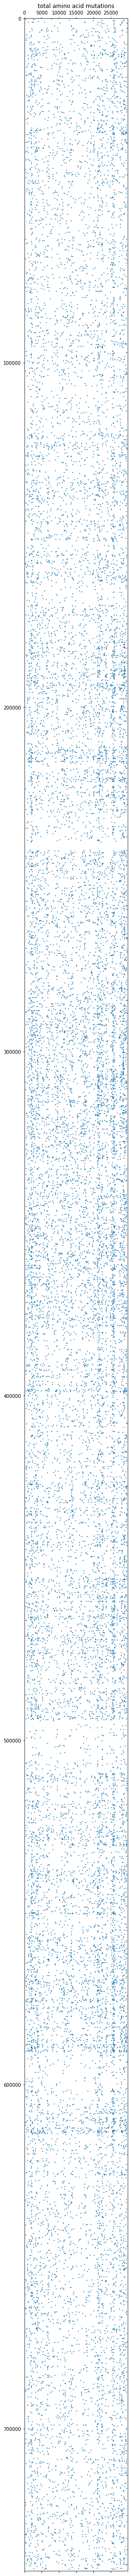

In [22]:
plt.figure(figsize=(10,100))
plt.spy(AAmat, markersize= .5)
plt.title('total amino acid mutations')
plt.show()

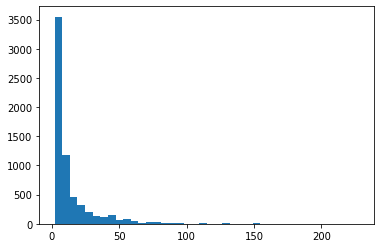

In [23]:
colsum = AAmat.sum(axis = 0)
colsum = colsum[colsum>1]
#colsum = colsum[colsum<100]

plt.hist(colsum.flat , bins = 40)
plt.show()

In [24]:
print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)


2316.32421875


In [25]:
allowed_symbols = [ b'A', b'C', b'G' , b'T' ]
allowed_transitions = [ c1+c2 for c1 in allowed_symbols for c2 in allowed_symbols  if c1!= c2]
print('allowed transitions',allowed_transitions)

transition_dict = {  c : i  for i,c in enumerate( allowed_transitions )  }
rev_transition_dict= dict( zip(transition_dict.values(), transition_dict.keys()))
allowed_symbols = set(allowed_symbols)

print('transition dict', transition_dict)
ProteinAlphabet = [ 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y' ]
allowed_AA_transitions = [ c1+c2 for c1 in ProteinAlphabet for c2 in ProteinAlphabet  if c1!= c2]
transitiondict_AA = {  c : i  for i,c in enumerate( allowed_AA_transitions )  }
rev_transitiondict_AA = dict( zip(transitiondict_AA.values(), transitiondict_AA.keys()))


allowed transitions [b'AC', b'AG', b'AT', b'CA', b'CG', b'CT', b'GA', b'GC', b'GT', b'TA', b'TC', b'TG']
transition dict {b'AC': 0, b'AG': 1, b'AT': 2, b'CA': 3, b'CG': 4, b'CT': 5, b'GA': 6, b'GC': 7, b'GT': 8, b'TA': 9, b'TC': 10, b'TG': 11}


741326
nodes


/users/dmoi/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


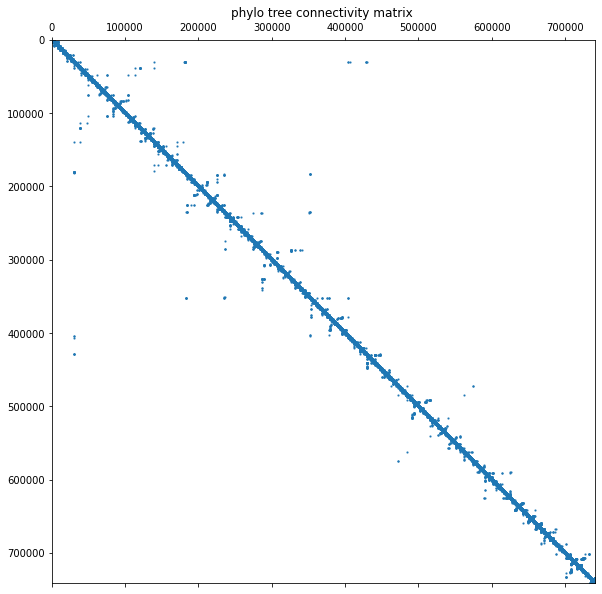

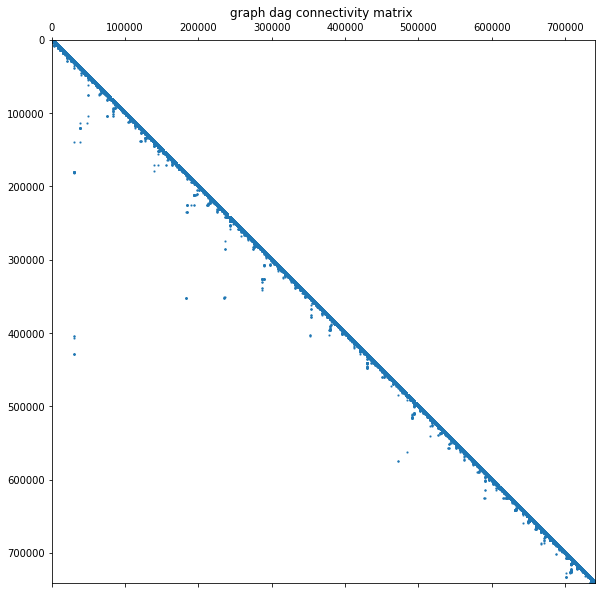

In [26]:
for i,n in enumerate(tree.nodes()):
    n.matrow = i
    n.symbols = None
    n.scores = None
    n.event = None
    n.char = None

matsize = len(tree.nodes())
print(matsize)
print('nodes')
#blur w connectivity mat
blurfactor =  .25
connectmat = scipy.sparse.csc_matrix((len(tree.nodes()), len(tree.nodes() ) ) )
index = np.array([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
lengths = np.array([ c.edge_length for n in tree.nodes() for c in n.child_nodes()])
total_len = np.sum(lengths)
#fill diagonal
#index = np.vstack( [index , np.array([ [n.matrow, n.matrow ] for n in tree.nodes() ]) ] )

connectmat[index[:,0],index[:,1]] = 1
connectmat[index[:,1],index[:,0]] = 1


graphmat = scipy.sparse.csc_matrix((len(tree.nodes()), len(tree.nodes() ) ) )

graphmat[index[:,1],index[:,0]] = 1


#connectmat = connectmat.todense()
diag = [ i for i in range(connectmat.shape[0])]
connectmat[diag,diag] = 1
#connectmat = connectmat.todense()
#connectmat = scipy.sparse.csc_matrix(connectmat)
#np.fill_diagonal(connectmat , 1)
connectmat = scipy.sparse.coo_matrix(connectmat)
graphmat = scipy.sparse.coo_matrix(graphmat)

plt.figure( figsize=(10,10))
plt.title( 'phylo tree connectivity matrix ' )
plt.spy(connectmat, markersize= 1)
plt.show()


plt.figure( figsize=(10,10))
plt.title( 'graph dag connectivity matrix ' )
plt.spy(graphmat, markersize= 1)
plt.show()

In [27]:
print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)


2585.1484375


In [28]:
#####define the aln row and structure here, for dengue they should all be the same
selected_strain = list(IDindex.keys())[100]
import dask.array as da
with h5py.File(alnh5, 'r') as hf:
    align_array = hf['MSA2array']
    print(IDindex[selected_strain])
    print(selected_strain)
    #filter to columns without gaps
    non_gap = np.where( align_array[: , IDindex[selected_strain]] != b'-')[0]
    print(non_gap)
    print(non_gap.shape)
    sequence = align_array[ non_gap , IDindex[selected_strain]]
    print(np.unique(sequence))

100
EPI ISL 2874801
[  162   163   164 ... 40398 40399 40400]
(29809,)
[b'A' b'C' b'G' b'K' b'N' b'T']


In [29]:
#find the amino acid chains in the structs
import subprocess
import shlex

with open( alnfile + 'refgeno.fasta' , 'w' ) as fastout:
    fastout.write('>'+selected_strain + '\n')
    fastout.write( ''.join( c.decode() for c in list(sequence) ) + '\n' )
qfile =  alnfile + 'refgeno.fasta'

In [30]:
blastpath = filedir + 'software/ncbi-blast-2.11.0+-src/c++/ReleaseMT/bin/'
print(modeldir + 'covid_structs.fasta')
def runblastx( qseq , blastpath = blastpath , outannot = alnfile+'struct_blastout.txt' , db = modeldir + 'struct_chains.fasta' , outfmt = None ):
    if outfmt is None:
        outfmt = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ]
        outfmt =  ' "10 ' + ''.join([fmt+ ' ' for fmt in outfmt]) + ' " '
        print(outfmt)
    args = blastpath+'blastx -query '+ qfile + ' -db '+db+' -outfmt' + outfmt + ' -out ' + outannot  
    print(args)
    p = subprocess.run( shlex.split(args) )
    return p , outannot

p,annot = runblastx(qfile)
print(annot)

/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/covid_structs.fasta
 "10 qseqid sseqid qlen slen qstart qend qframe evalue  " 
/work/FAC/FBM/DBC/cdessim2/default/dmoi/software/ncbi-blast-2.11.0+-src/c++/ReleaseMT/bin/blastx -query /work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/msa_0730/msa_0730.fastarefgeno.fasta -db /work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/struct_chains.fasta -outfmt "10 qseqid sseqid qlen slen qstart qend qframe evalue  "  -out /work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/msa_0730/msa_0730.fastastruct_blastout.txt
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/msa_0730/msa_0730.fastastruct_blastout.txt


In [31]:
annotation = pd.read_csv(  annot , header = None )
annotation.columns = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ] 
annotation = annotation[ annotation['evalue'] < 10**-3 ]

annotation['struct'] = annotation.sseqid.map( lambda x : x.split(':')[0].split('/')[-1].replace('.pdb','') )
annotation['chain'] = annotation.sseqid.map( lambda x : x.split(':')[1] )
annotation.to_csv( alnfile +'struct_annotation.csv'  )
print(annotation)
#make annotation for dengue orfs
#find equivalent structures in multimers

   qseqid                                             sseqid   qlen  slen  \
0     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
1     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
2     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
3     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1060   
4     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1054   
..    ...                                                ...    ...   ...   
88    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    87   
89    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    85   
90    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    85   
91    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    81   
92    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    70   

    qstart   qend  qframe        evalue struct chain  
0    21604  24966   

In [32]:
chainlen = dict( zip ( annotation.struct + annotation.chain , annotation.slen ))

In [33]:
filter_annot = False
if filter_annot == True:
    annotation = annotation[annotation.struct == '7DZW']

In [34]:
print(annotation)

   qseqid                                             sseqid   qlen  slen  \
0     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
1     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
2     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
3     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1060   
4     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1054   
..    ...                                                ...    ...   ...   
88    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    87   
89    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    85   
90    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    85   
91    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    81   
92    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    70   

    qstart   qend  qframe        evalue struct chain  
0    21604  24966   

In [35]:
#grab AA chain residues
import itertools
import warnings
distmats = {}
overwrite_connect = True


@dask.delayed()
def retmat_single(totalatoms, chain, slen= None):
    ret = np.array( [[ a1['CA'] - a2['CA']  for i,a1 in enumerate(totalatoms[chain])  ] for j,a2 in enumerate(totalatoms[chain]) ] )
    if slen:
        ret = ret[:slen]
        ret = ret[:,:slen]
    return ret
    
@dask.delayed()
def retmat_double(totalatoms, chain1, chain2 , slen1= None , slen2 = None):
    ret = np.array( [[ a1['CA'] - a2['CA'] for i,a1 in enumerate(totalatoms[chain1])] for j,a2 in enumerate(totalatoms[chain2]) ] )
    if slen1:
        ret = ret[:slen1]
    if slen2:
        ret = ret[:,:slen2]
    return ret

@dask.delayed()
def addT(arr):
    arr += arr.T

if overwrite_connect == True:
    totalatoms = {}
    for i,model in enumerate(annotation.sseqid.unique()):
        with warnings.catch_warnings():
            m = model.split('/')[-1].replace('.pdb' , '').split(':')[0]
            print(m)
            warnings.simplefilter("ignore")
            structure = parser.get_structure(m, model.split(':')[0])
            io=PDBIO()
            io.set_structure(structure)
            totalatoms.update( { c.id : [ r for r in c.get_residues() if 'CA'  in r ] for c in structure.get_chains() } )
        for chain in totalatoms:
            print(structure, chain)
            if model not in distmats:
                distmats[m]= {}
                #if m+chain in chainlen:
                #    l1 = chainlen[m+chain]    
            l1 = None
            distmats[m][chain] = retmat_single( totalatoms, chain , l1 )
                #get interchain dists
        combocount = 0
        for chain1,chain2 in itertools.combinations(totalatoms,2):
            if combocount < 2:
                l1 = None
                #if m+chain1 in chainlen:
                #    l1 = chainlen[m+chain1]
                l2 = None
                #if m+chain2 in chainlen:
                #    l2 = chainlen[m+chain2]
            else:
                break
            combocount+=1
            distmats[m][(chain1,chain2)] = retmat_double(totalatoms, chain1, chain2  ,l1 , l2)    
            #compute vals
            #    print( ' err ', m )
        if m in distmats:
            distmats[m] = dict( zip ( distmats[m].keys() , dask.compute( * list(distmats[m].values() ))))
            #distmats[m] = dict( zip ( distmats[m].keys() , dask.compute( * [dropna(a) for a in list(distmats[m].values() )] ) ) ) 


7DZW
<Structure id=7DZW> A
<Structure id=7DZW> B
<Structure id=7DZW> C
7DZW
<Structure id=7DZW> A
<Structure id=7DZW> B
<Structure id=7DZW> C
7DZW
<Structure id=7DZW> A
<Structure id=7DZW> B
<Structure id=7DZW> C
6ZXN
<Structure id=6ZXN> A
<Structure id=6ZXN> B
<Structure id=6ZXN> C
<Structure id=6ZXN> D
<Structure id=6ZXN> E
<Structure id=6ZXN> F
<Structure id=6ZXN> G
<Structure id=6ZXN> H
<Structure id=6ZXN> I
<Structure id=6ZXN> J
<Structure id=6ZXN> K
<Structure id=6ZXN> L
<Structure id=6ZXN> M
<Structure id=6ZXN> N
<Structure id=6ZXN> O
<Structure id=6ZXN> P
<Structure id=6ZXN> Q
<Structure id=6ZXN> R
6ZXN
<Structure id=6ZXN> A
<Structure id=6ZXN> B
<Structure id=6ZXN> C
<Structure id=6ZXN> D
<Structure id=6ZXN> E
<Structure id=6ZXN> F
<Structure id=6ZXN> G
<Structure id=6ZXN> H
<Structure id=6ZXN> I
<Structure id=6ZXN> J
<Structure id=6ZXN> K
<Structure id=6ZXN> L
<Structure id=6ZXN> M
<Structure id=6ZXN> N
<Structure id=6ZXN> O
<Structure id=6ZXN> P
<Structure id=6ZXN> Q
<Struct

2022-07-15 14:22:19,021 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-07-15 14:22:19,543 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


5X58
<Structure id=5X58> A
<Structure id=5X58> B
<Structure id=5X58> C
<Structure id=5X58> D
<Structure id=5X58> E
<Structure id=5X58> F
<Structure id=5X58> G
<Structure id=5X58> H
<Structure id=5X58> I
<Structure id=5X58> J
<Structure id=5X58> K
<Structure id=5X58> L
<Structure id=5X58> M
<Structure id=5X58> N
<Structure id=5X58> O
<Structure id=5X58> P
<Structure id=5X58> Q
<Structure id=5X58> R
<Structure id=5X58> S
<Structure id=5X58> T
<Structure id=5X58> U
<Structure id=5X58> V
<Structure id=5X58> W
<Structure id=5X58> X
<Structure id=5X58> Y
<Structure id=5X58> Z
<Structure id=5X58> a
<Structure id=5X58> b
<Structure id=5X58> c
<Structure id=5X58> d
<Structure id=5X58> e
<Structure id=5X58> f
<Structure id=5X58> g
<Structure id=5X58> h
<Structure id=5X58> i
<Structure id=5X58> j
<Structure id=5X58> k
<Structure id=5X58> l
<Structure id=5X58> m
<Structure id=5X58> n
<Structure id=5X58> o
<Structure id=5X58> p
<Structure id=5X58> q
<Structure id=5X58> r
<Structure id=5X58> s
<Stru

2022-07-15 14:23:14,376 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-07-15 14:23:14,793 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-07-15 14:23:15,192 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-07-15 14:23:15,632 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


6ACJ
<Structure id=6ACJ> A
<Structure id=6ACJ> B
<Structure id=6ACJ> C
<Structure id=6ACJ> D
<Structure id=6ACJ> E
<Structure id=6ACJ> F
<Structure id=6ACJ> G
<Structure id=6ACJ> H
<Structure id=6ACJ> I
<Structure id=6ACJ> J
<Structure id=6ACJ> K
<Structure id=6ACJ> L
<Structure id=6ACJ> M
<Structure id=6ACJ> N
<Structure id=6ACJ> O
<Structure id=6ACJ> P
<Structure id=6ACJ> Q
<Structure id=6ACJ> R
<Structure id=6ACJ> S
<Structure id=6ACJ> T
<Structure id=6ACJ> U
<Structure id=6ACJ> V
<Structure id=6ACJ> W
<Structure id=6ACJ> X
<Structure id=6ACJ> Y
<Structure id=6ACJ> Z
<Structure id=6ACJ> a
<Structure id=6ACJ> b
<Structure id=6ACJ> c
<Structure id=6ACJ> d
<Structure id=6ACJ> e
<Structure id=6ACJ> f
<Structure id=6ACJ> g
<Structure id=6ACJ> h
<Structure id=6ACJ> i
<Structure id=6ACJ> j
<Structure id=6ACJ> k
<Structure id=6ACJ> l
<Structure id=6ACJ> m
<Structure id=6ACJ> n
<Structure id=6ACJ> o
<Structure id=6ACJ> p
<Structure id=6ACJ> q
<Structure id=6ACJ> r
<Structure id=6ACJ> s
<Stru

2022-07-15 14:23:48,386 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-07-15 14:23:48,569 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-07-15 14:23:48,794 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-07-15 14:23:48,991 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-07-15 14:23:49,355 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


6NB6
<Structure id=6NB6> A
<Structure id=6NB6> B
<Structure id=6NB6> C
<Structure id=6NB6> D
<Structure id=6NB6> E
<Structure id=6NB6> F
<Structure id=6NB6> G
<Structure id=6NB6> H
<Structure id=6NB6> I
<Structure id=6NB6> J
<Structure id=6NB6> K
<Structure id=6NB6> L
<Structure id=6NB6> M
<Structure id=6NB6> N
<Structure id=6NB6> O
<Structure id=6NB6> P
<Structure id=6NB6> Q
<Structure id=6NB6> R
<Structure id=6NB6> S
<Structure id=6NB6> T
<Structure id=6NB6> U
<Structure id=6NB6> V
<Structure id=6NB6> W
<Structure id=6NB6> X
<Structure id=6NB6> Y
<Structure id=6NB6> Z
<Structure id=6NB6> a
<Structure id=6NB6> b
<Structure id=6NB6> c
<Structure id=6NB6> d
<Structure id=6NB6> e
<Structure id=6NB6> f
<Structure id=6NB6> g
<Structure id=6NB6> h
<Structure id=6NB6> i
<Structure id=6NB6> j
<Structure id=6NB6> k
<Structure id=6NB6> l
<Structure id=6NB6> m
<Structure id=6NB6> n
<Structure id=6NB6> o
<Structure id=6NB6> p
<Structure id=6NB6> q
<Structure id=6NB6> r
<Structure id=6NB6> s
<Stru

2022-07-15 14:24:27,635 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


6CS2
<Structure id=6CS2> A
<Structure id=6CS2> B
<Structure id=6CS2> C
<Structure id=6CS2> D
<Structure id=6CS2> E
<Structure id=6CS2> F
<Structure id=6CS2> G
<Structure id=6CS2> H
<Structure id=6CS2> I
<Structure id=6CS2> J
<Structure id=6CS2> K
<Structure id=6CS2> L
<Structure id=6CS2> M
<Structure id=6CS2> N
<Structure id=6CS2> O
<Structure id=6CS2> P
<Structure id=6CS2> Q
<Structure id=6CS2> R
<Structure id=6CS2> S
<Structure id=6CS2> T
<Structure id=6CS2> U
<Structure id=6CS2> V
<Structure id=6CS2> W
<Structure id=6CS2> X
<Structure id=6CS2> Y
<Structure id=6CS2> Z
<Structure id=6CS2> a
<Structure id=6CS2> b
<Structure id=6CS2> c
<Structure id=6CS2> d
<Structure id=6CS2> e
<Structure id=6CS2> f
<Structure id=6CS2> g
<Structure id=6CS2> h
<Structure id=6CS2> i
<Structure id=6CS2> j
<Structure id=6CS2> k
<Structure id=6CS2> l
<Structure id=6CS2> m
<Structure id=6CS2> n
<Structure id=6CS2> o
<Structure id=6CS2> p
<Structure id=6CS2> q
<Structure id=6CS2> r
<Structure id=6CS2> s
<Stru

2022-07-15 14:24:30,802 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-07-15 14:24:31,271 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-07-15 14:24:31,627 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-07-15 14:24:32,126 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


6CS2
<Structure id=6CS2> A
<Structure id=6CS2> B
<Structure id=6CS2> C
<Structure id=6CS2> D
<Structure id=6CS2> E
<Structure id=6CS2> F
<Structure id=6CS2> G
<Structure id=6CS2> H
<Structure id=6CS2> I
<Structure id=6CS2> J
<Structure id=6CS2> K
<Structure id=6CS2> L
<Structure id=6CS2> M
<Structure id=6CS2> N
<Structure id=6CS2> O
<Structure id=6CS2> P
<Structure id=6CS2> Q
<Structure id=6CS2> R
<Structure id=6CS2> S
<Structure id=6CS2> T
<Structure id=6CS2> U
<Structure id=6CS2> V
<Structure id=6CS2> W
<Structure id=6CS2> X
<Structure id=6CS2> Y
<Structure id=6CS2> Z
<Structure id=6CS2> a
<Structure id=6CS2> b
<Structure id=6CS2> c
<Structure id=6CS2> d
<Structure id=6CS2> e
<Structure id=6CS2> f
<Structure id=6CS2> g
<Structure id=6CS2> h
<Structure id=6CS2> i
<Structure id=6CS2> j
<Structure id=6CS2> k
<Structure id=6CS2> l
<Structure id=6CS2> m
<Structure id=6CS2> n
<Structure id=6CS2> o
<Structure id=6CS2> p
<Structure id=6CS2> q
<Structure id=6CS2> r
<Structure id=6CS2> s
<Stru

2022-07-15 14:24:49,497 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-07-15 14:24:49,928 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-07-15 14:24:50,378 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


5C8U


2022-07-15 14:25:03,055 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


<Structure id=5C8U> A
<Structure id=5C8U> B
<Structure id=5C8U> C
<Structure id=5C8U> D
<Structure id=5C8U> E
<Structure id=5C8U> F
<Structure id=5C8U> G
<Structure id=5C8U> H
<Structure id=5C8U> I
<Structure id=5C8U> J
<Structure id=5C8U> K
<Structure id=5C8U> L
<Structure id=5C8U> M
<Structure id=5C8U> N
<Structure id=5C8U> O
<Structure id=5C8U> P
<Structure id=5C8U> Q
<Structure id=5C8U> R
<Structure id=5C8U> S
<Structure id=5C8U> T
<Structure id=5C8U> U
<Structure id=5C8U> V
<Structure id=5C8U> W
<Structure id=5C8U> X
<Structure id=5C8U> Y
<Structure id=5C8U> Z
<Structure id=5C8U> a
<Structure id=5C8U> b
<Structure id=5C8U> c
<Structure id=5C8U> d
<Structure id=5C8U> e
<Structure id=5C8U> f
<Structure id=5C8U> g
<Structure id=5C8U> h
<Structure id=5C8U> i
<Structure id=5C8U> j
<Structure id=5C8U> k
<Structure id=5C8U> l
<Structure id=5C8U> m
<Structure id=5C8U> n
<Structure id=5C8U> o
<Structure id=5C8U> p
<Structure id=5C8U> q
<Structure id=5C8U> r
<Structure id=5C8U> s
<Structure

2022-07-15 14:25:05,265 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-07-15 14:25:05,565 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-07-15 14:25:05,590 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


<Structure id=5C8U> A
<Structure id=5C8U> B
<Structure id=5C8U> C
<Structure id=5C8U> D
<Structure id=5C8U> E
<Structure id=5C8U> F
<Structure id=5C8U> G
<Structure id=5C8U> H
<Structure id=5C8U> I
<Structure id=5C8U> J
<Structure id=5C8U> K
<Structure id=5C8U> L
<Structure id=5C8U> M
<Structure id=5C8U> N
<Structure id=5C8U> O
<Structure id=5C8U> P
<Structure id=5C8U> Q
<Structure id=5C8U> R
<Structure id=5C8U> S
<Structure id=5C8U> T
<Structure id=5C8U> U
<Structure id=5C8U> V
<Structure id=5C8U> W
<Structure id=5C8U> X
<Structure id=5C8U> Y
<Structure id=5C8U> Z
<Structure id=5C8U> a
<Structure id=5C8U> b
<Structure id=5C8U> c
<Structure id=5C8U> d
<Structure id=5C8U> e
<Structure id=5C8U> f
<Structure id=5C8U> g
<Structure id=5C8U> h
<Structure id=5C8U> i
<Structure id=5C8U> j
<Structure id=5C8U> k
<Structure id=5C8U> l
<Structure id=5C8U> m
<Structure id=5C8U> n
<Structure id=5C8U> o
<Structure id=5C8U> p
<Structure id=5C8U> q
<Structure id=5C8U> r
<Structure id=5C8U> s
<Structure

2022-07-15 14:25:11,737 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-07-15 14:25:12,196 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-07-15 14:25:12,210 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-07-15 14:25:12,598 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-07-15 14:25:12,608 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-07-15 14:25:13,043 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


2GT7
<Structure id=2GT7> A
<Structure id=2GT7> B
<Structure id=2GT7> C
<Structure id=2GT7> D
<Structure id=2GT7> E
<Structure id=2GT7> F
<Structure id=2GT7> G
<Structure id=2GT7> H
<Structure id=2GT7> I
<Structure id=2GT7> J
<Structure id=2GT7> K
<Structure id=2GT7> L
<Structure id=2GT7> M
<Structure id=2GT7> N
<Structure id=2GT7> O
<Structure id=2GT7> P
<Structure id=2GT7> Q
<Structure id=2GT7> R
<Structure id=2GT7> S
<Structure id=2GT7> T
<Structure id=2GT7> U
<Structure id=2GT7> V
<Structure id=2GT7> W
<Structure id=2GT7> X
<Structure id=2GT7> Y
<Structure id=2GT7> Z
<Structure id=2GT7> a
<Structure id=2GT7> b
<Structure id=2GT7> c
<Structure id=2GT7> d
<Structure id=2GT7> e
<Structure id=2GT7> f
<Structure id=2GT7> g
<Structure id=2GT7> h
<Structure id=2GT7> i
<Structure id=2GT7> j
<Structure id=2GT7> k
<Structure id=2GT7> l
<Structure id=2GT7> m
<Structure id=2GT7> n
<Structure id=2GT7> o
<Structure id=2GT7> p
<Structure id=2GT7> q
<Structure id=2GT7> r
<Structure id=2GT7> s
<Stru

2022-07-15 14:25:15,439 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-07-15 14:25:15,486 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-07-15 14:25:15,875 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-07-15 14:25:15,894 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


2WCT
<Structure id=2WCT> A
<Structure id=2WCT> B
<Structure id=2WCT> C
<Structure id=2WCT> D
<Structure id=2WCT> E
<Structure id=2WCT> F
<Structure id=2WCT> G
<Structure id=2WCT> H
<Structure id=2WCT> I
<Structure id=2WCT> J
<Structure id=2WCT> K
<Structure id=2WCT> L
<Structure id=2WCT> M
<Structure id=2WCT> N
<Structure id=2WCT> O
<Structure id=2WCT> P
<Structure id=2WCT> Q
<Structure id=2WCT> R
<Structure id=2WCT> S
<Structure id=2WCT> T
<Structure id=2WCT> U
<Structure id=2WCT> V
<Structure id=2WCT> W
<Structure id=2WCT> X
<Structure id=2WCT> Y
<Structure id=2WCT> Z
<Structure id=2WCT> a
<Structure id=2WCT> b
<Structure id=2WCT> c
<Structure id=2WCT> d
<Structure id=2WCT> e
<Structure id=2WCT> f
<Structure id=2WCT> g
<Structure id=2WCT> h
<Structure id=2WCT> i
<Structure id=2WCT> j
<Structure id=2WCT> k
<Structure id=2WCT> l
<Structure id=2WCT> m
<Structure id=2WCT> n
<Structure id=2WCT> o
<Structure id=2WCT> p
<Structure id=2WCT> q
<Structure id=2WCT> r
<Structure id=2WCT> s
<Stru

2022-07-15 14:25:17,931 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-07-15 14:25:18,043 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


2WCT
<Structure id=2WCT> A
<Structure id=2WCT> B
<Structure id=2WCT> C
<Structure id=2WCT> D
<Structure id=2WCT> E
<Structure id=2WCT> F
<Structure id=2WCT> G
<Structure id=2WCT> H
<Structure id=2WCT> I
<Structure id=2WCT> J
<Structure id=2WCT> K
<Structure id=2WCT> L
<Structure id=2WCT> M
<Structure id=2WCT> N
<Structure id=2WCT> O
<Structure id=2WCT> P
<Structure id=2WCT> Q
<Structure id=2WCT> R
<Structure id=2WCT> S
<Structure id=2WCT> T
<Structure id=2WCT> U
<Structure id=2WCT> V
<Structure id=2WCT> W
<Structure id=2WCT> X
<Structure id=2WCT> Y
<Structure id=2WCT> Z
<Structure id=2WCT> a
<Structure id=2WCT> b
<Structure id=2WCT> c
<Structure id=2WCT> d
<Structure id=2WCT> e
<Structure id=2WCT> f
<Structure id=2WCT> g
<Structure id=2WCT> h
<Structure id=2WCT> i
<Structure id=2WCT> j
<Structure id=2WCT> k
<Structure id=2WCT> l
<Structure id=2WCT> m
<Structure id=2WCT> n
<Structure id=2WCT> o
<Structure id=2WCT> p
<Structure id=2WCT> q
<Structure id=2WCT> r
<Structure id=2WCT> s
<Stru

2022-07-15 14:25:19,901 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


2WCT
<Structure id=2WCT> A
<Structure id=2WCT> B
<Structure id=2WCT> C
<Structure id=2WCT> D
<Structure id=2WCT> E
<Structure id=2WCT> F
<Structure id=2WCT> G
<Structure id=2WCT> H
<Structure id=2WCT> I
<Structure id=2WCT> J
<Structure id=2WCT> K
<Structure id=2WCT> L
<Structure id=2WCT> M
<Structure id=2WCT> N
<Structure id=2WCT> O
<Structure id=2WCT> P
<Structure id=2WCT> Q
<Structure id=2WCT> R
<Structure id=2WCT> S
<Structure id=2WCT> T
<Structure id=2WCT> U
<Structure id=2WCT> V
<Structure id=2WCT> W
<Structure id=2WCT> X
<Structure id=2WCT> Y
<Structure id=2WCT> Z
<Structure id=2WCT> a
<Structure id=2WCT> b
<Structure id=2WCT> c
<Structure id=2WCT> d
<Structure id=2WCT> e
<Structure id=2WCT> f
<Structure id=2WCT> g
<Structure id=2WCT> h
<Structure id=2WCT> i
<Structure id=2WCT> j
<Structure id=2WCT> k
<Structure id=2WCT> l
<Structure id=2WCT> m
<Structure id=2WCT> n
<Structure id=2WCT> o
<Structure id=2WCT> p
<Structure id=2WCT> q
<Structure id=2WCT> r
<Structure id=2WCT> s
<Stru

2022-07-15 14:25:21,553 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


2WCT
<Structure id=2WCT> A
<Structure id=2WCT> B
<Structure id=2WCT> C
<Structure id=2WCT> D
<Structure id=2WCT> E
<Structure id=2WCT> F
<Structure id=2WCT> G
<Structure id=2WCT> H
<Structure id=2WCT> I
<Structure id=2WCT> J
<Structure id=2WCT> K
<Structure id=2WCT> L
<Structure id=2WCT> M
<Structure id=2WCT> N
<Structure id=2WCT> O
<Structure id=2WCT> P
<Structure id=2WCT> Q
<Structure id=2WCT> R
<Structure id=2WCT> S
<Structure id=2WCT> T
<Structure id=2WCT> U
<Structure id=2WCT> V
<Structure id=2WCT> W
<Structure id=2WCT> X
<Structure id=2WCT> Y
<Structure id=2WCT> Z
<Structure id=2WCT> a
<Structure id=2WCT> b
<Structure id=2WCT> c
<Structure id=2WCT> d
<Structure id=2WCT> e
<Structure id=2WCT> f
<Structure id=2WCT> g
<Structure id=2WCT> h
<Structure id=2WCT> i
<Structure id=2WCT> j
<Structure id=2WCT> k
<Structure id=2WCT> l
<Structure id=2WCT> m
<Structure id=2WCT> n
<Structure id=2WCT> o
<Structure id=2WCT> p
<Structure id=2WCT> q
<Structure id=2WCT> r
<Structure id=2WCT> s
<Stru

2022-07-15 14:25:23,566 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


2DD8
<Structure id=2DD8> A
<Structure id=2DD8> B
<Structure id=2DD8> C
<Structure id=2DD8> D
<Structure id=2DD8> E
<Structure id=2DD8> F
<Structure id=2DD8> G
<Structure id=2DD8> H
<Structure id=2DD8> I
<Structure id=2DD8> J
<Structure id=2DD8> K
<Structure id=2DD8> L
<Structure id=2DD8> M
<Structure id=2DD8> N
<Structure id=2DD8> O
<Structure id=2DD8> P
<Structure id=2DD8> Q
<Structure id=2DD8> R
<Structure id=2DD8> S
<Structure id=2DD8> T
<Structure id=2DD8> U
<Structure id=2DD8> V
<Structure id=2DD8> W
<Structure id=2DD8> X
<Structure id=2DD8> Y
<Structure id=2DD8> Z
<Structure id=2DD8> a
<Structure id=2DD8> b
<Structure id=2DD8> c
<Structure id=2DD8> d
<Structure id=2DD8> e
<Structure id=2DD8> f
<Structure id=2DD8> g
<Structure id=2DD8> h
<Structure id=2DD8> i
<Structure id=2DD8> j
<Structure id=2DD8> k
<Structure id=2DD8> l
<Structure id=2DD8> m
<Structure id=2DD8> n
<Structure id=2DD8> o
<Structure id=2DD8> p
<Structure id=2DD8> q
<Structure id=2DD8> r
<Structure id=2DD8> s
<Stru

2022-07-15 14:25:25,487 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-07-15 14:25:25,934 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


2GHW
<Structure id=2GHW> A
<Structure id=2GHW> B
<Structure id=2GHW> C
<Structure id=2GHW> D
<Structure id=2GHW> E
<Structure id=2GHW> F
<Structure id=2GHW> G
<Structure id=2GHW> H
<Structure id=2GHW> I
<Structure id=2GHW> J
<Structure id=2GHW> K
<Structure id=2GHW> L
<Structure id=2GHW> M
<Structure id=2GHW> N
<Structure id=2GHW> O
<Structure id=2GHW> P
<Structure id=2GHW> Q
<Structure id=2GHW> R
<Structure id=2GHW> S
<Structure id=2GHW> T
<Structure id=2GHW> U
<Structure id=2GHW> V
<Structure id=2GHW> W
<Structure id=2GHW> X
<Structure id=2GHW> Y
<Structure id=2GHW> Z
<Structure id=2GHW> a
<Structure id=2GHW> b
<Structure id=2GHW> c
<Structure id=2GHW> d
<Structure id=2GHW> e
<Structure id=2GHW> f
<Structure id=2GHW> g
<Structure id=2GHW> h
<Structure id=2GHW> i
<Structure id=2GHW> j
<Structure id=2GHW> k
<Structure id=2GHW> l
<Structure id=2GHW> m
<Structure id=2GHW> n
<Structure id=2GHW> o
<Structure id=2GHW> p
<Structure id=2GHW> q
<Structure id=2GHW> r
<Structure id=2GHW> s
<Stru

2022-07-15 14:25:27,842 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-07-15 14:25:28,258 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


2GHW
<Structure id=2GHW> A
<Structure id=2GHW> B
<Structure id=2GHW> C
<Structure id=2GHW> D
<Structure id=2GHW> E
<Structure id=2GHW> F
<Structure id=2GHW> G
<Structure id=2GHW> H
<Structure id=2GHW> I
<Structure id=2GHW> J
<Structure id=2GHW> K
<Structure id=2GHW> L
<Structure id=2GHW> M
<Structure id=2GHW> N
<Structure id=2GHW> O
<Structure id=2GHW> P
<Structure id=2GHW> Q
<Structure id=2GHW> R
<Structure id=2GHW> S
<Structure id=2GHW> T
<Structure id=2GHW> U
<Structure id=2GHW> V
<Structure id=2GHW> W
<Structure id=2GHW> X
<Structure id=2GHW> Y
<Structure id=2GHW> Z
<Structure id=2GHW> a
<Structure id=2GHW> b
<Structure id=2GHW> c
<Structure id=2GHW> d
<Structure id=2GHW> e
<Structure id=2GHW> f
<Structure id=2GHW> g
<Structure id=2GHW> h
<Structure id=2GHW> i
<Structure id=2GHW> j
<Structure id=2GHW> k
<Structure id=2GHW> l
<Structure id=2GHW> m
<Structure id=2GHW> n
<Structure id=2GHW> o
<Structure id=2GHW> p
<Structure id=2GHW> q
<Structure id=2GHW> r
<Structure id=2GHW> s
<Stru

2022-07-15 14:25:34,068 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-07-15 14:25:34,119 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


5C8U
<Structure id=5C8U> A
<Structure id=5C8U> B
<Structure id=5C8U> C
<Structure id=5C8U> D
<Structure id=5C8U> E
<Structure id=5C8U> F
<Structure id=5C8U> G
<Structure id=5C8U> H
<Structure id=5C8U> I
<Structure id=5C8U> J
<Structure id=5C8U> K
<Structure id=5C8U> L
<Structure id=5C8U> M
<Structure id=5C8U> N
<Structure id=5C8U> O
<Structure id=5C8U> P
<Structure id=5C8U> Q
<Structure id=5C8U> R
<Structure id=5C8U> S
<Structure id=5C8U> T
<Structure id=5C8U> U
<Structure id=5C8U> V
<Structure id=5C8U> W
<Structure id=5C8U> X
<Structure id=5C8U> Y
<Structure id=5C8U> Z
<Structure id=5C8U> a
<Structure id=5C8U> b
<Structure id=5C8U> c
<Structure id=5C8U> d
<Structure id=5C8U> e
<Structure id=5C8U> f
<Structure id=5C8U> g
<Structure id=5C8U> h
<Structure id=5C8U> i
<Structure id=5C8U> j
<Structure id=5C8U> k
<Structure id=5C8U> l
<Structure id=5C8U> m
<Structure id=5C8U> n
<Structure id=5C8U> o
<Structure id=5C8U> p
<Structure id=5C8U> q
<Structure id=5C8U> r
<Structure id=5C8U> s
<Stru

2022-07-15 14:25:36,394 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-07-15 14:25:36,709 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2022-07-15 14:25:36,738 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2022-07-15 14:25:36,854 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-07-15 14:25:37,166 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2022-07-15 14:25:37,219 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


5C8U
<Structure id=5C8U> A
<Structure id=5C8U> B
<Structure id=5C8U> C
<Structure id=5C8U> D
<Structure id=5C8U> E
<Structure id=5C8U> F
<Structure id=5C8U> G
<Structure id=5C8U> H
<Structure id=5C8U> I
<Structure id=5C8U> J
<Structure id=5C8U> K
<Structure id=5C8U> L
<Structure id=5C8U> M
<Structure id=5C8U> N
<Structure id=5C8U> O
<Structure id=5C8U> P
<Structure id=5C8U> Q
<Structure id=5C8U> R
<Structure id=5C8U> S
<Structure id=5C8U> T
<Structure id=5C8U> U
<Structure id=5C8U> V
<Structure id=5C8U> W
<Structure id=5C8U> X
<Structure id=5C8U> Y
<Structure id=5C8U> Z
<Structure id=5C8U> a
<Structure id=5C8U> b
<Structure id=5C8U> c
<Structure id=5C8U> d
<Structure id=5C8U> e
<Structure id=5C8U> f
<Structure id=5C8U> g
<Structure id=5C8U> h
<Structure id=5C8U> i
<Structure id=5C8U> j
<Structure id=5C8U> k
<Structure id=5C8U> l
<Structure id=5C8U> m
<Structure id=5C8U> n
<Structure id=5C8U> o
<Structure id=5C8U> p
<Structure id=5C8U> q
<Structure id=5C8U> r
<Structure id=5C8U> s
<Stru

2022-07-15 14:25:39,437 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-07-15 14:25:39,564 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-07-15 14:25:39,670 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-07-15 14:25:39,923 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-07-15 14:25:40,006 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-07-15 14:25:40,023 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-07-15 14:25:40,335 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


2ACF
<Structure id=2ACF> A
<Structure id=2ACF> B
<Structure id=2ACF> C
<Structure id=2ACF> D
<Structure id=2ACF> E
<Structure id=2ACF> F
<Structure id=2ACF> G
<Structure id=2ACF> H
<Structure id=2ACF> I
<Structure id=2ACF> J
<Structure id=2ACF> K
<Structure id=2ACF> L
<Structure id=2ACF> M
<Structure id=2ACF> N
<Structure id=2ACF> O
<Structure id=2ACF> P
<Structure id=2ACF> Q
<Structure id=2ACF> R
<Structure id=2ACF> S
<Structure id=2ACF> T
<Structure id=2ACF> U
<Structure id=2ACF> V
<Structure id=2ACF> W
<Structure id=2ACF> X
<Structure id=2ACF> Y
<Structure id=2ACF> Z
<Structure id=2ACF> a
<Structure id=2ACF> b
<Structure id=2ACF> c
<Structure id=2ACF> d
<Structure id=2ACF> e
<Structure id=2ACF> f
<Structure id=2ACF> g
<Structure id=2ACF> h
<Structure id=2ACF> i
<Structure id=2ACF> j
<Structure id=2ACF> k
<Structure id=2ACF> l
<Structure id=2ACF> m
<Structure id=2ACF> n
<Structure id=2ACF> o
<Structure id=2ACF> p
<Structure id=2ACF> q
<Structure id=2ACF> r
<Structure id=2ACF> s
<Stru

2022-07-15 14:25:41,960 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2022-07-15 14:25:42,110 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-07-15 14:25:42,409 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)


2ACF
<Structure id=2ACF> A
<Structure id=2ACF> B
<Structure id=2ACF> C
<Structure id=2ACF> D
<Structure id=2ACF> E
<Structure id=2ACF> F
<Structure id=2ACF> G
<Structure id=2ACF> H
<Structure id=2ACF> I
<Structure id=2ACF> J
<Structure id=2ACF> K
<Structure id=2ACF> L
<Structure id=2ACF> M
<Structure id=2ACF> N
<Structure id=2ACF> O
<Structure id=2ACF> P
<Structure id=2ACF> Q
<Structure id=2ACF> R
<Structure id=2ACF> S
<Structure id=2ACF> T
<Structure id=2ACF> U
<Structure id=2ACF> V
<Structure id=2ACF> W
<Structure id=2ACF> X
<Structure id=2ACF> Y
<Structure id=2ACF> Z
<Structure id=2ACF> a
<Structure id=2ACF> b
<Structure id=2ACF> c
<Structure id=2ACF> d
<Structure id=2ACF> e
<Structure id=2ACF> f
<Structure id=2ACF> g
<Structure id=2ACF> h
<Structure id=2ACF> i
<Structure id=2ACF> j
<Structure id=2ACF> k
<Structure id=2ACF> l
<Structure id=2ACF> m
<Structure id=2ACF> n
<Structure id=2ACF> o
<Structure id=2ACF> p
<Structure id=2ACF> q
<Structure id=2ACF> r
<Structure id=2ACF> s
<Stru

2022-07-15 14:25:43,726 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-07-15 14:25:44,015 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2022-07-15 14:25:44,155 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


2ACF
<Structure id=2ACF> A
<Structure id=2ACF> B
<Structure id=2ACF> C
<Structure id=2ACF> D
<Structure id=2ACF> E
<Structure id=2ACF> F
<Structure id=2ACF> G
<Structure id=2ACF> H
<Structure id=2ACF> I
<Structure id=2ACF> J
<Structure id=2ACF> K
<Structure id=2ACF> L
<Structure id=2ACF> M
<Structure id=2ACF> N
<Structure id=2ACF> O
<Structure id=2ACF> P
<Structure id=2ACF> Q
<Structure id=2ACF> R
<Structure id=2ACF> S
<Structure id=2ACF> T
<Structure id=2ACF> U
<Structure id=2ACF> V
<Structure id=2ACF> W
<Structure id=2ACF> X
<Structure id=2ACF> Y
<Structure id=2ACF> Z
<Structure id=2ACF> a
<Structure id=2ACF> b
<Structure id=2ACF> c
<Structure id=2ACF> d
<Structure id=2ACF> e
<Structure id=2ACF> f
<Structure id=2ACF> g
<Structure id=2ACF> h
<Structure id=2ACF> i
<Structure id=2ACF> j
<Structure id=2ACF> k
<Structure id=2ACF> l
<Structure id=2ACF> m
<Structure id=2ACF> n
<Structure id=2ACF> o
<Structure id=2ACF> p
<Structure id=2ACF> q
<Structure id=2ACF> r
<Structure id=2ACF> s
<Stru

2022-07-15 14:25:45,702 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2022-07-15 14:25:45,739 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-07-15 14:25:46,065 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-07-15 14:25:46,111 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


2ACF
<Structure id=2ACF> A
<Structure id=2ACF> B
<Structure id=2ACF> C
<Structure id=2ACF> D
<Structure id=2ACF> E
<Structure id=2ACF> F
<Structure id=2ACF> G
<Structure id=2ACF> H
<Structure id=2ACF> I
<Structure id=2ACF> J
<Structure id=2ACF> K
<Structure id=2ACF> L
<Structure id=2ACF> M
<Structure id=2ACF> N
<Structure id=2ACF> O
<Structure id=2ACF> P
<Structure id=2ACF> Q
<Structure id=2ACF> R
<Structure id=2ACF> S
<Structure id=2ACF> T
<Structure id=2ACF> U
<Structure id=2ACF> V
<Structure id=2ACF> W
<Structure id=2ACF> X
<Structure id=2ACF> Y
<Structure id=2ACF> Z
<Structure id=2ACF> a
<Structure id=2ACF> b
<Structure id=2ACF> c
<Structure id=2ACF> d
<Structure id=2ACF> e
<Structure id=2ACF> f
<Structure id=2ACF> g
<Structure id=2ACF> h
<Structure id=2ACF> i
<Structure id=2ACF> j
<Structure id=2ACF> k
<Structure id=2ACF> l
<Structure id=2ACF> m
<Structure id=2ACF> n
<Structure id=2ACF> o
<Structure id=2ACF> p
<Structure id=2ACF> q
<Structure id=2ACF> r
<Structure id=2ACF> s
<Stru

2022-07-15 14:25:51,429 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2022-07-15 14:25:51,534 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2022-07-15 14:25:51,807 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2022-07-15 14:25:51,921 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:25:54,114 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-07-15 14:25:54,360 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2022-07-15 14:25:54,576 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-07-15 14:25:54,787 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2022-07-15 14:25:54,964 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-07-15 14:25:55,296 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:25:57,561 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2022-07-15 14:25:57,617 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-07-15 14:25:58,079 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2022-07-15 14:25:58,120 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-07-15 14:25:58,597 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:26:00,820 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-07-15 14:26:00,955 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-07-15 14:26:01,311 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-07-15 14:26:01,496 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)


2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:26:07,786 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-07-15 14:26:07,917 - distributed.utils_perf - WARNING - full garbage collections took 41% CPU time recently (threshold: 10%)
2022-07-15 14:26:08,233 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-07-15 14:26:08,256 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-07-15 14:26:08,337 - distributed.utils_perf - WARNING - full garbage collections took 41% CPU time recently (threshold: 10%)
2022-07-15 14:26:08,631 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-07-15 14:26:08,664 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2022-07-15 14:26:08,702 - distributed.utils_perf - WARNING - full garbage collections took

2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:26:10,987 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-07-15 14:26:11,070 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-07-15 14:26:11,450 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-07-15 14:26:11,461 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2022-07-15 14:26:11,817 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2022-07-15 14:26:11,899 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:26:14,193 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-07-15 14:26:14,211 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-07-15 14:26:14,470 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-07-15 14:26:14,579 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-07-15 14:26:14,608 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-07-15 14:26:14,933 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-07-15 14:26:15,018 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-07-15 14:26:15,056 - distributed.utils_perf - WARNING - full garbage collections took

2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:26:17,346 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-07-15 14:26:17,415 - distributed.utils_perf - WARNING - full garbage collections took 41% CPU time recently (threshold: 10%)
2022-07-15 14:26:17,479 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-07-15 14:26:17,748 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-07-15 14:26:17,798 - distributed.utils_perf - WARNING - full garbage collections took 42% CPU time recently (threshold: 10%)
2022-07-15 14:26:17,836 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-07-15 14:26:18,136 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-07-15 14:26:18,211 - distributed.utils_perf - WARNING - full garbage collections took

2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:26:24,569 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2022-07-15 14:26:24,611 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-07-15 14:26:25,016 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2022-07-15 14:26:25,031 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-07-15 14:26:25,422 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2022-07-15 14:26:25,456 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:26:27,788 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-07-15 14:26:27,798 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-07-15 14:26:28,194 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-07-15 14:26:28,232 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2022-07-15 14:26:28,601 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-07-15 14:26:28,608 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:26:31,019 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-07-15 14:26:31,052 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-07-15 14:26:31,469 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-07-15 14:26:31,490 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2022-07-15 14:26:31,717 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2022-07-15 14:26:31,859 - distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
2022-07-15 14:26:31,900 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2022-07-15 14:26:32,179 - distributed.utils_perf - WARNING - full garbage collections took

2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:26:38,481 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2022-07-15 14:26:38,617 - distributed.utils_perf - WARNING - full garbage collections took 41% CPU time recently (threshold: 10%)
2022-07-15 14:26:38,946 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2022-07-15 14:26:39,002 - distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
2022-07-15 14:26:39,347 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2022-07-15 14:26:39,419 - distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)


2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:26:41,753 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-07-15 14:26:41,774 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-07-15 14:26:41,785 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2022-07-15 14:26:42,162 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-07-15 14:26:42,230 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-07-15 14:26:42,258 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-07-15 14:26:42,555 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-07-15 14:26:42,603 - distributed.utils_perf - WARNING - full garbage collections took

2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:26:44,973 - distributed.utils_perf - WARNING - full garbage collections took 42% CPU time recently (threshold: 10%)
2022-07-15 14:26:45,042 - distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
2022-07-15 14:26:45,404 - distributed.utils_perf - WARNING - full garbage collections took 42% CPU time recently (threshold: 10%)
2022-07-15 14:26:45,457 - distributed.utils_perf - WARNING - full garbage collections took 46% CPU time recently (threshold: 10%)
2022-07-15 14:26:45,804 - distributed.utils_perf - WARNING - full garbage collections took 42% CPU time recently (threshold: 10%)
2022-07-15 14:26:45,853 - distributed.utils_perf - WARNING - full garbage collections took 46% CPU time recently (threshold: 10%)


2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:26:48,238 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2022-07-15 14:26:48,256 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2022-07-15 14:26:48,598 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2022-07-15 14:26:48,623 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2022-07-15 14:26:49,010 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2022-07-15 14:26:49,035 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)


2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:26:55,482 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-07-15 14:26:55,510 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2022-07-15 14:26:55,529 - distributed.utils_perf - WARNING - full garbage collections took 43% CPU time recently (threshold: 10%)
2022-07-15 14:26:55,877 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-07-15 14:26:55,912 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-07-15 14:26:55,926 - distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
2022-07-15 14:26:56,304 - distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
2022-07-15 14:26:56,322 - distributed.utils_perf - WARNING - full garbage collections took

2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:26:58,813 - distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
2022-07-15 14:26:58,863 - distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
2022-07-15 14:26:59,135 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2022-07-15 14:26:59,207 - distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
2022-07-15 14:26:59,264 - distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
2022-07-15 14:26:59,563 - distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
2022-07-15 14:26:59,589 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-07-15 14:26:59,621 - distributed.utils_perf - WARNING - full garbage collections took

2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:27:02,121 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-07-15 14:27:02,144 - distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
2022-07-15 14:27:02,172 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-07-15 14:27:02,515 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-07-15 14:27:02,543 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-07-15 14:27:02,562 - distributed.utils_perf - WARNING - full garbage collections took 46% CPU time recently (threshold: 10%)
2022-07-15 14:27:02,938 - distributed.utils_perf - WARNING - full garbage collections took 46% CPU time recently (threshold: 10%)
2022-07-15 14:27:02,947 - distributed.utils_perf - WARNING - full garbage collections took

2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:27:05,303 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-07-15 14:27:05,365 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-07-15 14:27:05,421 - distributed.utils_perf - WARNING - full garbage collections took 46% CPU time recently (threshold: 10%)
2022-07-15 14:27:05,763 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-07-15 14:27:05,776 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-07-15 14:27:05,827 - distributed.utils_perf - WARNING - full garbage collections took 46% CPU time recently (threshold: 10%)
2022-07-15 14:27:06,186 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-07-15 14:27:06,211 - distributed.utils_perf - WARNING - full garbage collections took

2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:27:12,866 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-07-15 14:27:12,890 - distributed.utils_perf - WARNING - full garbage collections took 46% CPU time recently (threshold: 10%)
2022-07-15 14:27:12,907 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2022-07-15 14:27:13,254 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-07-15 14:27:13,269 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-07-15 14:27:13,300 - distributed.utils_perf - WARNING - full garbage collections took 46% CPU time recently (threshold: 10%)
2022-07-15 14:27:13,609 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-07-15 14:27:13,667 - distributed.utils_perf - WARNING - full garbage collections took

2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:27:16,081 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-07-15 14:27:16,212 - distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
2022-07-15 14:27:16,220 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-07-15 14:27:16,500 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-07-15 14:27:16,578 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-07-15 14:27:16,635 - distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
2022-07-15 14:27:16,887 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-07-15 14:27:16,927 - distributed.utils_perf - WARNING - full garbage collections took

2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:27:19,334 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2022-07-15 14:27:19,366 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2022-07-15 14:27:19,512 - distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
2022-07-15 14:27:19,749 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2022-07-15 14:27:19,797 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-07-15 14:27:19,901 - distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
2022-07-15 14:27:20,159 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2022-07-15 14:27:20,183 - distributed.utils_perf - WARNING - full garbage collections took

2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:27:22,609 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-07-15 14:27:22,668 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-07-15 14:27:22,745 - distributed.utils_perf - WARNING - full garbage collections took 46% CPU time recently (threshold: 10%)
2022-07-15 14:27:23,024 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-07-15 14:27:23,061 - distributed.utils_perf - WARNING - full garbage collections took 46% CPU time recently (threshold: 10%)
2022-07-15 14:27:23,069 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-07-15 14:27:23,427 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-07-15 14:27:23,458 - distributed.utils_perf - WARNING - full garbage collections took

2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:27:30,028 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-07-15 14:27:30,044 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-07-15 14:27:30,049 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-07-15 14:27:30,385 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-07-15 14:27:30,429 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-07-15 14:27:30,455 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2022-07-15 14:27:30,765 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-07-15 14:27:30,824 - distributed.utils_perf - WARNING - full garbage collections took

2G9T
<Structure id=2G9T> A
<Structure id=2G9T> B
<Structure id=2G9T> C
<Structure id=2G9T> D
<Structure id=2G9T> E
<Structure id=2G9T> F
<Structure id=2G9T> G
<Structure id=2G9T> H
<Structure id=2G9T> I
<Structure id=2G9T> J
<Structure id=2G9T> K
<Structure id=2G9T> L
<Structure id=2G9T> M
<Structure id=2G9T> N
<Structure id=2G9T> O
<Structure id=2G9T> P
<Structure id=2G9T> Q
<Structure id=2G9T> R
<Structure id=2G9T> S
<Structure id=2G9T> T
<Structure id=2G9T> U
<Structure id=2G9T> V
<Structure id=2G9T> W
<Structure id=2G9T> X
<Structure id=2G9T> Y
<Structure id=2G9T> Z
<Structure id=2G9T> a
<Structure id=2G9T> b
<Structure id=2G9T> c
<Structure id=2G9T> d
<Structure id=2G9T> e
<Structure id=2G9T> f
<Structure id=2G9T> g
<Structure id=2G9T> h
<Structure id=2G9T> i
<Structure id=2G9T> j
<Structure id=2G9T> k
<Structure id=2G9T> l
<Structure id=2G9T> m
<Structure id=2G9T> n
<Structure id=2G9T> o
<Structure id=2G9T> p
<Structure id=2G9T> q
<Structure id=2G9T> r
<Structure id=2G9T> s
<Stru

2022-07-15 14:27:33,202 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-07-15 14:27:33,228 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2022-07-15 14:27:33,472 - distributed.utils_perf - WARNING - full garbage collections took 46% CPU time recently (threshold: 10%)
2022-07-15 14:27:33,588 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-07-15 14:27:33,617 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2022-07-15 14:27:33,882 - distributed.utils_perf - WARNING - full garbage collections took 46% CPU time recently (threshold: 10%)
2022-07-15 14:27:34,011 - distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
2022-07-15 14:27:34,063 - distributed.utils_perf - WARNING - full garbage collections took

2JW8
<Structure id=2JW8> A
<Structure id=2JW8> B
<Structure id=2JW8> C
<Structure id=2JW8> D
<Structure id=2JW8> E
<Structure id=2JW8> F
<Structure id=2JW8> G
<Structure id=2JW8> H
<Structure id=2JW8> I
<Structure id=2JW8> J
<Structure id=2JW8> K
<Structure id=2JW8> L
<Structure id=2JW8> M
<Structure id=2JW8> N
<Structure id=2JW8> O
<Structure id=2JW8> P
<Structure id=2JW8> Q
<Structure id=2JW8> R
<Structure id=2JW8> S
<Structure id=2JW8> T
<Structure id=2JW8> U
<Structure id=2JW8> V
<Structure id=2JW8> W
<Structure id=2JW8> X
<Structure id=2JW8> Y
<Structure id=2JW8> Z
<Structure id=2JW8> a
<Structure id=2JW8> b
<Structure id=2JW8> c
<Structure id=2JW8> d
<Structure id=2JW8> e
<Structure id=2JW8> f
<Structure id=2JW8> g
<Structure id=2JW8> h
<Structure id=2JW8> i
<Structure id=2JW8> j
<Structure id=2JW8> k
<Structure id=2JW8> l
<Structure id=2JW8> m
<Structure id=2JW8> n
<Structure id=2JW8> o
<Structure id=2JW8> p
<Structure id=2JW8> q
<Structure id=2JW8> r
<Structure id=2JW8> s
<Stru

2022-07-15 14:27:44,632 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2022-07-15 14:27:44,667 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-07-15 14:27:44,674 - distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
2022-07-15 14:27:45,422 - distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
2022-07-15 14:27:45,460 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2022-07-15 14:27:45,508 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-07-15 14:27:45,942 - distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
2022-07-15 14:27:45,964 - distributed.utils_perf - WARNING - full garbage collections took

2JW8
<Structure id=2JW8> A
<Structure id=2JW8> B
<Structure id=2JW8> C
<Structure id=2JW8> D
<Structure id=2JW8> E
<Structure id=2JW8> F
<Structure id=2JW8> G
<Structure id=2JW8> H
<Structure id=2JW8> I
<Structure id=2JW8> J
<Structure id=2JW8> K
<Structure id=2JW8> L
<Structure id=2JW8> M
<Structure id=2JW8> N
<Structure id=2JW8> O
<Structure id=2JW8> P
<Structure id=2JW8> Q
<Structure id=2JW8> R
<Structure id=2JW8> S
<Structure id=2JW8> T
<Structure id=2JW8> U
<Structure id=2JW8> V
<Structure id=2JW8> W
<Structure id=2JW8> X
<Structure id=2JW8> Y
<Structure id=2JW8> Z
<Structure id=2JW8> a
<Structure id=2JW8> b
<Structure id=2JW8> c
<Structure id=2JW8> d
<Structure id=2JW8> e
<Structure id=2JW8> f
<Structure id=2JW8> g
<Structure id=2JW8> h
<Structure id=2JW8> i
<Structure id=2JW8> j
<Structure id=2JW8> k
<Structure id=2JW8> l
<Structure id=2JW8> m
<Structure id=2JW8> n
<Structure id=2JW8> o
<Structure id=2JW8> p
<Structure id=2JW8> q
<Structure id=2JW8> r
<Structure id=2JW8> s
<Stru

2022-07-15 14:28:00,634 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-07-15 14:28:00,736 - distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
2022-07-15 14:28:01,414 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-07-15 14:28:01,535 - distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
2022-07-15 14:28:01,905 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-07-15 14:28:01,950 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2022-07-15 14:28:02,061 - distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
2022-07-15 14:28:02,528 - distributed.utils_perf - WARNING - full garbage collections took

3EE7
<Structure id=3EE7> A
<Structure id=3EE7> B
<Structure id=3EE7> C
<Structure id=3EE7> D
<Structure id=3EE7> E
<Structure id=3EE7> F
<Structure id=3EE7> G
<Structure id=3EE7> H
<Structure id=3EE7> I
<Structure id=3EE7> J
<Structure id=3EE7> K
<Structure id=3EE7> L
<Structure id=3EE7> M
<Structure id=3EE7> N
<Structure id=3EE7> O
<Structure id=3EE7> P
<Structure id=3EE7> Q
<Structure id=3EE7> R
<Structure id=3EE7> S
<Structure id=3EE7> T
<Structure id=3EE7> U
<Structure id=3EE7> V
<Structure id=3EE7> W
<Structure id=3EE7> X
<Structure id=3EE7> Y
<Structure id=3EE7> Z
<Structure id=3EE7> a
<Structure id=3EE7> b
<Structure id=3EE7> c
<Structure id=3EE7> d
<Structure id=3EE7> e
<Structure id=3EE7> f
<Structure id=3EE7> g
<Structure id=3EE7> h
<Structure id=3EE7> i
<Structure id=3EE7> j
<Structure id=3EE7> k
<Structure id=3EE7> l
<Structure id=3EE7> m
<Structure id=3EE7> n
<Structure id=3EE7> o
<Structure id=3EE7> p
<Structure id=3EE7> q
<Structure id=3EE7> r
<Structure id=3EE7> s
<Stru

2022-07-15 14:28:08,126 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2022-07-15 14:28:08,515 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2022-07-15 14:28:08,619 - distributed.utils_perf - WARNING - full garbage collections took 47% CPU time recently (threshold: 10%)
2022-07-15 14:28:08,923 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2022-07-15 14:28:09,142 - distributed.utils_perf - WARNING - full garbage collections took 47% CPU time recently (threshold: 10%)
2022-07-15 14:28:09,267 - distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
2022-07-15 14:28:09,438 - distributed.utils_perf - WARNING - full garbage collections took 48% CPU time recently (threshold: 10%)


3EE7
<Structure id=3EE7> A
<Structure id=3EE7> B
<Structure id=3EE7> C
<Structure id=3EE7> D
<Structure id=3EE7> E
<Structure id=3EE7> F
<Structure id=3EE7> G
<Structure id=3EE7> H
<Structure id=3EE7> I
<Structure id=3EE7> J
<Structure id=3EE7> K
<Structure id=3EE7> L
<Structure id=3EE7> M
<Structure id=3EE7> N
<Structure id=3EE7> O
<Structure id=3EE7> P
<Structure id=3EE7> Q
<Structure id=3EE7> R
<Structure id=3EE7> S
<Structure id=3EE7> T
<Structure id=3EE7> U
<Structure id=3EE7> V
<Structure id=3EE7> W
<Structure id=3EE7> X
<Structure id=3EE7> Y
<Structure id=3EE7> Z
<Structure id=3EE7> a
<Structure id=3EE7> b
<Structure id=3EE7> c
<Structure id=3EE7> d
<Structure id=3EE7> e
<Structure id=3EE7> f
<Structure id=3EE7> g
<Structure id=3EE7> h
<Structure id=3EE7> i
<Structure id=3EE7> j
<Structure id=3EE7> k
<Structure id=3EE7> l
<Structure id=3EE7> m
<Structure id=3EE7> n
<Structure id=3EE7> o
<Structure id=3EE7> p
<Structure id=3EE7> q
<Structure id=3EE7> r
<Structure id=3EE7> s
<Stru

2022-07-15 14:28:15,702 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2022-07-15 14:28:15,946 - distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
2022-07-15 14:28:16,127 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2022-07-15 14:28:16,324 - distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
2022-07-15 14:28:16,533 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2022-07-15 14:28:16,573 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-07-15 14:28:16,771 - distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
2022-07-15 14:28:17,029 - distributed.utils_perf - WARNING - full garbage collections took

3EE7
<Structure id=3EE7> A
<Structure id=3EE7> B
<Structure id=3EE7> C
<Structure id=3EE7> D
<Structure id=3EE7> E
<Structure id=3EE7> F
<Structure id=3EE7> G
<Structure id=3EE7> H
<Structure id=3EE7> I
<Structure id=3EE7> J
<Structure id=3EE7> K
<Structure id=3EE7> L
<Structure id=3EE7> M
<Structure id=3EE7> N
<Structure id=3EE7> O
<Structure id=3EE7> P
<Structure id=3EE7> Q
<Structure id=3EE7> R
<Structure id=3EE7> S
<Structure id=3EE7> T
<Structure id=3EE7> U
<Structure id=3EE7> V
<Structure id=3EE7> W
<Structure id=3EE7> X
<Structure id=3EE7> Y
<Structure id=3EE7> Z
<Structure id=3EE7> a
<Structure id=3EE7> b
<Structure id=3EE7> c
<Structure id=3EE7> d
<Structure id=3EE7> e
<Structure id=3EE7> f
<Structure id=3EE7> g
<Structure id=3EE7> h
<Structure id=3EE7> i
<Structure id=3EE7> j
<Structure id=3EE7> k
<Structure id=3EE7> l
<Structure id=3EE7> m
<Structure id=3EE7> n
<Structure id=3EE7> o
<Structure id=3EE7> p
<Structure id=3EE7> q
<Structure id=3EE7> r
<Structure id=3EE7> s
<Stru

2022-07-15 14:28:19,187 - distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
2022-07-15 14:28:19,307 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-07-15 14:28:19,636 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2022-07-15 14:28:19,659 - distributed.utils_perf - WARNING - full garbage collections took 41% CPU time recently (threshold: 10%)
2022-07-15 14:28:20,037 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-07-15 14:28:20,070 - distributed.utils_perf - WARNING - full garbage collections took 41% CPU time recently (threshold: 10%)
2022-07-15 14:28:20,250 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-07-15 14:28:20,478 - distributed.utils_perf - WARNING - full garbage collections took

3EE7
<Structure id=3EE7> A
<Structure id=3EE7> B
<Structure id=3EE7> C
<Structure id=3EE7> D
<Structure id=3EE7> E
<Structure id=3EE7> F
<Structure id=3EE7> G
<Structure id=3EE7> H
<Structure id=3EE7> I
<Structure id=3EE7> J
<Structure id=3EE7> K
<Structure id=3EE7> L
<Structure id=3EE7> M
<Structure id=3EE7> N
<Structure id=3EE7> O
<Structure id=3EE7> P
<Structure id=3EE7> Q
<Structure id=3EE7> R
<Structure id=3EE7> S
<Structure id=3EE7> T
<Structure id=3EE7> U
<Structure id=3EE7> V
<Structure id=3EE7> W
<Structure id=3EE7> X
<Structure id=3EE7> Y
<Structure id=3EE7> Z
<Structure id=3EE7> a
<Structure id=3EE7> b
<Structure id=3EE7> c
<Structure id=3EE7> d
<Structure id=3EE7> e
<Structure id=3EE7> f
<Structure id=3EE7> g
<Structure id=3EE7> h
<Structure id=3EE7> i
<Structure id=3EE7> j
<Structure id=3EE7> k
<Structure id=3EE7> l
<Structure id=3EE7> m
<Structure id=3EE7> n
<Structure id=3EE7> o
<Structure id=3EE7> p
<Structure id=3EE7> q
<Structure id=3EE7> r
<Structure id=3EE7> s
<Stru

2022-07-15 14:28:22,723 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-07-15 14:28:22,745 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-07-15 14:28:22,779 - distributed.utils_perf - WARNING - full garbage collections took 47% CPU time recently (threshold: 10%)
2022-07-15 14:28:23,173 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-07-15 14:28:23,199 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-07-15 14:28:23,232 - distributed.utils_perf - WARNING - full garbage collections took 47% CPU time recently (threshold: 10%)
2022-07-15 14:28:23,588 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-07-15 14:28:23,603 - distributed.utils_perf - WARNING - full garbage collections took

6NUR
<Structure id=6NUR> A
<Structure id=6NUR> B
<Structure id=6NUR> C
<Structure id=6NUR> D
<Structure id=6NUR> E
<Structure id=6NUR> F
<Structure id=6NUR> G
<Structure id=6NUR> H
<Structure id=6NUR> I
<Structure id=6NUR> J
<Structure id=6NUR> K
<Structure id=6NUR> L
<Structure id=6NUR> M
<Structure id=6NUR> N
<Structure id=6NUR> O
<Structure id=6NUR> P
<Structure id=6NUR> Q
<Structure id=6NUR> R
<Structure id=6NUR> S
<Structure id=6NUR> T
<Structure id=6NUR> U
<Structure id=6NUR> V
<Structure id=6NUR> W
<Structure id=6NUR> X
<Structure id=6NUR> Y
<Structure id=6NUR> Z
<Structure id=6NUR> a
<Structure id=6NUR> b
<Structure id=6NUR> c
<Structure id=6NUR> d
<Structure id=6NUR> e
<Structure id=6NUR> f
<Structure id=6NUR> g
<Structure id=6NUR> h
<Structure id=6NUR> i
<Structure id=6NUR> j
<Structure id=6NUR> k
<Structure id=6NUR> l
<Structure id=6NUR> m
<Structure id=6NUR> n
<Structure id=6NUR> o
<Structure id=6NUR> p
<Structure id=6NUR> q
<Structure id=6NUR> r
<Structure id=6NUR> s
<Stru

2022-07-15 14:28:26,727 - distributed.utils_perf - WARNING - full garbage collections took 43% CPU time recently (threshold: 10%)
2022-07-15 14:28:27,099 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2022-07-15 14:28:27,185 - distributed.utils_perf - WARNING - full garbage collections took 43% CPU time recently (threshold: 10%)
2022-07-15 14:28:27,198 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2022-07-15 14:28:27,567 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2022-07-15 14:28:27,611 - distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
2022-07-15 14:28:27,691 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2022-07-15 14:28:28,098 - distributed.utils_perf - WARNING - full garbage collections took

6NUR
<Structure id=6NUR> A
<Structure id=6NUR> B
<Structure id=6NUR> C
<Structure id=6NUR> D
<Structure id=6NUR> E
<Structure id=6NUR> F
<Structure id=6NUR> G
<Structure id=6NUR> H
<Structure id=6NUR> I
<Structure id=6NUR> J
<Structure id=6NUR> K
<Structure id=6NUR> L
<Structure id=6NUR> M
<Structure id=6NUR> N
<Structure id=6NUR> O
<Structure id=6NUR> P
<Structure id=6NUR> Q
<Structure id=6NUR> R
<Structure id=6NUR> S
<Structure id=6NUR> T
<Structure id=6NUR> U
<Structure id=6NUR> V
<Structure id=6NUR> W
<Structure id=6NUR> X
<Structure id=6NUR> Y
<Structure id=6NUR> Z
<Structure id=6NUR> a
<Structure id=6NUR> b
<Structure id=6NUR> c
<Structure id=6NUR> d
<Structure id=6NUR> e
<Structure id=6NUR> f
<Structure id=6NUR> g
<Structure id=6NUR> h
<Structure id=6NUR> i
<Structure id=6NUR> j
<Structure id=6NUR> k
<Structure id=6NUR> l
<Structure id=6NUR> m
<Structure id=6NUR> n
<Structure id=6NUR> o
<Structure id=6NUR> p
<Structure id=6NUR> q
<Structure id=6NUR> r
<Structure id=6NUR> s
<Stru

2022-07-15 14:28:35,434 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2022-07-15 14:28:35,744 - distributed.utils_perf - WARNING - full garbage collections took 41% CPU time recently (threshold: 10%)
2022-07-15 14:28:35,786 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-07-15 14:28:35,872 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2022-07-15 14:28:36,223 - distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
2022-07-15 14:28:36,234 - distributed.utils_perf - WARNING - full garbage collections took 41% CPU time recently (threshold: 10%)
2022-07-15 14:28:36,319 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2022-07-15 14:28:36,730 - distributed.utils_perf - WARNING - full garbage collections took

1YO4
<Structure id=1YO4> A
<Structure id=1YO4> B
<Structure id=1YO4> C
<Structure id=1YO4> D
<Structure id=1YO4> E
<Structure id=1YO4> F
<Structure id=1YO4> G
<Structure id=1YO4> H
<Structure id=1YO4> I
<Structure id=1YO4> J
<Structure id=1YO4> K
<Structure id=1YO4> L
<Structure id=1YO4> M
<Structure id=1YO4> N
<Structure id=1YO4> O
<Structure id=1YO4> P
<Structure id=1YO4> Q
<Structure id=1YO4> R
<Structure id=1YO4> S
<Structure id=1YO4> T
<Structure id=1YO4> U
<Structure id=1YO4> V
<Structure id=1YO4> W
<Structure id=1YO4> X
<Structure id=1YO4> Y
<Structure id=1YO4> Z
<Structure id=1YO4> a
<Structure id=1YO4> b
<Structure id=1YO4> c
<Structure id=1YO4> d
<Structure id=1YO4> e
<Structure id=1YO4> f
<Structure id=1YO4> g
<Structure id=1YO4> h
<Structure id=1YO4> i
<Structure id=1YO4> j
<Structure id=1YO4> k
<Structure id=1YO4> l
<Structure id=1YO4> m
<Structure id=1YO4> n
<Structure id=1YO4> o
<Structure id=1YO4> p
<Structure id=1YO4> q
<Structure id=1YO4> r
<Structure id=1YO4> s
<Stru

2022-07-15 14:28:40,842 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-07-15 14:28:40,945 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2022-07-15 14:28:41,174 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-07-15 14:28:41,291 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-07-15 14:28:41,479 - distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
2022-07-15 14:28:41,571 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-07-15 14:28:41,723 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-07-15 14:28:41,941 - distributed.utils_perf - WARNING - full garbage collections took

1YSY
<Structure id=1YSY> A
<Structure id=1YSY> B
<Structure id=1YSY> C
<Structure id=1YSY> D
<Structure id=1YSY> E
<Structure id=1YSY> F
<Structure id=1YSY> G
<Structure id=1YSY> H
<Structure id=1YSY> I
<Structure id=1YSY> J
<Structure id=1YSY> K
<Structure id=1YSY> L
<Structure id=1YSY> M
<Structure id=1YSY> N
<Structure id=1YSY> O
<Structure id=1YSY> P
<Structure id=1YSY> Q
<Structure id=1YSY> R
<Structure id=1YSY> S
<Structure id=1YSY> T
<Structure id=1YSY> U
<Structure id=1YSY> V
<Structure id=1YSY> W
<Structure id=1YSY> X
<Structure id=1YSY> Y
<Structure id=1YSY> Z
<Structure id=1YSY> a
<Structure id=1YSY> b
<Structure id=1YSY> c
<Structure id=1YSY> d
<Structure id=1YSY> e
<Structure id=1YSY> f
<Structure id=1YSY> g
<Structure id=1YSY> h
<Structure id=1YSY> i
<Structure id=1YSY> j
<Structure id=1YSY> k
<Structure id=1YSY> l
<Structure id=1YSY> m
<Structure id=1YSY> n
<Structure id=1YSY> o
<Structure id=1YSY> p
<Structure id=1YSY> q
<Structure id=1YSY> r
<Structure id=1YSY> s
<Stru

2022-07-15 14:28:51,083 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2022-07-15 14:28:51,208 - distributed.utils_perf - WARNING - full garbage collections took 43% CPU time recently (threshold: 10%)
2022-07-15 14:28:51,446 - distributed.utils_perf - WARNING - full garbage collections took 47% CPU time recently (threshold: 10%)
2022-07-15 14:28:51,620 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2022-07-15 14:28:51,799 - distributed.utils_perf - WARNING - full garbage collections took 43% CPU time recently (threshold: 10%)
2022-07-15 14:28:51,907 - distributed.utils_perf - WARNING - full garbage collections took 47% CPU time recently (threshold: 10%)
2022-07-15 14:28:52,027 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2022-07-15 14:28:52,289 - distributed.utils_perf - WARNING - full garbage collections took

3VC8
<Structure id=3VC8> A
<Structure id=3VC8> B
<Structure id=3VC8> C
<Structure id=3VC8> D
<Structure id=3VC8> E
<Structure id=3VC8> F
<Structure id=3VC8> G
<Structure id=3VC8> H
<Structure id=3VC8> I
<Structure id=3VC8> J
<Structure id=3VC8> K
<Structure id=3VC8> L
<Structure id=3VC8> M
<Structure id=3VC8> N
<Structure id=3VC8> O
<Structure id=3VC8> P
<Structure id=3VC8> Q
<Structure id=3VC8> R
<Structure id=3VC8> S
<Structure id=3VC8> T
<Structure id=3VC8> U
<Structure id=3VC8> V
<Structure id=3VC8> W
<Structure id=3VC8> X
<Structure id=3VC8> Y
<Structure id=3VC8> Z
<Structure id=3VC8> a
<Structure id=3VC8> b
<Structure id=3VC8> c
<Structure id=3VC8> d
<Structure id=3VC8> e
<Structure id=3VC8> f
<Structure id=3VC8> g
<Structure id=3VC8> h
<Structure id=3VC8> i
<Structure id=3VC8> j
<Structure id=3VC8> k
<Structure id=3VC8> l
<Structure id=3VC8> m
<Structure id=3VC8> n
<Structure id=3VC8> o
<Structure id=3VC8> p
<Structure id=3VC8> q
<Structure id=3VC8> r
<Structure id=3VC8> s
<Stru

2022-07-15 14:28:56,604 - distributed.utils_perf - WARNING - full garbage collections took 41% CPU time recently (threshold: 10%)
2022-07-15 14:28:56,949 - distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
2022-07-15 14:28:57,168 - distributed.utils_perf - WARNING - full garbage collections took 41% CPU time recently (threshold: 10%)
2022-07-15 14:28:57,413 - distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
2022-07-15 14:28:57,546 - distributed.utils_perf - WARNING - full garbage collections took 41% CPU time recently (threshold: 10%)
2022-07-15 14:28:57,826 - distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
2022-07-15 14:28:57,838 - distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
2022-07-15 14:28:58,062 - distributed.utils_perf - WARNING - full garbage collections took

3VC8
<Structure id=3VC8> A
<Structure id=3VC8> B
<Structure id=3VC8> C
<Structure id=3VC8> D
<Structure id=3VC8> E
<Structure id=3VC8> F
<Structure id=3VC8> G
<Structure id=3VC8> H
<Structure id=3VC8> I
<Structure id=3VC8> J
<Structure id=3VC8> K
<Structure id=3VC8> L
<Structure id=3VC8> M
<Structure id=3VC8> N
<Structure id=3VC8> O
<Structure id=3VC8> P
<Structure id=3VC8> Q
<Structure id=3VC8> R
<Structure id=3VC8> S
<Structure id=3VC8> T
<Structure id=3VC8> U
<Structure id=3VC8> V
<Structure id=3VC8> W
<Structure id=3VC8> X
<Structure id=3VC8> Y
<Structure id=3VC8> Z
<Structure id=3VC8> a
<Structure id=3VC8> b
<Structure id=3VC8> c
<Structure id=3VC8> d
<Structure id=3VC8> e
<Structure id=3VC8> f
<Structure id=3VC8> g
<Structure id=3VC8> h
<Structure id=3VC8> i
<Structure id=3VC8> j
<Structure id=3VC8> k
<Structure id=3VC8> l
<Structure id=3VC8> m
<Structure id=3VC8> n
<Structure id=3VC8> o
<Structure id=3VC8> p
<Structure id=3VC8> q
<Structure id=3VC8> r
<Structure id=3VC8> s
<Stru

2022-07-15 14:29:04,822 - distributed.utils_perf - WARNING - full garbage collections took 42% CPU time recently (threshold: 10%)
2022-07-15 14:29:05,237 - distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
2022-07-15 14:29:05,270 - distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
2022-07-15 14:29:05,293 - distributed.utils_perf - WARNING - full garbage collections took 42% CPU time recently (threshold: 10%)
2022-07-15 14:29:05,837 - distributed.utils_perf - WARNING - full garbage collections took 43% CPU time recently (threshold: 10%)
2022-07-15 14:29:05,864 - distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
2022-07-15 14:29:05,904 - distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
2022-07-15 14:29:06,339 - distributed.utils_perf - WARNING - full garbage collections took

6NUR
<Structure id=6NUR> A
<Structure id=6NUR> B
<Structure id=6NUR> C
<Structure id=6NUR> D
<Structure id=6NUR> E
<Structure id=6NUR> F
<Structure id=6NUR> G
<Structure id=6NUR> H
<Structure id=6NUR> I
<Structure id=6NUR> J
<Structure id=6NUR> K
<Structure id=6NUR> L
<Structure id=6NUR> M
<Structure id=6NUR> N
<Structure id=6NUR> O
<Structure id=6NUR> P
<Structure id=6NUR> Q
<Structure id=6NUR> R
<Structure id=6NUR> S
<Structure id=6NUR> T
<Structure id=6NUR> U
<Structure id=6NUR> V
<Structure id=6NUR> W
<Structure id=6NUR> X
<Structure id=6NUR> Y
<Structure id=6NUR> Z
<Structure id=6NUR> a
<Structure id=6NUR> b
<Structure id=6NUR> c
<Structure id=6NUR> d
<Structure id=6NUR> e
<Structure id=6NUR> f
<Structure id=6NUR> g
<Structure id=6NUR> h
<Structure id=6NUR> i
<Structure id=6NUR> j
<Structure id=6NUR> k
<Structure id=6NUR> l
<Structure id=6NUR> m
<Structure id=6NUR> n
<Structure id=6NUR> o
<Structure id=6NUR> p
<Structure id=6NUR> q
<Structure id=6NUR> r
<Structure id=6NUR> s
<Stru

2022-07-15 14:29:09,155 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-07-15 14:29:09,187 - distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
2022-07-15 14:29:09,527 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2022-07-15 14:29:09,589 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-07-15 14:29:09,638 - distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
2022-07-15 14:29:10,113 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-07-15 14:29:10,159 - distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
2022-07-15 14:29:10,205 - distributed.utils_perf - WARNING - full garbage collections took

In [74]:
show_distmats = False
remove =[]
if overwrite_connect == True:
    if show_distmats == True:
        for model in distmats:
            print( model )
            for i,chain in enumerate(distmats[model]):
                if distmats[model][chain].shape[0]>0:
                    if np.sum(distmats[model][chain])==0:
                        remove.append((model,chain))
                    else:
                        plt.figure(figsize= (20,20))
                        plt.title('distmat ' + model + '  '+  ''.join(chain))
                        plt.imshow(distmats[model][chain])
                        plt.show()

7DZW [[  0.          3.7623885   6.870637  ... 109.42944   109.026085
  109.909004 ]
 [  3.7623885   0.          3.7789083 ... 106.078835  105.734985
  106.607254 ]
 [  6.870637    3.7789083   0.        ... 103.58161   103.23177
  104.006966 ]
 ...
 [109.42944   106.078835  103.58161   ...   0.          3.7651434
    5.3816237]
 [109.026085  105.734985  103.23177   ...   3.7651434   0.
    3.7455888]
 [109.909004  106.607254  104.006966  ...   5.3816237   3.7455888
    0.       ]]
7DZW [[100.10095   97.82079   98.16087  ... 110.95392  113.56804  115.5923  ]
 [ 96.9513    94.61807   94.89891  ... 107.73987  110.34022  112.33081 ]
 [ 94.62735   92.280914  92.55822  ... 104.84244  107.38155  109.40473 ]
 ...
 [119.29692  116.05779  113.74483  ...  11.325135  13.407201  14.986551]
 [120.1098   116.929405 114.687035 ...  11.640249  12.811365  15.007135]
 [118.65538  115.49833  113.20725  ...   8.858265   9.506977  11.469871]]
7DZW [[ 99.283554  96.13685   93.46985  ... 111.61582  114.66293 

/users/dmoi/.local/lib/python3.8/site-packages/distributed/worker.py:4798: UserWarning: Large object of size 4.79 MiB detected in task graph: 
  (array([[ 99.283554,  96.13685 ,  93.46985 , ...,  ... e=float32), 15)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


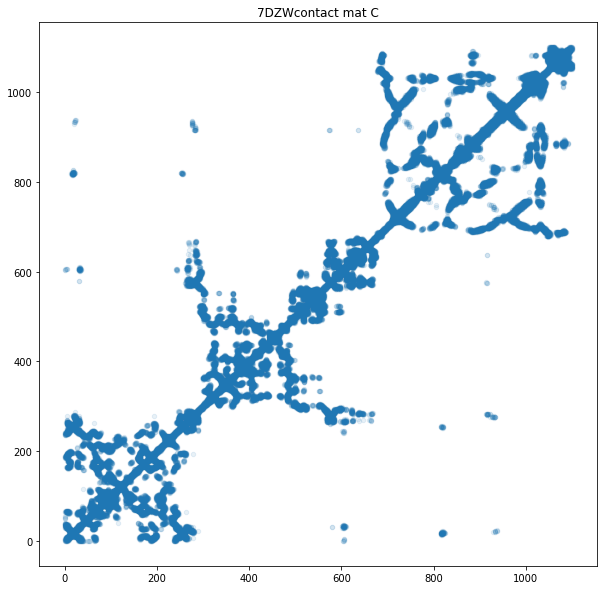

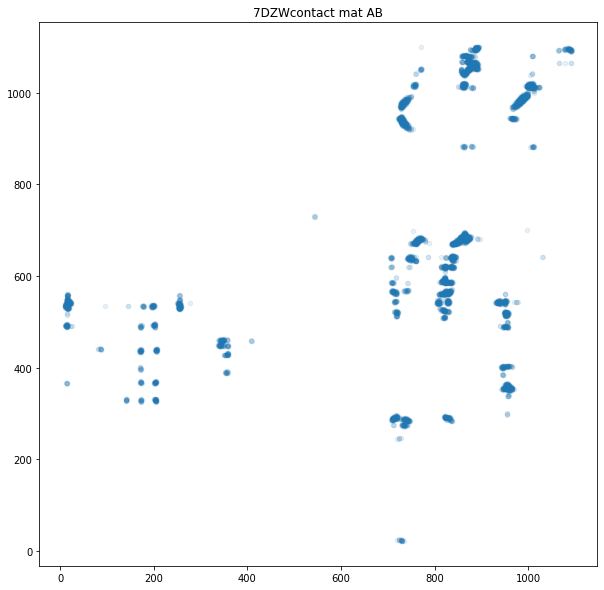

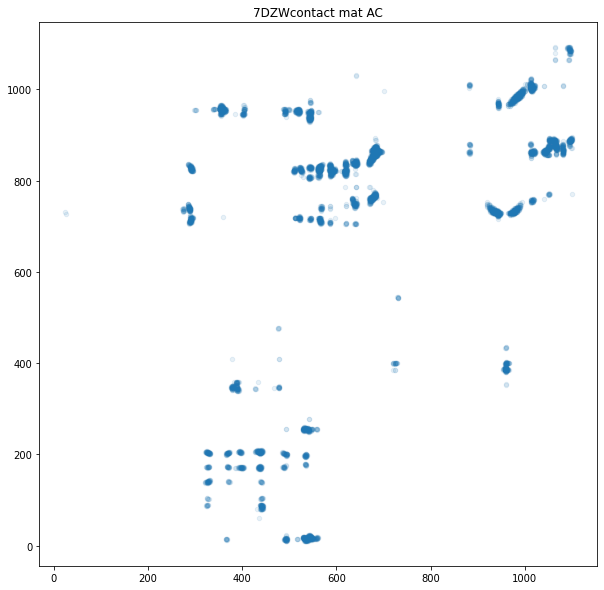

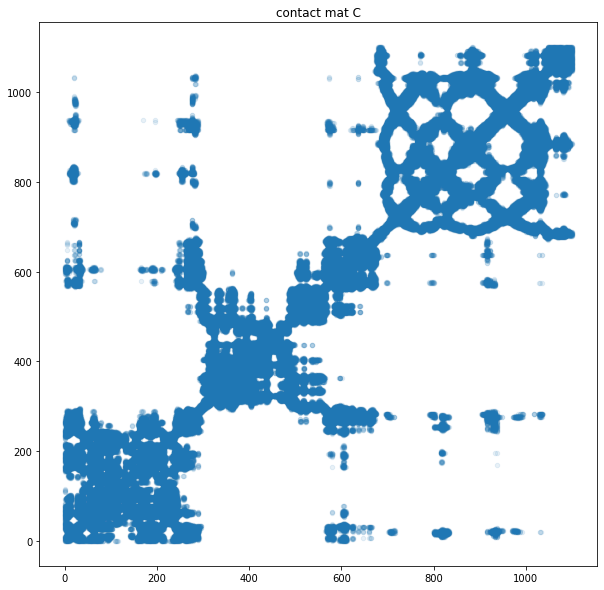

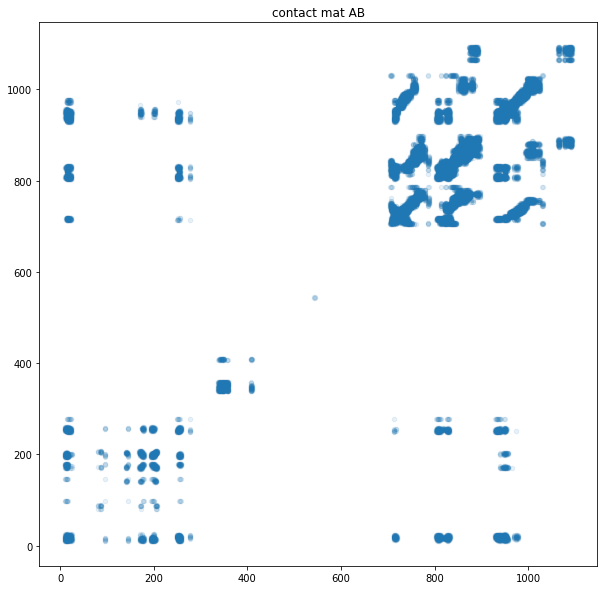

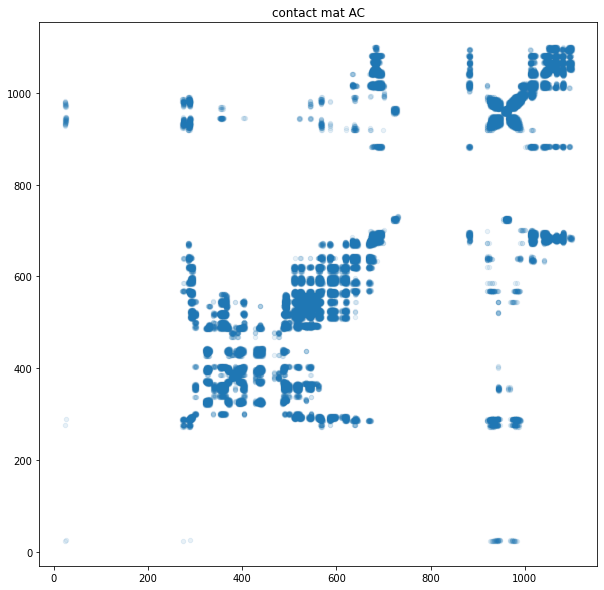

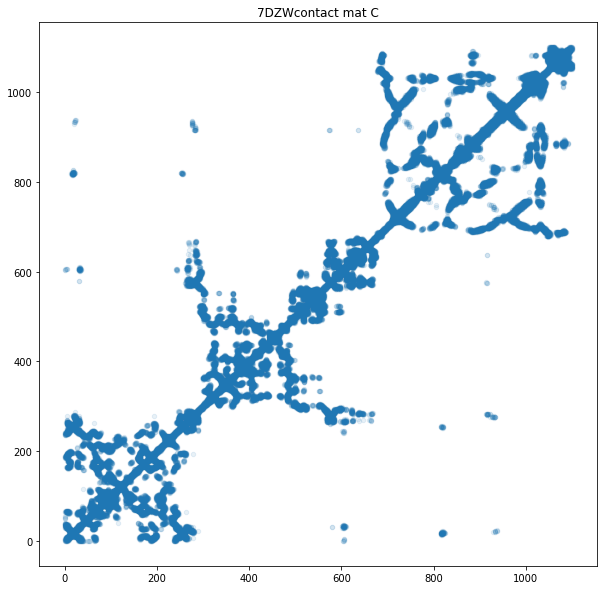

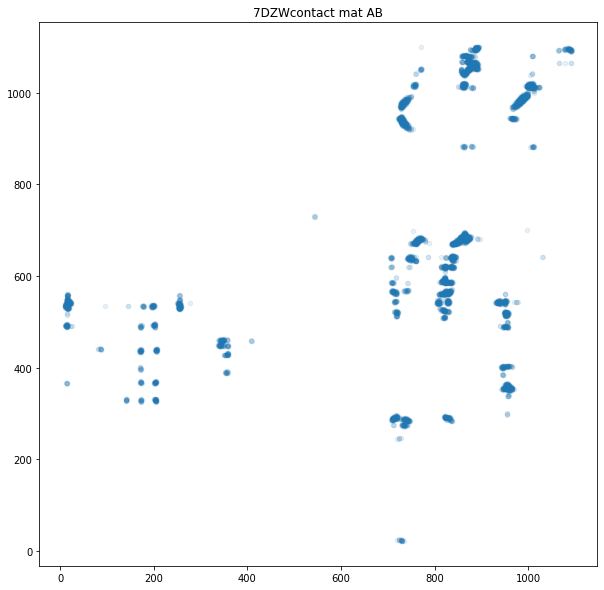

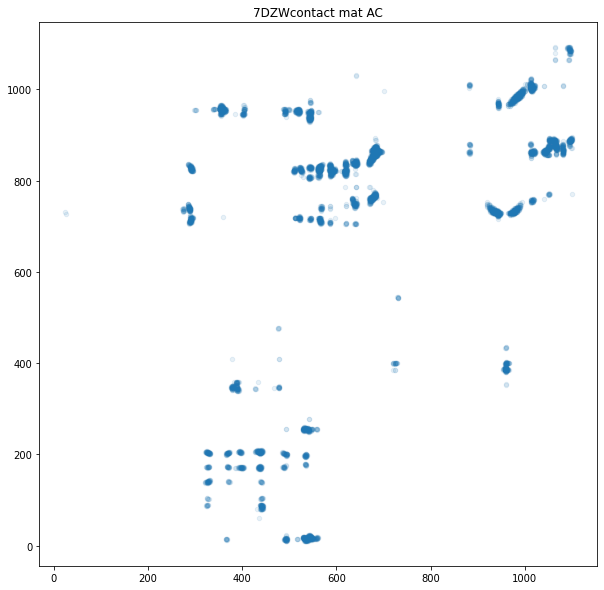

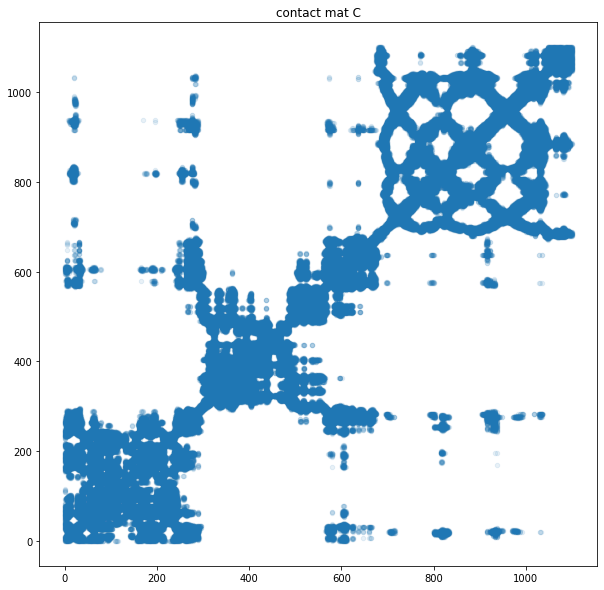

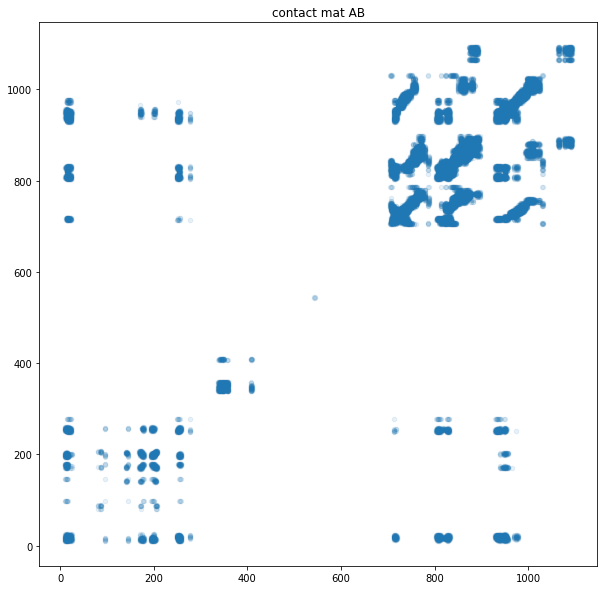

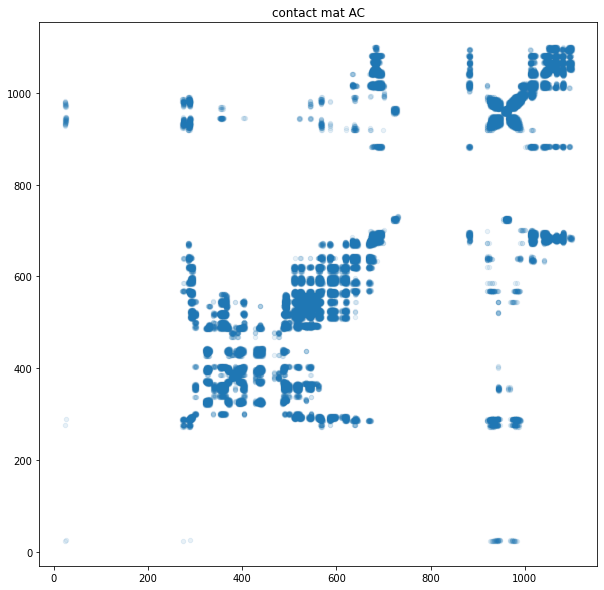

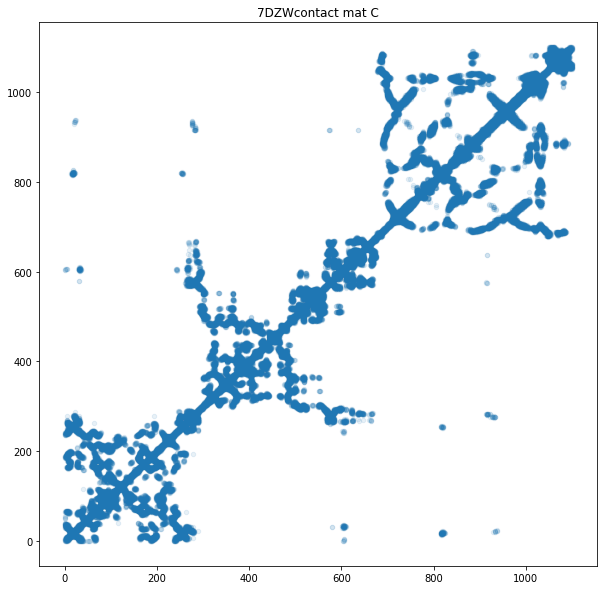

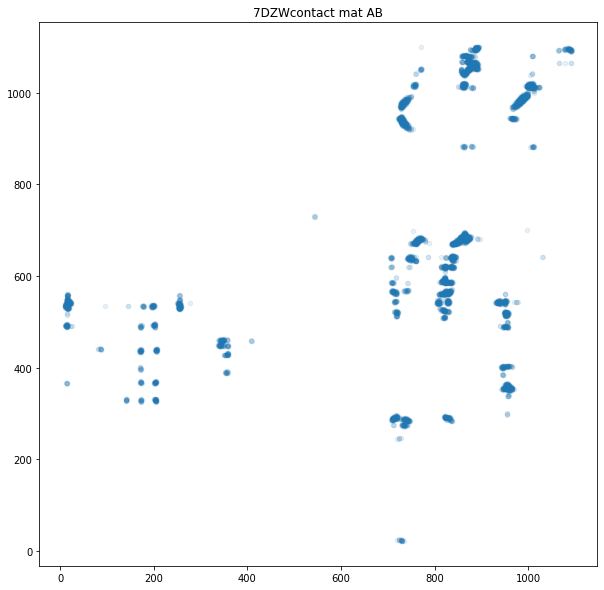

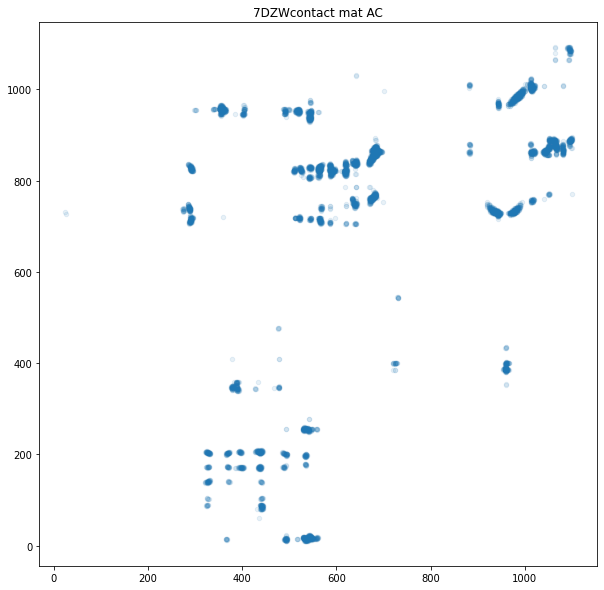

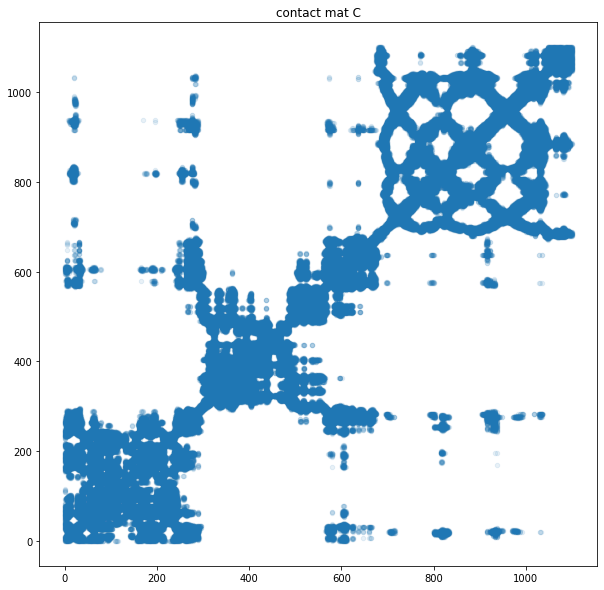

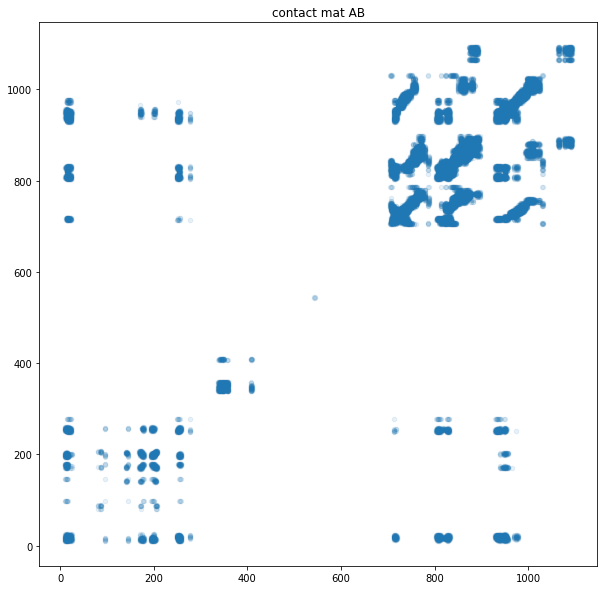

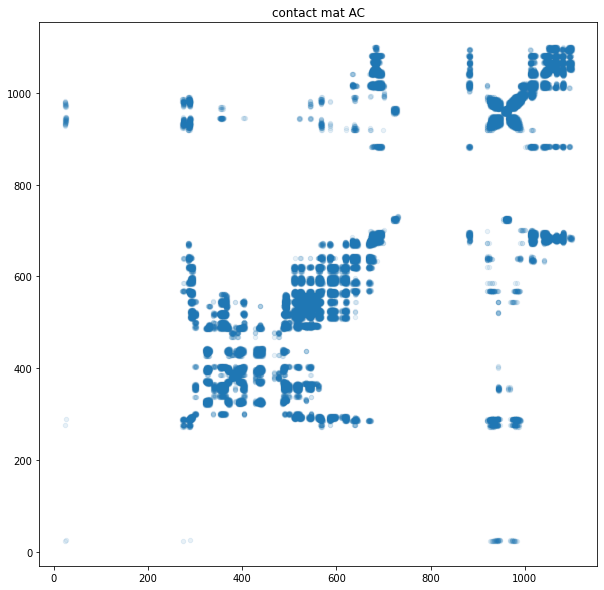

6ZXN []
6ZXN [[105.43495   104.45033   106.485435  ... 145.26166   146.80219
  148.97823  ]
 [106.58644   105.54056   107.56456   ... 142.5488    144.03731
  146.2593   ]
 [110.037636  108.99916   111.04407   ... 143.10655   144.51752
  146.80168  ]
 ...
 [144.8074    142.03035   141.78076   ...  11.652217    9.38361
   12.48479  ]
 [147.09552   144.35284   144.10771   ...  11.2723875   8.483409
   11.686805 ]
 [150.08505   147.31125   147.05142   ...  14.320892   11.061086
   13.575197 ]]
6ZXN [[108.07175   109.25909   112.6534    ... 144.55464   147.01593
  149.88551  ]
 [107.044685  108.17572   111.51612   ... 141.6369    144.12325
  146.97585  ]
 [107.90442   109.080444  112.399025  ... 142.08665   144.6025
  147.43445  ]
 ...
 [144.811     142.21301   142.07326   ...  11.694977   11.0246935
   14.406218 ]
 [145.70575   143.04959   142.81058   ...   9.1876335   7.9298205
   10.988567 ]
 [147.76814   145.15355   144.92197   ...  11.845124   10.748947
   13.069628 ]]
err 6ZXN
err 6ZX

2022-07-15 14:29:16,787 - distributed.worker - WARNING - Compute Failed
Key:       define_contacts-e9ac356a-b917-493c-b560-27df9b3842b8
Function:  define_contacts
args:      (array([], dtype=float64), 15)
kwargs:    {}
Exception: "ValueError('array must be at least 2-d')"

2022-07-15 14:29:16,922 - distributed.worker - WARNING - Compute Failed
Key:       define_contacts-b9f066a4-9e27-4a0f-bcc0-1cc6ee91a084
Function:  define_contacts
args:      (array([], dtype=float64), 15)
kwargs:    {}
Exception: "ValueError('array must be at least 2-d')"



err 6VXX
err 6VXX
err 6VXX
6NB6 []
6NB6 [[104.15836   105.02547   108.386894  ... 148.68636   147.21118
  150.02155  ]
 [102.85223   103.70741   107.03427   ... 146.29639   144.81696
  147.6683   ]
 [104.47351   105.353836  108.65912   ... 146.08572   144.54918
  147.41914  ]
 ...
 [145.83603   143.3071    142.9566    ...  16.83649    13.115558
   14.222814 ]
 [146.04878   143.45491   143.0695    ...  14.8907385  11.084443
   11.663377 ]
 [147.62386   144.99776   144.52518   ...  12.843318    9.100076
    9.207124 ]]
6NB6 [[107.80847  106.24295  107.79157  ... 147.07726  147.17798  148.66489 ]
 [108.84132  107.226974 108.76856  ... 144.37846  144.42332  145.87112 ]
 [111.97762  110.298874 111.784065 ... 143.8711   143.89632  145.25343 ]
 ...
 [148.89964  146.12431  145.65965  ...  16.478827  14.178105  12.252134]
 [148.20743  145.41942  144.87912  ...  12.906856  10.718569   8.489577]
 [150.34552  147.60825  147.10356  ...  13.964105  11.111221   8.819717]]
err 6NB6
err 6NB6


2022-07-15 14:29:17,042 - distributed.worker - WARNING - Compute Failed
Key:       define_contacts-af2bcf5f-2032-401c-af0a-5a2bb8307891
Function:  define_contacts
args:      (array([], dtype=float64), 15)
kwargs:    {}
Exception: "ValueError('array must be at least 2-d')"

2022-07-15 14:29:17,221 - distributed.worker - WARNING - Compute Failed
Key:       define_contacts-4c9c9c53-ed63-405c-be7e-f28d371d834f
Function:  define_contacts
args:      (array([], dtype=float64), 15)
kwargs:    {}
Exception: "ValueError('array must be at least 2-d')"



err 6NB6
6ACK []
6ACK [[103.708755 104.98633  106.76101  ... 141.92354  138.48439  139.9212  ]
 [102.324326 103.54467  105.22273  ... 139.45084  136.01357  137.41109 ]
 [105.689224 106.878944 108.50559  ... 140.09764  136.6208   137.92473 ]
 ...
 [132.44182  129.88026  129.80334  ...  30.370844  28.120497  25.902481]
 [131.10278  128.50357  128.51103  ...  27.177366  24.725422  22.649906]
 [134.3798   131.75383  131.79768  ...  26.043537  23.712633  21.204786]]
6ACK [[103.34934  102.748695 106.37971  ... 131.72557  129.74083  132.89638 ]
 [104.94594  104.297424 107.89324  ... 129.70802  127.67604  130.78528 ]
 [106.513435 105.76654  109.352135 ... 129.3791   127.42945  130.56883 ]
 ...
 [142.93367  140.3441   141.01839  ...  28.948038  26.20685   24.549139]
 [139.14273  136.55267  137.2248   ...  27.110508  24.073217  22.746456]
 [138.41641  135.7592   136.36293  ...  23.47218   20.520796  19.026728]]
err 6ACK
err 6ACK
err 6ACK
6ACG []
6ACG [[104.56985  105.342384 107.235405 ... 142.14

2022-07-15 14:29:17,413 - distributed.worker - WARNING - Compute Failed
Key:       define_contacts-591fb78a-efd2-4599-88d9-2fdf04949481
Function:  define_contacts
args:      (array([], dtype=float64), 15)
kwargs:    {}
Exception: "ValueError('array must be at least 2-d')"

2022-07-15 14:29:17,590 - distributed.worker - WARNING - Compute Failed
Key:       define_contacts-8f129d61-1660-44a2-9f4c-36a2515fa5a5
Function:  define_contacts
args:      (array([], dtype=float64), 15)
kwargs:    {}
Exception: "ValueError('array must be at least 2-d')"



err 6ACG
err 6ACG
err 6ACG
6CS2 []
6CS2 [[104.61643   102.393684  104.41737   ... 148.21396   151.40137
  151.99916  ]
 [105.41514   103.231705  105.303215  ... 146.40988   149.60187
  150.11604  ]
 [108.70293   106.469986  108.48861   ... 146.03094   149.27516
  149.7574   ]
 ...
 [148.54726   146.26344   145.86266   ...  12.502753   15.491174
   13.772734 ]
 [148.66205   146.40855   145.93996   ...   9.139391   11.822861
    9.9583845]
 [152.23756   150.00752   149.563     ...  11.318111   13.255138
   10.632558 ]]
6CS2 [[105.44863   106.28119   109.56275   ... 151.0927    152.55528
  151.68626  ]
 [103.04057   103.89889   107.13788   ... 148.81114   150.21437
  149.37984  ]
 [105.25912   106.15402   109.348206  ... 148.54207   149.87573
  148.9726   ]
 ...
 [147.54027   145.49744   145.00824   ...  11.193932   10.380983
    7.3633223]
 [150.57187   148.5771    148.12291   ...  14.169821   12.99123
    9.528894 ]
 [152.09787   150.05066   149.62964   ...  13.760423   13.392838
    9.

2022-07-15 14:29:17,734 - distributed.worker - WARNING - Compute Failed
Key:       define_contacts-11f8b71e-3ebc-453d-9430-79e175eabd21
Function:  define_contacts
args:      (array([], dtype=float64), 15)
kwargs:    {}
Exception: "ValueError('array must be at least 2-d')"

2022-07-15 14:29:17,934 - distributed.worker - WARNING - Compute Failed
Key:       define_contacts-5d901c3a-2a72-4878-98b9-b3075c70df8d
Function:  define_contacts
args:      (array([], dtype=float64), 15)
kwargs:    {}
Exception: "ValueError('array must be at least 2-d')"



err 6NB7
err 6NB7
err 6NB7
6CS0 []
6CS0 [[107.63961  105.06258  105.991165 ... 131.24539  130.28697  133.317   ]
 [108.29632  105.80395  106.83433  ... 130.16068  129.10931  132.09227 ]
 [111.74434  109.23328  110.23017  ... 130.22476  129.19653  132.20999 ]
 ...
 [141.14641  140.19447  140.63756  ...  31.791277  28.596262  27.544683]
 [138.09636  137.1417   137.53722  ...  28.813938  25.468569  24.369713]
 [139.40128  138.37195  138.67177  ...  26.215736  23.092466  22.08309 ]]
6CS0 [[102.15696  103.276    106.80618  ... 145.22174  142.15262  142.70276 ]
 [100.32926  101.482765 104.99573  ... 142.29495  139.2133   139.71234 ]
 [103.47825  104.64857  108.14603  ... 142.42863  139.28824  139.71487 ]
 ...
 [129.1684   128.6842   128.89146  ...  31.394985  28.641695  25.437809]
 [129.32172  128.76953  129.00911  ...  29.509514  26.494541  23.405577]
 [131.5846   130.94998  131.16568  ...  27.264357  24.18819   21.023237]]
err 6CS0
err 6CS0


2022-07-15 14:29:18,060 - distributed.worker - WARNING - Compute Failed
Key:       define_contacts-52b0767b-3b60-4e44-9248-b696831558a6
Function:  define_contacts
args:      (array([], dtype=float64), 15)
kwargs:    {}
Exception: "ValueError('array must be at least 2-d')"

2022-07-15 14:29:18,244 - distributed.worker - WARNING - Compute Failed
Key:       define_contacts-6386d831-5e80-458d-ad50-49ac893726cc
Function:  define_contacts
args:      (array([], dtype=float64), 15)
kwargs:    {}
Exception: "ValueError('array must be at least 2-d')"



err 6CS0
5X58 []
5X58 [[101.94964   100.098015  103.21899   ... 121.69163   120.715485
  119.9469   ]
 [103.374084  101.56393   104.685425  ... 120.026665  118.9696
  118.18864  ]
 [106.09327   104.19656   107.26106   ... 119.84446   118.708275
  117.808685 ]
 ...
 [128.82838   127.097664  127.33406   ...  15.914684   14.4769125
   16.534706 ]
 [128.85138   127.2122    127.41423   ...  18.15301    17.313995
   19.743647 ]
 [130.69806   129.14662   129.37584   ...  21.883942   21.033907
   23.34757  ]]
5X58 [[101.95019  103.375046 106.094925 ... 128.82835  128.85109  130.69783 ]
 [100.09898  101.56533  104.198685 ... 127.098495 127.21274  129.14722 ]
 [103.21982  104.68666  107.26305  ... 127.333954 127.4138   129.37549 ]
 ...
 [121.689995 120.02517  119.84398  ...  15.914815  18.152845  21.884108]
 [120.71491  118.96917  118.708824 ...  14.478113  17.31477   21.034927]
 [119.94529  118.187164 117.80819  ...  16.535885  19.744482  23.348637]]
err 5X58
err 5X58
err 5X58
6NUR []
6NUR [[83

2022-07-15 14:29:18,367 - distributed.worker - WARNING - Compute Failed
Key:       define_contacts-24238818-db68-4a45-a765-eb7b9eb551db
Function:  define_contacts
args:      (array([], dtype=float64), 15)
kwargs:    {}
Exception: "ValueError('array must be at least 2-d')"

2022-07-15 14:29:18,424 - distributed.worker - WARNING - Compute Failed
Key:       define_contacts-5a13044b-ee9e-4222-b846-03f287a6b783
Function:  define_contacts
args:      (array([], dtype=float64), 15)
kwargs:    {}
Exception: "ValueError('array must be at least 2-d')"

2022-07-15 14:29:18,491 - distributed.worker - WARNING - Compute Failed
Key:       define_contacts-84edc250-fe57-4040-83cd-168fe9b6415c
Function:  define_contacts
args:      (array([], dtype=float64), 15)
kwargs:    {}
Exception: "ValueError('array must be at least 2-d')"

2022-07-15 14:29:18,540 - distributed.worker - WARNING - Compute Failed
Key:       define_contacts-aa06a8aa-1b1e-46a5-af27-58ebea65271e
Function:  define_contacts
args:      (arr

err 5C8U
err 5C8U
err 5C8U
2GT7 []
2GT7 [[32.470608 28.846975 26.295134 ... 32.450123 31.902609 31.222338]
 [28.899189 25.249912 22.628557 ... 29.46924  29.193356 28.851202]
 [25.971457 22.302717 20.002287 ... 27.724455 27.42194  27.404669]
 ...
 [31.352793 27.843767 26.097563 ... 32.72397  31.68385  31.160728]
 [35.01139  31.5095   29.647066 ... 35.625935 34.45035  33.618572]
 [37.51369  34.07423  32.49481  ... 38.56146  37.20087  36.341114]]
2GT7 [[113.19804  112.10753  112.069756 ... 124.659546 127.5005   130.20564 ]
 [116.19497  115.03538  114.9723   ... 127.66268  130.46346  133.12886 ]
 [118.18258  117.11008  117.14355  ... 129.83113  132.64499  135.37216 ]
 ...
 [110.24778  109.86543  111.42997  ... 124.64711  126.77842  129.94566 ]
 [110.53398  110.28002  111.915245 ... 124.95039  127.12406  130.35245 ]
 [109.054695 108.92204  110.64501  ... 123.50485  125.692    128.97224 ]]
err 2GT7
err 2GT7
err 2GT7
2WCT []
2WCT [[42.2339   44.57937  45.663013 ... 58.023586 54.538593 52.4045

2022-07-15 14:29:18,601 - distributed.worker - WARNING - Compute Failed
Key:       define_contacts-12e048e8-051d-40bd-882d-59211f0641ce
Function:  define_contacts
args:      (array([], dtype=float64), 15)
kwargs:    {}
Exception: "ValueError('array must be at least 2-d')"

2022-07-15 14:29:18,666 - distributed.worker - WARNING - Compute Failed
Key:       define_contacts-58c8b4be-7682-43bf-9264-ddf75063ea19
Function:  define_contacts
args:      (array([], dtype=float64), 15)
kwargs:    {}
Exception: "ValueError('array must be at least 2-d')"

2022-07-15 14:29:18,722 - distributed.worker - WARNING - Compute Failed
Key:       define_contacts-2547f4c0-79b0-4bfe-afe5-22e745fbc59e
Function:  define_contacts
args:      (array([], dtype=float64), 15)
kwargs:    {}
Exception: "ValueError('array must be at least 2-d')"

2022-07-15 14:29:18,769 - distributed.worker - WARNING - Compute Failed
Key:       define_contacts-7e45c2f4-d942-45eb-acc5-0f8273d181aa
Function:  define_contacts
args:      (arr

err 2GHW
err 2GHW
err 2GHW
2ACF []
2ACF [[40.935856 41.93514  40.332695 ... 70.60523  67.156456 68.7691  ]
 [43.210014 43.94543  42.128834 ... 71.151535 67.686295 69.33638 ]
 [42.72366  43.192448 41.385166 ... 70.74601  67.36211  69.200615]
 ...
 [54.429874 52.43518  49.58317  ... 64.345634 61.71019  64.29594 ]
 [56.61667  54.80293  51.949966 ... 67.232895 64.49805  66.9681  ]
 [58.513992 56.630215 53.63199  ... 66.626144 63.91482  66.29582 ]]
2ACF [[31.871437 30.081482 32.08862  ... 62.260952 61.23339  64.57631 ]
 [28.916798 27.009434 28.799824 ... 59.635555 58.450565 61.77714 ]
 [25.790585 24.172934 26.232914 ... 58.66579  57.36468  60.565018]
 ...
 [32.16298  33.57027  33.22031  ... 69.22671  66.15589  68.11708 ]
 [34.644817 35.77802  35.414265 ... 71.378235 68.34127  70.427635]
 [37.486767 38.78998  38.33857  ... 73.77753  70.64874  72.60523 ]]
err 2ACF
err 2ACF
err 2ACF
2G9T []
2G9T [[43.95202  40.531857 42.10999  ... 27.600676 27.989761 29.07599 ]
 [43.49402  40.203274 41.82504  

2022-07-15 14:29:18,816 - distributed.worker - WARNING - Compute Failed
Key:       define_contacts-1112d7f1-9243-4a3a-af48-2095fd4c41db
Function:  define_contacts
args:      (array([], dtype=float64), 15)
kwargs:    {}
Exception: "ValueError('array must be at least 2-d')"

2022-07-15 14:29:18,863 - distributed.worker - WARNING - Compute Failed
Key:       define_contacts-7ebfb7ff-8268-4e08-8a55-da9005b52658
Function:  define_contacts
args:      (array([], dtype=float64), 15)
kwargs:    {}
Exception: "ValueError('array must be at least 2-d')"

2022-07-15 14:29:18,910 - distributed.worker - WARNING - Compute Failed
Key:       define_contacts-15a759ff-d792-46ee-81ca-18cc7a5051c0
Function:  define_contacts
args:      (array([], dtype=float64), 15)
kwargs:    {}
Exception: "ValueError('array must be at least 2-d')"

2022-07-15 14:29:18,954 - distributed.worker - WARNING - Compute Failed
Key:       define_contacts-2e6e9531-87be-4179-806a-e4fff5882613
Function:  define_contacts
args:      (arr

err 3EE7
1YO4 []
1YO4 [[280.7639  278.33536 277.1426  ... 265.54395 268.8839  272.0884 ]
 [282.89816 280.4717  279.3146  ... 268.20172 271.52414 274.74603]
 [281.2796  278.8215  277.6621  ... 266.5732  269.88913 273.11304]
 ...
 [308.06683 305.34152 304.1345  ... 292.12128 295.4242  298.5727 ]
 [308.789   306.03888 304.79095 ... 292.18378 295.50394 298.62616]
 [312.21362 309.45242 308.2056  ... 295.57263 298.8913  302.0082 ]]
1YO4 [[271.40656 268.8315  268.17242 ... 264.70673 267.6278  271.0708 ]
 [271.54413 268.94205 268.23114 ... 264.0373  266.98834 270.40985]
 [269.98605 267.40726 266.68658 ... 262.36124 265.32684 268.7516 ]
 ...
 [292.65463 290.23343 289.65048 ... 286.737   289.68872 293.15823]
 [290.13745 287.74533 287.18082 ... 284.55157 287.4949  290.976  ]
 [287.6179  285.21106 284.66077 ... 282.2953  285.21924 288.70572]]
err 1YO4
err 1YO4
err 1YO4
1YSY []
1YSY [[278.12808 280.27414 278.1856  ... 253.63559 256.15195 259.74966]
 [280.40802 282.5536  280.48306 ... 255.94185 258.

PicklingError: Can't pickle <function define_contacts at 0x7f25f072df70>: it's not the same object as __main__.define_contacts

2022-07-15 14:34:09,313 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-07-15 14:50:09,327 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-07-15 15:00:28,855 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


In [36]:
import copy
angstrom_cutoff = 15
show_contacts = True

if overwrite_connect == True:
    @dask.delayed( nout = 2)
    def define_contacts(mat , angstrom_cutoff = 15 ):
        subthresh = copy.deepcopy(mat)
        subthresh[ subthresh < angstrom_cutoff ] = 1 
        subthresh[ subthresh > angstrom_cutoff ] = 0 
        np.fill_diagonal(subthresh , 0)
        subthresh = subthresh[0:subthresh.shape[0]-20,0:subthresh.shape[1]-20]
        connected = np.dot(subthresh,subthresh.T)
        return subthresh,connected

    subthresh_thresh ={}
    subthresh_connected ={}

    chain_equivalencies={}
    for m in distmats:
        for chain in distmats[m]:
            if m not in subthresh_thresh:
                subthresh_thresh[m]={}
                subthresh_connected[m] ={}
                for chain in distmats[m]:
                    subthresh, connected = define_contacts(distmats[m][chain] , angstrom_cutoff  )
                    subthresh_thresh[m][chain] = subthresh
                    subthresh_connected[m][chain] = connected
                    print(m, distmats[m][chain])
            try:
                subthresh_thresh[m] = dict( zip ( subthresh_thresh[m].keys() , dask.compute( * list(subthresh_thresh[m].values() ))))
                subthresh_connected[m] = dict( zip ( subthresh_connected[m].keys() , dask.compute( * list(subthresh_connected[m].values() ))))
                if show_contacts == True:
                    for chain in subthresh_thresh[m]:
                        subthresh = subthresh_thresh[m][chain]

                        plt.figure(figsize=(10,10) )
                        plt.title(m +'contact mat '+ ''.join(chain) )
                        plt.scatter( np.nonzero(subthresh)[0] ,np.nonzero(subthresh)[1]  , marker= 'o' , alpha = .1 ,  s = 20)
                        plt.show()

                    for chain in subthresh_connected[m]:
                        connected = subthresh_connected[m][chain]
                        plt.figure(figsize=(10,10) )
                        plt.title('contact mat '+ ''.join(chain) )
                        plt.scatter( np.nonzero(connected)[0] ,np.nonzero(connected)[1]  , marker= 'o' , alpha = .1 ,  s = 20)
                        plt.show()
            except:
                print('err' , m )
    with open(modeldir + 'contactmaps' , 'wb') as connectout:
        connectout.write(pickle.dumps((subthresh_thresh , subthresh_connected)))
else:
    with open(modeldir + 'contactmaps' , 'rb') as connectout:
        subthresh_thresh , subthresh_connected = pickle.loads(connectout.read())

In [ ]:

allpairs = {}

print(subthresh_thresh)
print(subthresh_connected)

for code in subthresh_thresh:
    if code not in allpairs:
        allpairs[code] = {}
    for chainpair in subthresh_thresh[code]:
        pairs = np.nonzero(subthresh_thresh[code][chainpair])
        pairset = set([ ( pairs[0][i] , pairs[1][i] ) for i in range(pairs[0].shape[0]) ])
        
        allpairs[code][chainpair] = pairset

In [39]:
def tree2Single_sparse_graph_updown(tree):
    N = len(tree.nodes())
    #mimic the fitch algo
    #propagate up and down in separate graphs
    
    
    ntime = np.array([ n.distance_from_root() for n in tree.nodes()])
    mtime = np.amax(ntime)
    
    ntime/=mtime
    
    levels = np.array([ n.level() for n in tree.nodes() ] , dtype='double')
    mlevel = np.amax(levels)
    levels/=mlevel
    edgelens= np.array([ n.edge_length for n in tree.nodes() ] , dtype='double')
    template_features = np.stack([ntime ,  edgelens , levels ]).T    
    template_features = np.nan_to_num(template_features)
    
    return template_features

def sparse2pairs(sparsemat, matrows = None):
    if matrows :
        sparsemat = sparsemat[matrows,:]
        sparsemat = sparsemat[:,matrows]
    sparsemat = scipy.sparse.find(sparsemat)
    return np.vstack([sparsemat[0],sparsemat[1]])



In [46]:
compile_templates = True
if compile_templates == True:
    #check correlation of graphnet score w jaccard
    template_features = tree2Single_sparse_graph_updown(tree)
    print(template_features.shape)
    with open('template_features.pkl' , 'wb') as templateout:
        templateout.write(pickle.dumps( template_features ))
else:
    with open('template_features.pkl' , 'rb') as template_in:
        template_features = pickle.loads(template_in.read())

(741326, 3)


In [47]:
print('template features', template_features )

template features [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.75746924e-03]
 [0.00000000e+00 0.00000000e+00 1.75746924e-03]
 ...
 [7.80477225e-01 5.00000000e-09 3.21616872e-01]
 [7.80466929e-01 5.00000000e-09 3.16344464e-01]
 [8.72536248e-01 1.34153000e-04 3.12829525e-01]]


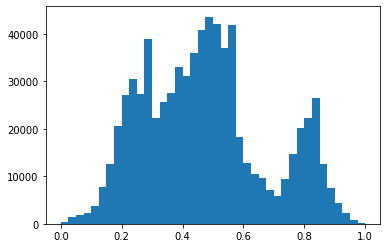

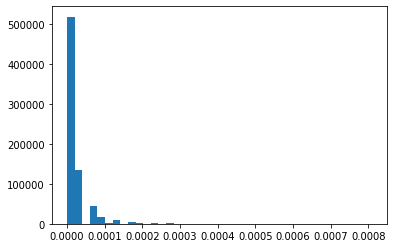

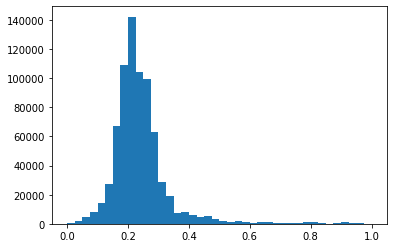

In [48]:
for i in range(template_features.shape[1]):
    plt.hist(np.array(template_features[:,i].data).flat, bins = 40)
    plt.show()

In [102]:
def ret_pytorch_sample(subfeatures, connect_up , connect_down , sub_diag ,  overview , overview_rev , intra , toss ):
    data = HeteroData()
    #add input data
    data['phylonodes_up'].x = torch.tensor( subfeatures )
    data['phylonodes_down'].x =torch.tensor( subfeatures )
    data['sectornode'].x =torch.tensor(  np.zeros((1,1)) )
    #up down fitch net
    data['phylonodes_up', 'phylolink_up', 'phylonodes_up'].edge_index = torch.tensor(connect_up ,  dtype=torch.long )
    data['phylonodes_down', 'phylolink_down', 'phylonodes_down'].edge_index = torch.tensor(connect_down ,  dtype=torch.long )             
    data['phylonodes_up', 'phylolink_up_down', 'phylonodes_down'].edge_index = torch.tensor( sub_diag ,  dtype=torch.long )
    data['phylonodes_down', 'phylolink_down_up', 'phylonodes_up'].edge_index = torch.tensor( sub_diag ,  dtype=torch.long )

    #pooling connections
    data['phylonodes_down', 'informs', 'sectornode'].edge_index = torch.tensor(overview ,  dtype=torch.long )
    data['phylonodes_up', 'informs', 'sectornode'].edge_index = torch.tensor(overview ,  dtype=torch.long )

    #pooling connections
    data['sectornode',  'informs', 'phylonodes_down' ].edge_index = torch.tensor(overview_rev,  dtype=torch.long )
    data['sectornode',  'informs', 'phylonodes_up'].edge_index = torch.tensor(overview_rev ,  dtype=torch.long )
    #categories are intra or interprotein contacts or nothing
    if intra == True:
        cateforical = np.array([0,1])
    else:
        cateforical = np.array([1,0])
    data['phylonodes_down'].y =torch.tensor( np.ones((subfeatures.shape[0],1) ) *toss ,  dtype=torch.long )
    data['phylonodes_up'].y =torch.tensor( np.ones((subfeatures.shape[0],1)) * toss ,  dtype=torch.long )
    #todo change to categorical
    data['sectornode'].y =torch.tensor(  np.ones((1,1))*toss  ,  dtype=torch.long )
    data = T.AddSelfLoops()(data)
    #data = T.NormalizeFeatures()(data)
    return data

def yield_tosses(posi_percent = .5):
    while True:
        toss = scipy.stats.bernoulli.rvs(posi_percent, loc=0, size=1, random_state=None)
        yield toss

def gen_sample(toss , col1 , col2 , pairs, AA_tensor, NT_tensor, template_features  ,  
    posi_percent = .5 , nsamples = 30 , min_nodes = 10,  q = None , iolock= None,  
    verbose = False, loop= True , sectors_chunk = True , intra = True , subsample = False ):
    #generate a few samples of subgraphs from a column pair
    label = np.ones((1,1))*toss
    #select coev features
    if verbose == True:
        print( 'col1',AA_tensor[:,col1,:] )
        print( 'col2', AA_tensor[:,col2,:] ) 
    nodeAAfeatures = sparse.stack( [AA_tensor[:,col1,:] ,AA_tensor[:,col2,:] ] , axis = 2  ).reshape((AA_tensor.shape[0],-1))
    nt_cols = []
    for pos in [0,1,2]: 
        nodeNTfeatures = sparse.stack( [NT_tensor[:,col1+ pos,:] ,NT_tensor[:, col2+ pos,:] ] , axis = 2)
        nt_cols.append(nodeNTfeatures.reshape((nodeNTfeatures.shape[0],-1)) )
    available_rows = list(np.where( nodeAAfeatures.sum(axis=1) > 0 )[0])
    if verbose == True:
        print(nodeAAfeatures)
        print(available_rows)
    features = [nodeAAfeatures] + nt_cols 
    features = [f.to_scipy_sparse() for f in features]
    nodefeatures = sparse.COO(scipy.sparse.hstack( features ))
    #slice the features into sectors and yield sectors
    samples =[]
    #select a row where the is at least 1 mutation
    #rows = gen_graphchunk(connectmat, start_node=random.choice(available_rows) , niter = 10 , verbose = False, plotmat=False)
    rows, connectmat = find_paths(AA_tensor[:,col1,:],AA_tensor[:,col2,:])
    #node features
    subfeatures = np.hstack( [ template_features[rows,:].todense() , nodefeatures[rows,:].todense() ] )
    #phylonode connections
    connect_up = sparse2pairs(connectmat)
    connect_down = sparse2pairs(connectmat.T)
    sub_diag = sparse.eye(connectmat.shape[0]).to_scipy_sparse()
    sub_diag = sparse2pairs(sub_diag)
    
    #aggregator node
    overview = scipy.sparse.lil_matrix( (subfeatures.shape[0], 2 ) )
    overview[:,0] = 1
    overview_rev = sparse2pairs(overview.T)
    overview = sparse2pairs(overview)
    data = ret_pytorch_sample(subfeatures, connect_up , connect_down , sub_diag ,  overview , overview_rev , intra , toss )
    return data


def check_pts(col, allcols):
    for i in range(30):
        if i+col in allcols:
            return i+col
        if -i+col in allcols:
            return -i+col
    else:
        return None

def create_data_updown_transitions_single( pairs, AA_tensor, NT_tensor, template_features, allcols,  posi_percent = .5 , nsamples = 30 , min_nodes = 100,  q = None , iolock= None,  verbose = True, loop= True , sectors_chunk = True ):
    #map
    tossgen = yield_tosses(posi_percent)
    for toss in tossgen:
        if toss == 0:
            col1 = random.choice(allcols)
            col2 = col1
            while col1 == col2 and (col1,col2) not in pairs:
                col2 = random.choice(allcols)
            labels = np.zeros((template_features.shape[0],))           
        else:
            #positive sample
            pairindex = random.randint(0,pairs[0].shape[0]-1)
            pairtuple = ( pairs[0][pairindex] , pairs[1][pairindex])
            while True:
                col1 = pairtuple[0]
                col1 = check_pts(col1, allcols)
                col2 = pairtuple[1]
                col2 = check_pts(col2, allcols)
                if col1 and col2 and col1!= col2:
                    break
                pairindex = random.randint(0,pairs[0].shape[0]-1)
                pairtuple = ( pairs[0][pairindex] , pairs[1][pairindex])
        if verbose == True:
            print(toss)
            print(col1, col2)
        yield  gen_sample( toss , col1 , col2 ,  pairs, AA_tensor, NT_tensor , template_features ,  posi_percent = .5 ,  q = None , iolock= None,  verbose = verbose, loop= True  ) 
        

In [103]:
#create reduced alphabet mapping
#AA transitions

murphy12 = [('L','V','I','M'), ('C'), ('A'), ('G'), ('S','T'), ('P'), ('F','Y'), ('W'), ('E','Q'), ('D','N'), ('K','R'), ('H') ]
murphy12 = { c:i for i,cset in enumerate(murphy12) for c in cset   }
print('murphy12',murphy12)

ProteinAlphabet = [ 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y' ]
allowed_AA_transitions = [ c1+c2 for c1 in ProteinAlphabet for c2 in ProteinAlphabet  if c1!= c2]

print('ntransitions' ,len(set(allowed_AA_transitions)))
new_transitions = [ (murphy12[c1],murphy12[c2]) for c1 in ProteinAlphabet for c2 in ProteinAlphabet  if c1!= c2  ]
new_transitions = { tup:i for i,tup in enumerate(set(new_transitions)) }
print('nmurphy transitions' , len(set(new_transitions)))
print(allowed_AA_transitions[0:100] , '...etc...')
transitiondict_AA = {  c : i  for i,c in enumerate( allowed_AA_transitions )  }
rev_transitiondict_AA = dict( zip(transitiondict_AA.values(), transitiondict_AA.keys()))


murphy12 {'L': 0, 'V': 0, 'I': 0, 'M': 0, 'C': 1, 'A': 2, 'G': 3, 'S': 4, 'T': 4, 'P': 5, 'F': 6, 'Y': 6, 'W': 7, 'E': 8, 'Q': 8, 'D': 9, 'N': 9, 'K': 10, 'R': 10, 'H': 11}
ntransitions 380
nmurphy transitions 138
['AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'AI', 'AK', 'AL', 'AM', 'AN', 'AP', 'AQ', 'AR', 'AS', 'AT', 'AV', 'AW', 'AY', 'CA', 'CD', 'CE', 'CF', 'CG', 'CH', 'CI', 'CK', 'CL', 'CM', 'CN', 'CP', 'CQ', 'CR', 'CS', 'CT', 'CV', 'CW', 'CY', 'DA', 'DC', 'DE', 'DF', 'DG', 'DH', 'DI', 'DK', 'DL', 'DM', 'DN', 'DP', 'DQ', 'DR', 'DS', 'DT', 'DV', 'DW', 'DY', 'EA', 'EC', 'ED', 'EF', 'EG', 'EH', 'EI', 'EK', 'EL', 'EM', 'EN', 'EP', 'EQ', 'ER', 'ES', 'ET', 'EV', 'EW', 'EY', 'FA', 'FC', 'FD', 'FE', 'FG', 'FH', 'FI', 'FK', 'FL', 'FM', 'FN', 'FP', 'FQ', 'FR', 'FS', 'FT', 'FV', 'FW', 'FY', 'GA', 'GC', 'GD', 'GE', 'GF'] ...etc...


In [104]:
print(pairs[0].shape)

(5168,)


In [105]:
#reduce alphabet to reduce AA transition dimensionality
def restrictAA_transitions(AAmat, rev_transitiondict_AA, murphy12 , new_transitions , restricted_transitions = 138 , verbose = True ):
    restricted = None
    for z in range(AAmat.shape[2]):
        
        transition = rev_transitiondict_AA[z]
        new_transition = new_transitions[ (murphy12[transition[0]] , murphy12[transition[1]] )]
        data = AAmat[:,:,z].data
        coords =  AAmat[:,:,z].coords
        if coords.shape[1]>0:    
            newcoords = np.vstack( [coords, np.ones((1,coords.shape[1]))*new_transition]).astype('int')
            if restricted is not None:
                restricted  += sparse.COO( coords =  newcoords , data = data
                                            , shape = (AAmat.shape[0] , AAmat.shape[1] , restricted_transitions )  )
            else:
                restricted  =  sparse.COO( coords = newcoords , data = data  
                                            , shape = (AAmat.shape[0] , AAmat.shape[1] , restricted_transitions )  )
    return restricted


In [106]:
###rewrite codon compilation for sparse
import sparse

restrictAA = False
collapseMats = True
buildstructmats = False
if buildstructmats == True:
    def retcodons( AAmat , NTmat, qstart, qend, verbose = True ):
        #aa mutations for each pos
        AAmat_sub = sparse.stack(  [ AAmat[ : , codon:codon+2 , : ].sum(axis = 1) for codon in range(qstart-1, qend-1 , 3 )  ] , axis = 1 )    
        #add the frames for each in a stack 
        if verbose == True:
            print('done AA')
        NTmat_sub = sparse.stack([  sparse.stack( [ NTmat[:, codon + frame , : ] for frame in [0,1,2] ] , axis = 1 )  for codon in range(qstart-1, qend-1 , 3 ) ] , axis = 1)
        if verbose == True:
            print('done NT')
        return AAmat_sub , NTmat_sub
    print(annotation)
    structmats = {}
    start_stop ={}
    print(nucleotide_mutation)
    print(AA_mutation)

    for i,row  in annotation.iterrows():
        print(row.qstart)
        if row.struct not in structmats:
            structmats[row.struct]={}    
        if (row.qstart , row.qend) not in start_stop:
            structmats[row.struct][row.chain ] = retcodons(AA_mutation, nucleotide_mutation  , row.qstart , row.qend)
            if restrictAA == True:
                structmats[row.struct][row.chain ] = ( restrictAA_transitions(structmats[row.struct][row.chain ][0] , rev_transitiondict_AA, murphy12 , new_transitions , restricted_transitions = 138 ) , structmats[row.struct][row.chain ][1] )
            elif collapseMats == True:
                endshapeAA = list(structmats[row.struct][row.chain ][0].shape)
                endshapeAA[2] = 1
                endshapeNT = list(structmats[row.struct][row.chain ][1].shape)
                endshapeNT[3] = 1
                structmats[row.struct][row.chain ] = ( structmats[row.struct][row.chain ][0].sum(axis = 2).reshape(endshapeAA) , structmats[row.struct][row.chain ][1].sum(axis = 3).reshape(endshapeNT) )
            start_stop[(row.qstart , row.qend)] = structmats[row.struct ][ row.chain ]
        else: 
            structmats[row.struct][row.chain ] = start_stop[(row.qstart , row.qend)]
    with open('structmats.pkl' , 'wb') as structout:
        structout.write( pickle.dumps( structmats ))
else:
    with open('structmats.pkl' , 'rb') as structout:
        structmats= pickle.loads(  structout.read())

In [107]:
#looking for more than 1 position
submat = structmats['7DZW']['C'][0]
submat = submat.sum(axis = 2)
allcols = list(np.where( submat.sum(axis = 0 ) > 10 )[0])
print(len(set(allcols)))

219


In [108]:
#using networkx to mutation tree
import networkx as nx
import scipy 
G = nx.DiGraph()
G.add_edges_from([[ e[0],e[1] ] for e in list(zip(list(graphmat.col), list(graphmat.row))) ])
print(G)

DiGraph with 741326 nodes and 741325 edges


In [109]:
def find_paths(col1,col2, verbose =False):
    both = col1+col2
    #both = both.sum(axis=1)
    
    nodefilter = list(set(both.coords[0]))
    if verbose == True:
        print(nodefilter)
    paths = [ nx.ancestors(G, source= n ) for n in nodefilter ]
    allnodes = set([])
    for p in paths:
        allnodes = allnodes.union(p)
    allnodes = list(allnodes)
    #extract subgraph
    subG = G.subgraph(allnodes)
    subG = nx.DiGraph(subG)
    collapsed = [ n for n, d in subG.degree() if d == 2 ]
    S = G.subgraph(collapsed)
    S = nx.Graph(S)

    remove = []
    for c in nx.connected_components(S):
        ends = [ n for n, d in S.subgraph(c).degree() if d == 1 ]
        #add edge in subG
        if len( ends ) == 2:
            subG.add_edge(ends[1], ends[0])
            remove += [ n for n, d in S.subgraph(c).degree() if d != 1 ]
        #remove the nodes in connected component from SubG
    remove = set(remove)
    kept = [ n for n in subG.nodes() if n not in remove ]
    subG = subG.subgraph(kept)
    #collapse nodes w degree 2
    if verbose == True:
        nx.draw(subG, pos=nx.spring_layout(subG))
        plt.show()
        print(G , subG , len([c for c in nx.connected_components(nx.Graph(subG))]))
        
    return sorted( list ( subG.nodes())) , nx.adjacency_matrix(subG)

<COO: shape=(741326,), dtype=float64, nnz=16, fill_value=0.0> <COO: shape=(741326,), dtype=float64, nnz=25, fill_value=0.0>
[29570, 148994, 526083, 636292, 501770, 411668, 661143, 473881, 21019, 140445, 113574, 559398, 506792, 645039, 430388, 265017, 122559, 229570, 220487, 198344, 696649, 667722, 559435, 659403, 265553, 670161, 305235, 367191, 82522, 560865, 582372, 144358, 490086, 503911, 630502, 649319, 163694, 714225, 295411, 67706, 702587]


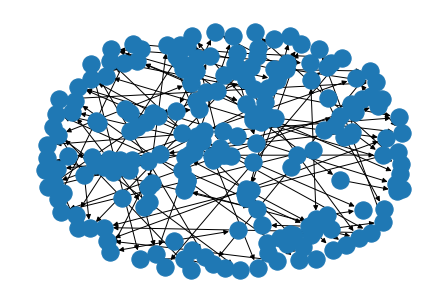

DiGraph with 741326 nodes and 741325 edges DiGraph with 214 nodes and 215 edges 1
<class 'scipy.sparse._csr.csr_matrix'>   (0, 2)	1
  (4, 16)	1
  (5, 6)	1
  (6, 7)	1
  (6, 82)	1
  (7, 70)	1
  (9, 24)	1
  (10, 11)	1
  (10, 160)	1
  (12, 13)	1
  (14, 15)	1
  (15, 14)	1
  (15, 17)	1
  (17, 18)	1
  (17, 124)	1
  (19, 10)	1
  (20, 21)	1
  (20, 114)	1
  (21, 22)	1
  (21, 134)	1
  (22, 92)	1
  (24, 25)	1
  (24, 53)	1
  (26, 27)	1
  (26, 81)	1
  :	:
  (194, 195)	1
  (195, 4)	1
  (196, 155)	1
  (197, 23)	1
  (197, 200)	1
  (199, 189)	1
  (199, 201)	1
  (202, 55)	1
  (202, 203)	1
  (203, 58)	1
  (203, 207)	1
  (204, 200)	1
  (204, 208)	1
  (205, 198)	1
  (205, 206)	1
  (207, 184)	1
  (209, 169)	1
  (209, 210)	1
  (210, 8)	1
  (210, 211)	1
  (211, 5)	1
  (212, 3)	1
  (212, 11)	1
  (213, 1)	1
  (213, 18)	1


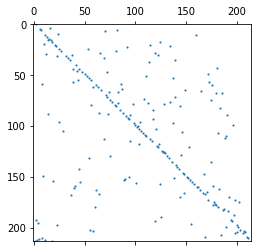

In [110]:
c1 = 991 
c2 = 750
col1 = submat[: , c1]
col2 = submat[: , c2]
print(col1,col2)
paths,adj = find_paths(col1,col2, verbose = True)
print((type(adj)), adj)

plt.spy(adj , markersize = 1)
plt.show()

In [111]:
print(structmats)

{'7DZW': {'C': (<COO: shape=(741326, 1121, 1), dtype=float64, nnz=10606, fill_value=0.0>, <COO: shape=(741326, 1121, 3, 1), dtype=float64, nnz=17633, fill_value=0.0>), 'B': (<COO: shape=(741326, 1121, 1), dtype=float64, nnz=10606, fill_value=0.0>, <COO: shape=(741326, 1121, 3, 1), dtype=float64, nnz=17633, fill_value=0.0>), 'A': (<COO: shape=(741326, 1121, 1), dtype=float64, nnz=10606, fill_value=0.0>, <COO: shape=(741326, 1121, 3, 1), dtype=float64, nnz=17633, fill_value=0.0>)}}


In [112]:
print(pairs[0].shape,pairs[1].shape)

(5168,) (5168,)


In [113]:
template_features = sparse.COO(template_features)
sampleGEN = create_data_updown_transitions_single( pairs, structmats['7DZW']['C'][0] , structmats['7DZW']['C'][1] ,template_features , allcols, posi_percent = .5 , nsamples = 10 , min_nodes = 10,  q = None , iolock= None,  verbose = False, loop= True , sectors_chunk = True )

In [114]:
print( next( sampleGEN ))

HeteroData(
  phylonodes_up={
    x=[167, 23],
    y=[167, 1]
  },
  phylonodes_down={
    x=[167, 23],
    y=[167, 1]
  },
  sectornode={
    x=[1, 1],
    y=[1, 1]
  },
  (phylonodes_up, phylolink_up, phylonodes_up)={ edge_index=[2, 334] },
  (phylonodes_down, phylolink_down, phylonodes_down)={ edge_index=[2, 334] },
  (phylonodes_up, phylolink_up_down, phylonodes_down)={ edge_index=[2, 167] },
  (phylonodes_down, phylolink_down_up, phylonodes_up)={ edge_index=[2, 167] },
  (phylonodes_down, informs, sectornode)={ edge_index=[2, 167] },
  (phylonodes_up, informs, sectornode)={ edge_index=[2, 167] },
  (sectornode, informs, phylonodes_down)={ edge_index=[2, 167] },
  (sectornode, informs, phylonodes_up)={ edge_index=[2, 167] }
)


In [115]:
reload = True
ntrain = 1000
ntest = 500

In [116]:
trainset = './trainset.pkl'

if reload == True:
    with open( trainset , 'rb' ) as datain:
        train = pickle.loads( datain.read())
else:
    train = []
    
testset = './testset.pkl'
if reload == True:
    with open( testset , 'rb' ) as datain:
        test = pickle.loads( datain.read())
else:
    test = []

In [117]:
print(len(train), len(test))

1000 1000


In [118]:
for i in range(ntrain):
    train.append(next( sampleGEN ))

/tmp/9922925/ipykernel_59001/546877012.py:97: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  while col1 == col2 and (col1,col2) not in pairs:


In [119]:
with open( trainset , 'wb' ) as datain:
    datain.write( pickle.dumps( train ) )

In [235]:
for i in range(ntrain):
    test.append(next( sampleGEN ))

/tmp/9850443/ipykernel_5481/2804683713.py:102: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  while col1 == col2 and (col1,col2) not in pairs:


In [236]:
with open( testset , 'wb' ) as datain:
    datain.write( pickle.dumps( test ) )
    

In [237]:
with open( trainset , 'rb' ) as datain:
    train = pickle.loads( datain.read())

In [120]:
print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)

6677.75390625


In [121]:
print(structmats)

{'7DZW': {'C': (<COO: shape=(741326, 1121, 1), dtype=float64, nnz=10606, fill_value=0.0>, <COO: shape=(741326, 1121, 3, 1), dtype=float64, nnz=17633, fill_value=0.0>), 'B': (<COO: shape=(741326, 1121, 1), dtype=float64, nnz=10606, fill_value=0.0>, <COO: shape=(741326, 1121, 3, 1), dtype=float64, nnz=17633, fill_value=0.0>), 'A': (<COO: shape=(741326, 1121, 1), dtype=float64, nnz=10606, fill_value=0.0>, <COO: shape=(741326, 1121, 3, 1), dtype=float64, nnz=17633, fill_value=0.0>)}}


In [122]:
print(subthresh_connected['7DZW'])

{'C': array([[28., 19., 19., ...,  0.,  0.,  0.],
       [19., 34., 31., ...,  0.,  0.,  0.],
       [19., 31., 39., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 19., 18., 16.],
       [ 0.,  0.,  0., ..., 18., 20., 16.],
       [ 0.,  0.,  0., ..., 16., 16., 17.]], dtype=float32), ('A', 'B'): array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), ('A', 'C'): array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  9.,  8.,  7.],
       [ 0.,  0.,  0., ...,  8., 10.,  9.],
       [ 0.,  0.,  0., ...,  7.,  9., 11.]], dtype=float32)}


In [178]:
from torch_geometric.nn import HeteroConv , SAGEConv, Linear , ResGatedGraphConv , GATv2Conv , TransformerConv , MFConv , FiLMConv 
import torch_geometric.transforms as T
#"sum", "mean", "min", "max"
#without sectornode
class HeteroGCN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers):
        super().__init__()
        
        self.convs = torch.nn.ModuleList()
        self.lins =  torch.nn.ModuleList()
        self.lins2 =  torch.nn.ModuleList()
        
        for i in range(num_layers):
            conv = HeteroConv({
                ('phylonodes_up', 'phylolink_up', 'phylonodes_up'):TransformerConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_down', 'phylolink_down', 'phylonodes_down'):TransformerConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_down', 'phylolink_down_up', 'phylonodes_up'):TransformerConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_up', 'phylolink_up_down', 'phylonodes_down'):TransformerConv((-1,-1),  int( hidden_channels) ), 
                ('phylonodes_down', 'informs', 'sectornode'):TransformerConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_up', 'informs', 'sectornode'):TransformerConv((-1,-1),  int( hidden_channels) ),
                ('sectornode', 'informs', 'phylonodes_down'):TransformerConv((-1,-1),  int( hidden_channels) ),
                ('sectornode', 'informs', 'phylonodes_up'):TransformerConv((-1,-1),  int( hidden_channels) ),
            } , aggr='sum')
            self.convs.append(conv)
            for vectype in  ['phylonodes_up', 'phylonodes_down' , 'sectornode'  ]:
                lin1 = Linear(-1 , int( hidden_channels))
                self.lins.append( lin1 )
                
            print( 'hidden units' , int( hidden_channels) )
            print( 'layer' , i )

        for vectype in ['phylonodes_up', 'phylonodes_down' , 'sectornode' ]:
            lin2 = Linear(-1 , out_channels)
            self.lins2.append( lin2 ) 

    
    def forward(self, x_dict, edge_index_dict):
        lins = iter(self.lins)
        for i,conv in enumerate(self.convs):
            x_dict = conv(x_dict , edge_index_dict)
            x_dict = {key:( F.dropout(x , p = .1 , training = self.training ) if 'phylo' in key else x ) for key, x in x_dict.items()}
            for key, x in x_dict.items():
                x_dict[key] = next(lins)(x)
        lins2 = iter(self.lins2)
        for key, x in x_dict.items():
            x_dict[key] =  next(lins2)(x)
        return {key: F.tanh(x) for key, x in x_dict.items()}
        #return x_dict
model = HeteroGCN(hidden_channels= 40 , out_channels=1, num_layers=5 )
model = model.double()
model = model.to(device)

hidden units 40
layer 0
hidden units 40
layer 1
hidden units 40
layer 2
hidden units 40
layer 3
hidden units 40
layer 4


In [179]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.000001)
with torch.no_grad():  # Initialize lazy modules.
    data =next( sampleGEN )
    data = data.to(device)
    out = model(data.x_dict , data.edge_index_dict)

/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
import warnings
from torch_geometric.loader import DataLoader
lastauc = 0
epochs = 1000
#iterate over structs
model = model.to(device)
calc_metrics_overds = True
def calc_metrics(truths,preds,label = ''):
    truth = np.hstack(truths).ravel()
    predy = np.hstack(preds).ravel()
    fpr, tpr, _ = roc_curve(  truth  ,predy )
    auc_s = auc(fpr, tpr)
    print(label,auc_s)

loader = DataLoader(train, batch_size  = 20 )
testloader = DataLoader(test, batch_size  = 20 )

print('done init')
truths = []
preds = []
truths_n = []
preds_n = []
losses1 =[]
losses2 = []
losses3 = []

count = 0
for e in range(epochs):
    for k,data in enumerate(loader):
        count += 1
        if count % 100 == 0 :
            print('losses', np.mean(losses1), np.mean(losses2), np.mean(losses3) )
            losses1 = []
            losses2 = []
            losses3 = []
            if calc_metrics_overds == True and count > 0 and count%200 == 0:
                print('metrics')
                model.eval()
                truths = []
                preds = []
                truths_n = []
                preds_n = []
                for testdata in testloader:
                    testdata = testdata.to(device)
                    pred = model(testdata.x_dict ,testdata.edge_index_dict)
                    truth = testdata['sectornode']['y'][:,0].to('cpu').detach().numpy()
                    predy =  pred['sectornode'][:,0].to('cpu').detach().numpy()
                    truths.append(truth)
                    preds.append(predy)

                    truth_n = testdata['phylonodes_down']['y'][:,0].to('cpu').detach().numpy()
                    pred_n =  pred['phylonodes_down'][:,0].to('cpu').detach().numpy()
                    truths_n.append(truth_n)
                    preds_n.append(pred_n)
                calc_metrics(truths,preds,label = 'sectornode')
                calc_metrics(truths_n,preds_n,label = 'phylonodes')   
        data = data.to(device)            
        out = model(data.x_dict ,data.edge_index_dict)
        optimizer.zero_grad()
        loss1 =  F.mse_loss(out['phylonodes_up'], data['phylonodes_up'].y.double())
        loss2 =  F.mse_loss(out['phylonodes_down'], data['phylonodes_down'].y.double())
        loss3 =  F.mse_loss(out['sectornode'], data['sectornode'].y.double())
        loss = loss3 + loss1 + loss2
        loss.backward()
        optimizer.step()
        losses3.append(float(loss3.to('cpu')))
        losses2.append(float(loss2.to('cpu')))
        losses1.append(float(loss1.to('cpu')))
    

done init
losses 0.2684325319789044 0.259515739520235 0.25805411124840827
losses 0.25427169569357644 0.25185389398857044 0.249942261832177
metrics
sectornode 0.6330202126978026
phylonodes 0.5465970187846652


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.24888581362804507 0.24858184092163743 0.24981629134150424
losses 0.2487711527861172 0.248516731256896 0.2497496375301222
metrics
sectornode 0.6382936126593632
phylonodes 0.567914790875955


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.24865897747295768 0.24844098226351372 0.24965140403260622
losses 0.24853091568452026 0.2483502444787512 0.24953116518997107
metrics
sectornode 0.6490005765904286
phylonodes 0.5995413974691941


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.24822080473579727 0.24813295333909768 0.2493133356698505
losses 0.2198208710355663 0.2209915440911933 0.22684439706797338
metrics
sectornode 0.714747901851496
phylonodes 0.7272384404522966


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.20673329810423835 0.20664324426115727 0.21413708381396557
losses 0.2054097085451947 0.2053081413948828 0.21306970977297404
metrics
sectornode 0.6932679063360881
phylonodes 0.7326574523281456


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.2045828108983577 0.20445963958405244 0.21241436391867544
losses 0.2039715322668192 0.20383901506243807 0.2118989920578239
metrics
sectornode 0.6953760650906528
phylonodes 0.7352513502313889


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.2034746271705059 0.2033379074457473 0.2114565753853341
losses 0.20304631488991315 0.20290758075331067 0.21106028227449275
metrics
sectornode 0.7024052629893011
phylonodes 0.7359459335611779


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.20266125336175225 0.20252138399943956 0.21069349652118086
losses 0.20230247306365798 0.20216173349062938 0.21034376139884156
metrics
sectornode 0.7136567845473767
phylonodes 0.7365856108527297


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.20195617465599472 0.20181438246282166 0.21000010106625466
losses 0.20161077584780884 0.20146681124108107 0.20965176011796388
metrics
sectornode 0.7244918796847972
phylonodes 0.7370086204434472


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.2012583603983652 0.20110960651437307 0.2092873906539453
losses 0.20087186469434312 0.20071331334056236 0.20888263838333787
metrics
sectornode 0.7316051636876162
phylonodes 0.7380334424078286


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.2001892505571664 0.19999424876566643 0.20833453494020795
losses 0.19869128005849682 0.19846421682543966 0.20735042722629926
metrics
sectornode 0.7360877538599525
phylonodes 0.746483874153685


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.19749892541384045 0.19717235863323293 0.20568049432460703
losses 0.1966529725586965 0.19627744468362887 0.20466360718188203
metrics
sectornode 0.7483803414696649
phylonodes 0.7530987673115668


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.19566938495465966 0.19534824151969693 0.20378573096741334
losses 0.19457423346172054 0.19429401685519315 0.20291208660361143
metrics
sectornode 0.7505205330258184
phylonodes 0.7616422318486749


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.1936993578293132 0.19343422166389676 0.2018151531869094
losses 0.19300638973908832 0.19276910299629185 0.2005644999166616
metrics
sectornode 0.7537938849381767
phylonodes 0.7668841851784667


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.19253032361831482 0.19230811597662306 0.19980939344893564
losses 0.19209008503612865 0.19187846823228752 0.19911924308386073
metrics
sectornode 0.756828992888718
phylonodes 0.7688999023393451


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.19163323859069042 0.19142998289490934 0.19841669730032366
losses 0.19114534419606458 0.19094840403067742 0.19770070598304718
metrics
sectornode 0.7592795022102632
phylonodes 0.7690536996050519


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.19057261764392142 0.1903780261047531 0.19675012464342778
losses 0.19032620283317556 0.19011795089688807 0.19223160352618643
metrics
sectornode 0.7709774809404831
phylonodes 0.770019546844433


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.18985211446529174 0.18960909800867592 0.19039447008657895
losses 0.18934581575857914 0.18908457798813225 0.18910191335490573
metrics
sectornode 0.7698643410852712
phylonodes 0.7719169152501764


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.18875037340663808 0.1884842293037648 0.18801286507206963
losses 0.18795851649264703 0.18770502551141083 0.1863642489800294
metrics
sectornode 0.770685181625985
phylonodes 0.7769485749230796


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.1861186043757882 0.18590783212989212 0.18488059235639795
losses 0.18340276699810915 0.18313179206883518 0.18415584825264586
metrics
sectornode 0.7755381510666923
phylonodes 0.7793821436539874


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.18142601729632307 0.18113391595921602 0.1826648448748179
losses 0.1797341515310547 0.17945512934612368 0.18115099129765475
metrics
sectornode 0.7822710455506441
phylonodes 0.7830263603539526


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.1780028232718828 0.17774930140956813 0.18008552448843682
losses 0.17614313254449496 0.17591139087395422 0.17868551590645945
metrics
sectornode 0.7791158145941445
phylonodes 0.7879071371410586


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.17434460006339317 0.17414402717397146 0.17724260293023486
losses 0.17283345289387356 0.17262867491975517 0.1781739247437083
metrics
sectornode 0.7816383977192645
phylonodes 0.789072098307706


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.17114858910530428 0.170973599007373 0.17489391803567148
losses 0.17011884049966366 0.16997725228218966 0.17383466388921373
metrics
sectornode 0.7843311551028253
phylonodes 0.7886949398820003


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.16926607706677999 0.16913657931159856 0.1736400223315232
losses 0.16840079957146753 0.16827825225776835 0.17300538032905732
metrics
sectornode 0.7887216509705939
phylonodes 0.7919260761495575


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.16711611019736797 0.16696035266445505 0.17201933205857242
losses 0.16619101200656533 0.16605484945084206 0.17140120632707412
metrics
sectornode 0.7954405311038504
phylonodes 0.7929421240503521


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.16592668249143153 0.16577025529278785 0.1711669949909195
losses 0.16466462170814353 0.16438848047018173 0.17033715678940464
metrics
sectornode 0.790627602665129
phylonodes 0.7993927933500008


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.16326192418804328 0.1628831684189956 0.1680933116445675
losses 0.16195502706801368 0.16149700161710398 0.16789086657602095
metrics
sectornode 0.793924979178679
phylonodes 0.8069923858632677


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.1609963246008863 0.16063007527514142 0.16758519693249782
losses 0.16033263471362716 0.16014358825053454 0.1671781264511875
metrics
sectornode 0.7886715997181114
phylonodes 0.8051054214382103


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.15939357294010123 0.15927214634660566 0.1667955160281251
losses 0.15881501682369545 0.15874321348512443 0.16652484298277806
metrics
sectornode 0.790507479659171
phylonodes 0.8110178091911082


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.15814247074992824 0.1580616881497187 0.16557947893092415
losses 0.15647950174731093 0.15632603539153123 0.16476487664671371
metrics
sectornode 0.795246332244218
phylonodes 0.8146030312067252


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.15673657397595642 0.1566688867484326 0.16478824751494414
losses 0.15864825214097616 0.15857523061126608 0.16790284213523868
metrics
sectornode 0.7950721538855788
phylonodes 0.8137311747022358


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.15580789550471505 0.15566909422354433 0.164332182306174
losses 0.15507352181654546 0.15500272455408673 0.16374116121890425
metrics
sectornode 0.8028080754692805
phylonodes 0.817404801619196


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.15480741765207173 0.15473598807066863 0.16381372512944936
losses 0.1542444226995371 0.1541666601841395 0.16335480654652554
metrics
sectornode 0.8061414888846179
phylonodes 0.8166454953773222


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.1538163412612862 0.153736776462385 0.16306100569658055
losses 0.1533395214233563 0.15323376850813974 0.1626193600539806
metrics
sectornode 0.8082976968415657
phylonodes 0.8194847556295184


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.15327563385236279 0.15318348997499934 0.1632797694038293
losses 0.1521368796207446 0.15203609209133523 0.16278000210518115
metrics
sectornode 0.8112967678903198
phylonodes 0.8230167756493382


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.1517621630954645 0.15163670584559288 0.16160934690571507
losses 0.15000294002188463 0.14992253635130084 0.1599305079196135
metrics
sectornode 0.8132888077391248
phylonodes 0.8207128894972304


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.14888357662091395 0.1487825043685288 0.15889420344931418
losses 0.14749097728876864 0.14744089123716686 0.15873607163079023
metrics
sectornode 0.8020312800307516
phylonodes 0.8183315884151563


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.1462839117369661 0.14622308693187366 0.1576174088138574
losses 0.14639604810237083 0.14632510793076875 0.15758253570550462
metrics
sectornode 0.8120034915753731
phylonodes 0.8239253303821876


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.14566504032092759 0.14563331670980792 0.1579474964349863
losses 0.1463437450289929 0.14630867893709332 0.15877204100695672
metrics
sectornode 0.8246424338522647
phylonodes 0.8300797511072706


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.14447550264067957 0.14435447862746995 0.15618253940625654
losses 0.14331908015889241 0.14322886092953296 0.15598603072485287
metrics
sectornode 0.8226764206547504
phylonodes 0.8336843516272933


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.14257298270777852 0.14245159875423619 0.15455291192641493
losses 0.1413999642625607 0.1413174510386071 0.15341589646876158
metrics
sectornode 0.8228485969632904
phylonodes 0.835452607923908


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.14076719984611047 0.1406740203827894 0.1521806611738502
losses 0.13993334144780817 0.1398312541486467 0.15109999437591
metrics
sectornode 0.8251169197257991
phylonodes 0.8372506057364273


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.14103131353875317 0.140987591266414 0.15202401100643864
losses 0.13855350060145974 0.1384865964674491 0.15037161142818942
metrics
sectornode 0.8245943846498814
phylonodes 0.8383106185125662


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.13786691117932454 0.13773433395162576 0.14948644699064098
losses 0.1372597603779755 0.13717205442630917 0.14873626439868753
metrics
sectornode 0.8333373374335319
phylonodes 0.8431013053041381


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.13700246989284762 0.13687885758040202 0.149116590193505
losses 0.13599189266793732 0.13590708149074726 0.14790416673308707
metrics
sectornode 0.8323923697866615
phylonodes 0.8439143473755728


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.13565289345604778 0.1355373197256858 0.1479956422485488
losses 0.13448509275734655 0.13438390497073438 0.14738799285599252
metrics
sectornode 0.8325985809468897
phylonodes 0.8476485444128398


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.134554320117001 0.13448576321559133 0.14633457095734748
losses 0.133873242080891 0.13383607191774463 0.14574383521895917
metrics
sectornode 0.835946008712922
phylonodes 0.8470823041269984


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.13369857818433808 0.13362660622642625 0.14626319907573515
losses 0.13457679188363034 0.13449124585756692 0.14658690946089076
metrics
sectornode 0.8380581715676854
phylonodes 0.8490713463681703


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.13368872081535163 0.13359165750717308 0.14629368914386004
losses 0.1321390801028369 0.13209981389866027 0.14449869193477524
metrics
sectornode 0.840857037606509
phylonodes 0.8544756033881609


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.13275575077704604 0.13266833499497127 0.14500311313216005
losses 0.13158130937159754 0.13155529167944216 0.1441954785696365
metrics
sectornode 0.8385586840925108
phylonodes 0.8521645497555123


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.13279065876918683 0.13269355266658048 0.14555511045409658
losses 0.13076005516776 0.13067662005439437 0.14433548642730062
metrics
sectornode 0.8425247453392275
phylonodes 0.8589995645662143


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.13130541303801602 0.13124746147486288 0.1436752502152983
losses 0.13040659679987626 0.130367779349294 0.14312297024908788
metrics
sectornode 0.8455978922416555
phylonodes 0.8589456087767632


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.12975353963241623 0.12969625704856688 0.1424895513310715
losses 0.12978611228025472 0.1296995407398336 0.14199747295932938
metrics
sectornode 0.8454056954321225
phylonodes 0.8572855174114546


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.13044039123655046 0.13037529627571287 0.1426408024623073
losses 0.1279966290342455 0.12795772213953552 0.140612928173362
metrics
sectornode 0.8486330001921967
phylonodes 0.8638482122398425


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.12782310759774212 0.12776906601734755 0.14017752134651762
losses 0.1282112135722427 0.128165197759285 0.14073925662594372
metrics
sectornode 0.8506170318406047
phylonodes 0.8640978125492107


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.12858674701502376 0.12851168197635165 0.1397642575760678
losses 0.12896481963750842 0.12891489696882125 0.14140941526967224
metrics
sectornode 0.8479923441604201
phylonodes 0.8606187636270501


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.127961497665489 0.12788931461956243 0.14037412276230665
losses 0.12785762890326324 0.12774734704905494 0.13848994349721155
metrics
sectornode 0.854142642065475
phylonodes 0.8645148567504952


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.12691327696519486 0.12680890278946128 0.13780383381959938
losses 0.12631326152235497 0.12624446151758423 0.1345323326305673
metrics
sectornode 0.8577843711961046
phylonodes 0.8647144157318214


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.1258661890519146 0.12578739144452025 0.13378846279960283
losses 0.12660740307993124 0.12642389631956272 0.13380785782409813
metrics
sectornode 0.8596542859888527
phylonodes 0.8659279065816776


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.12388208487241609 0.12382059923462899 0.1321826774172842
losses 0.12262087832191292 0.12256991763602913 0.12871631546261342
metrics
sectornode 0.861860545198283
phylonodes 0.8673893246223201


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.1230730467678778 0.122991109463411 0.12903182417352985
losses 0.12264896893931063 0.12261019585640201 0.12821561305826623
metrics
sectornode 0.8613600326734576
phylonodes 0.8651330083714206


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.12264840442474588 0.12258287837183697 0.1283262306919553
losses 0.12200585931372401 0.12194480669075684 0.12760660283521374
metrics
sectornode 0.8656043788839771
phylonodes 0.8701833315182298


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.12153491030223038 0.1214585734231533 0.1255871380986483
losses 0.12239343703550276 0.1223338960615628 0.12700979787942676
metrics
sectornode 0.8659267089499648
phylonodes 0.8719823219012308


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.12144437307876106 0.12134083538269659 0.1248073084126112
losses 0.1205601366213771 0.12047518988866714 0.12530143515293465
metrics
sectornode 0.8685594048305465
phylonodes 0.8721692774999363


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.12113053728800693 0.12101722377325379 0.12438265352297
losses 0.12008277973327512 0.1199802204056216 0.12316425199782131
metrics
sectornode 0.871178086360433
phylonodes 0.8762697465306486


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.12346012269923942 0.12336578333993124 0.1260585387525723
losses 0.12192012948207327 0.12179745532906079 0.12615371413093596
metrics
sectornode 0.8727036485361009
phylonodes 0.8779807173065035


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.12001790007154689 0.11989340375441537 0.12234089956996685
losses 0.12192860860734304 0.12180059687891046 0.1254076709152685
metrics
sectornode 0.8731501057082451
phylonodes 0.8768237529706868


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.12018454331987245 0.12008968793243488 0.12121205137465328
losses 0.11941031839071962 0.11929623564461796 0.12109633463795932
metrics
sectornode 0.8741271061567044
phylonodes 0.8747448820307305


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11918072493014017 0.11905753642628014 0.11916551487897309
losses 0.11777858266835821 0.11767611301623444 0.1177681933246701
metrics
sectornode 0.8771021526042666
phylonodes 0.8787434840528068


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11786645701267721 0.1177546851999907 0.11815126774915129
losses 0.11769813273749781 0.11759018757949624 0.1178966136626732
metrics
sectornode 0.8786837721827151
phylonodes 0.8805019828940266


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11805618204043306 0.11793823840154749 0.11796195394732906
losses 0.11687657339183832 0.116774933471797 0.11652529337438049
metrics
sectornode 0.8817569190851432
phylonodes 0.8814971948772313


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.1171496615915043 0.11706385529001885 0.11629085269257972
losses 0.11840572563339993 0.11835466747187509 0.1180877028596115
metrics
sectornode 0.8791422416554551
phylonodes 0.8752034328773308


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11755484395973818 0.11743855723180124 0.11680159063045092
losses 0.11700240309262488 0.11685919266895944 0.11554493328327375
metrics
sectornode 0.8824596386699981
phylonodes 0.8770944883777619


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11716169575561526 0.11716304887585485 0.11603655048914048
losses 0.116770600523502 0.11668065179473758 0.11636006413774355
metrics
sectornode 0.8857089659811647
phylonodes 0.8826761177126339


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11487152479601458 0.11485653706389785 0.11330051594358079
losses 0.11771170422827378 0.11754042372103944 0.11798283513267789
metrics
sectornode 0.8850743160996861
phylonodes 0.8843023020724383


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11548486530765696 0.11541352272761018 0.11380570327492949
losses 0.11595297906399896 0.11586748588804298 0.11668081306459505
metrics
sectornode 0.8826538375296304
phylonodes 0.8822758022153826


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11491514229311585 0.11484075979457282 0.11374725497053932
losses 0.11534408184949341 0.11522892596381724 0.11368453952417928
metrics
sectornode 0.8852985457108079
phylonodes 0.8844920170772237


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11471261046022783 0.11460874899455399 0.11324429848497335
losses 0.11508844875254519 0.11495573366314826 0.11247699147212474
metrics
sectornode 0.8865638413735666
phylonodes 0.8833322792587344


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11505917429379707 0.11495926202054094 0.11191077547742691
losses 0.1148250164267239 0.11470828215596886 0.11141428089850235
metrics
sectornode 0.8895689185726185
phylonodes 0.8826748782240115


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11400693542371643 0.11396965490406283 0.10995599140280314
losses 0.11358846106494624 0.113510797727746 0.11112741196027859
metrics
sectornode 0.8909283105900442
phylonodes 0.8864844693729478


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.1138966771235344 0.11378368194043302 0.110145973111331
losses 0.11394705559274382 0.11388111929188996 0.11030547993324644
metrics
sectornode 0.8908582388365686
phylonodes 0.8864231476124955


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11261665490424091 0.11254028602870093 0.11057243857960371
losses 0.11169611677009592 0.11171449634713015 0.10928948428471001
metrics
sectornode 0.8876129156256006
phylonodes 0.8846439631922195


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11419951752481201 0.11410912180548044 0.11073005258696708
losses 0.11342625380581749 0.11334765655314152 0.11105872985127827
metrics
sectornode 0.8930144467935165
phylonodes 0.884603566562389


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11347371900780122 0.11343859948185425 0.1090570426772394
losses 0.1112158117730463 0.11117007536349197 0.10702026201939466
metrics
sectornode 0.8911325197001729
phylonodes 0.8873945397162375


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11167146548191359 0.11162679020348662 0.10924389373790723
losses 0.11190562467293433 0.11182811315513007 0.10870919282326191
metrics
sectornode 0.8924798994170031
phylonodes 0.8885659240898554


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11202241486308293 0.1119392458107828 0.10696766835186987
losses 0.11428868198639233 0.11423034330957145 0.11078639908570845
metrics
sectornode 0.8939474021397912
phylonodes 0.8876800646585379


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11151823156773964 0.11146056208608054 0.10682915393054766
losses 0.11136551236986934 0.11128226910938667 0.10802918770047754
metrics
sectornode 0.8955490422192325
phylonodes 0.8900914984859936


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11084965839710936 0.11074380766161056 0.1062425150808341
losses 0.11072859548478338 0.11066537993044868 0.10543313321001355
metrics
sectornode 0.8948443205842783
phylonodes 0.8880346805373771


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.11122236237312752 0.11113021750862599 0.10610307223481205
losses 0.11171058107445138 0.11164541111173965 0.10677269910326027
metrics
sectornode 0.8980055576910756
phylonodes 0.8903908995870018


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10995282227575226 0.10984856286196365 0.10536672818285629
losses 0.11076681878255355 0.11068755722487497 0.10555026946350839
metrics
sectornode 0.8959834870907809
phylonodes 0.8870167210169269


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10985687790822535 0.10977630864088665 0.10401853487139101
losses 0.10950615913178303 0.10942817522334096 0.1033127549117848
metrics
sectornode 0.8954889807162535
phylonodes 0.8885984725072085


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10972784394139763 0.10965261286987288 0.10558675513893849
losses 0.10819193934858524 0.10811246874896538 0.10402627179146878
metrics
sectornode 0.8955890832212184
phylonodes 0.8946767764609246


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10850853226378755 0.10839416095337462 0.10445088758001674
losses 0.10917583540492302 0.10907657340182238 0.10461642146522486
metrics
sectornode 0.8993389230572104
phylonodes 0.8944942002451177


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10770126671182227 0.1076105085445761 0.10300482480374233
losses 0.10864894572355809 0.10857396306514426 0.10360788290723169
metrics
sectornode 0.8981957524505093
phylonodes 0.8962270962593561


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.1075605736928066 0.10748509083595545 0.10289413695721272
losses 0.11304892834163593 0.11299821037544425 0.10681196357215848
metrics
sectornode 0.9009045262348645
phylonodes 0.8930856084392902


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10803444716382654 0.10793814844742189 0.1020323724978783
losses 0.10822672663186025 0.10817735177191316 0.1023771843530773
metrics
sectornode 0.8987022711256326
phylonodes 0.8982158031966181


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.1075546135508559 0.1074527767015146 0.10148527701245787
losses 0.10754709464170763 0.10745653562273853 0.10116518638821988
metrics
sectornode 0.8988764494842719
phylonodes 0.8974369385798491


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.1069428850810691 0.10685784130612727 0.10141631416375105
losses 0.10816374522964088 0.10811858229808566 0.1014248844742987
metrics
sectornode 0.8985701358190787
phylonodes 0.8958341977607541


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10730544441262899 0.10720825963948333 0.10102409180324477
losses 0.10657704492626624 0.10645293545177172 0.10030486839099405
metrics
sectornode 0.89954113011724
phylonodes 0.8984298811326971


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10554470312592913 0.10544378233968113 0.09978772278209946
losses 0.10583958474582693 0.10577551219510889 0.1006048516854168
metrics
sectornode 0.9021097603946441
phylonodes 0.8998450757533623


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10667456216364497 0.10660637518026603 0.09901097326251426
losses 0.1060136914381542 0.10590285158747996 0.09977317819315563
metrics
sectornode 0.8982277852520981
phylonodes 0.898054565585078


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10697514480449383 0.10691352466776277 0.1018056931229924
losses 0.10566083751189378 0.10555145016694895 0.09996044982643879
metrics
sectornode 0.9002858927541803
phylonodes 0.8973166959977663


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10514792725886203 0.1050912220250323 0.10005184547331732
losses 0.10403599625138782 0.10395773550367839 0.09681263784863901
metrics
sectornode 0.906051797040169
phylonodes 0.8998718724907453


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10515748991300308 0.10515478300749617 0.09962466044184959
losses 0.10414160343935261 0.10407244689377088 0.09856152409134873
metrics
sectornode 0.9002438497020949
phylonodes 0.899088289759937


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10304450938535015 0.1029484531172361 0.09761712502110532
losses 0.10314718645890225 0.10305257220800618 0.09639377576280815
metrics
sectornode 0.8980656191940547
phylonodes 0.9002152680253157


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10341829082112985 0.10329356204810841 0.09678587280299186
losses 0.10334584555351756 0.10327200629114504 0.09664387332686988
metrics
sectornode 0.9004320424114293
phylonodes 0.9008550108544363


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10248336997452485 0.10235494019020694 0.09591613719292988
losses 0.1018343313290031 0.1017516101584704 0.09502571269308295
metrics
sectornode 0.8974670062143635
phylonodes 0.8951822006931547


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10222228129478694 0.10214340527352679 0.09611913521934207
losses 0.10231659824556434 0.10220857993551764 0.09685277698176942
metrics
sectornode 0.8966802005253379
phylonodes 0.8964619601752625


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.10125443743898672 0.10122760944884382 0.09562479177962283
losses 0.10131606727547844 0.1012116117983639 0.09631552217201968
metrics
sectornode 0.8980035556409763
phylonodes 0.8987385311984557


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09967569924648725 0.09965097791348071 0.09254109629001026
losses 0.10122465387277042 0.10114247855057475 0.09450583443000245
metrics
sectornode 0.9008885098340702
phylonodes 0.9004715989943958


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09979381064796061 0.09974549676035982 0.0938415274236129
losses 0.10108239919882392 0.10105837940835748 0.09404033504313053
metrics
sectornode 0.8970746043949003
phylonodes 0.9000415181875965


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09981238537263094 0.09974350532480804 0.09376692619041056
losses 0.09892376761934311 0.09890876738605961 0.09239900509973342
metrics
sectornode 0.8959234255878019
phylonodes 0.8987095990209687


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09983843676133318 0.09976133606027764 0.09230777900221822
losses 0.0999359909069152 0.09990849352471803 0.09292726441892908
metrics
sectornode 0.897052581843808
phylonodes 0.8980108060677856


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09970505837164273 0.09965009707572531 0.09242281761917905
losses 0.09915757573587614 0.09908690310873607 0.09261294122402342
metrics
sectornode 0.8997073002754821
phylonodes 0.8982002521860166


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09809263997327507 0.09807016815020024 0.09155070580432403
losses 0.09846191339972118 0.09837522798477435 0.09145740267844438
metrics
sectornode 0.8995251137164456
phylonodes 0.8948053093944293


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09916678400329884 0.09912042453308022 0.09073005248343806
losses 0.09691557930681607 0.09686155531957395 0.08870454637714513
metrics
sectornode 0.9017273688256774
phylonodes 0.8986530510374993


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.0967618749985651 0.09673757925230703 0.08881065244980567
losses 0.0957132245029306 0.09566937183976572 0.08891192719341301
metrics
sectornode 0.9035712569671344
phylonodes 0.9019661548177873


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.0961854511666445 0.0961677073418731 0.08782207374891864
losses 0.09507070409209961 0.09505093403330571 0.08927316158048183
metrics
sectornode 0.9060057498878853
phylonodes 0.9033013677363737


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09500126055252542 0.09499983381101597 0.08688595062777049
losses 0.09507870110836261 0.09503081962932076 0.08793978694214416
metrics
sectornode 0.9059937375872893
phylonodes 0.9044348721175435


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09618749215550229 0.09613108725290717 0.08677848033734246
losses 0.09511302770561787 0.09509261809713385 0.08729543014144793
metrics
sectornode 0.9065422993144979
phylonodes 0.9077367789138785


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09474361650282384 0.09470896255287223 0.08765068937340047
losses 0.09516413754688706 0.09516592733233172 0.08681651308598251
metrics
sectornode 0.9104002498558524
phylonodes 0.9054163878781859


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09465268057933697 0.09462810418890699 0.08736121965742535
losses 0.09522984030997383 0.09523731473677112 0.08733528859386114
metrics
sectornode 0.9057454833749758
phylonodes 0.90595780071831


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09336418306818821 0.09337759593051759 0.08593319205997096
losses 0.09574691929186101 0.09567948023565194 0.08677768540539894
metrics
sectornode 0.9091589787942854
phylonodes 0.9103323820151028


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09585337111674526 0.09581742997209677 0.08864249898864879
losses 0.09502426396930469 0.09502470784624699 0.08768899454834375
metrics
sectornode 0.9025622237170863
phylonodes 0.8994300398957829


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09338835735264593 0.09342990981516142 0.08503354700808076
losses 0.0930975201518888 0.09310478674464236 0.08502554323784571
metrics
sectornode 0.9100138541866872
phylonodes 0.9082340038592105


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09361739694270849 0.09364093155672366 0.08425537054527865
losses 0.09168855859698785 0.09168040769307914 0.08459853928412764
metrics
sectornode 0.905200925747966
phylonodes 0.905666950516998


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.0923403110645089 0.09233961660648665 0.08362147308164629
losses 0.09310760897180101 0.09307695666096079 0.08453820472972323
metrics
sectornode 0.9045322410147991
phylonodes 0.8985319058727043


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09242281835168997 0.09241748825508156 0.08401309008884274
losses 0.09297534721188923 0.09294437416831981 0.08520779878912542
metrics
sectornode 0.9077475334742776
phylonodes 0.9057689356928507


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09270285743314771 0.0926681833816975 0.08599742785600277
losses 0.09109115613714486 0.09110011674205852 0.08360172206231775
metrics
sectornode 0.9137196489204944
phylonodes 0.9074648074979356


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.0933478350095247 0.09338337023340999 0.08498151412366668
losses 0.09249322258469386 0.0924588802670764 0.08609221482257043
metrics
sectornode 0.9039636587865976
phylonodes 0.9033257052194987


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09258153881741275 0.09257199563694768 0.08704643295850228
losses 0.09079026426101637 0.09075950987845789 0.0828546647356104
metrics
sectornode 0.9145344833109104
phylonodes 0.9053524133497214


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.09212012799867346 0.09210279188073298 0.08515167392909331
losses 0.09065640495953853 0.09065020111956933 0.08386888928005481
metrics
sectornode 0.9057955346274585
phylonodes 0.8991007488837462


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08797696981826317 0.08800491508789944 0.07955189913529508
losses 0.09192985567908225 0.09189560416133682 0.08541580703054118
metrics
sectornode 0.9073030783522327
phylonodes 0.9053472703379375


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08926366529477589 0.08924232856121417 0.08313907399640869
losses 0.08888782430218739 0.08887453746465697 0.08217416759096796
metrics
sectornode 0.9145625120123008
phylonodes 0.9060484856468476


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08839187935528622 0.08835567125935512 0.08139355657757098
losses 0.08884032379017757 0.08887397574742034 0.08160717973855725
metrics
sectornode 0.9136936222692037
phylonodes 0.9069240946006201


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08915704118243532 0.08914042389669367 0.08250420795033703
losses 0.08679015372734558 0.08678814618887182 0.07987984004025804
metrics
sectornode 0.9145084566596194
phylonodes 0.9100697067572625


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.0877439892693914 0.08774179566271209 0.0801617621327777
losses 0.08756799947544128 0.08754291431217162 0.08021969495494811
metrics
sectornode 0.915341309500929
phylonodes 0.9077504907231155


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08775158307972142 0.08775139071843441 0.07951092963904842
losses 0.0864087860846553 0.08639792765018889 0.0791020155591825
metrics
sectornode 0.9173213370491384
phylonodes 0.9103062516310472


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.0862925513530108 0.08629741213999748 0.07818769802797922
losses 0.08699209462756395 0.08693354152080786 0.07926457566325676
metrics
sectornode 0.9146606124671665
phylonodes 0.9105012723425622


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08551435108098503 0.08547500610040655 0.07846652788725124
losses 0.08614287303516352 0.08613024160559232 0.07909584632955957
metrics
sectornode 0.9167067076686527
phylonodes 0.91331823351254


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08795594213930245 0.08797984254183577 0.08187012571872693
losses 0.0881491090113119 0.08811802926217163 0.08193366845260786
metrics
sectornode 0.9121280190915498
phylonodes 0.9121397369799156


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08526419799323103 0.08527313880325126 0.07882322206510979
losses 0.08479139088500849 0.08475788298155994 0.07736384889551705
metrics
sectornode 0.9183864277019667
phylonodes 0.9137091152897636


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08599038825445199 0.08601494525705602 0.07828560578694896
losses 0.08515587039816981 0.0851485260168612 0.07741895168648388
metrics
sectornode 0.9169549618809661
phylonodes 0.9112561232509668


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.0860438743227119 0.08598172772887061 0.07875590727903249
losses 0.08487735711452499 0.08489298968354668 0.07765907622285197
metrics
sectornode 0.9162962873982959
phylonodes 0.9147774497745098


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08608062804215161 0.08604847946454885 0.0815564500460256
losses 0.08450542297152419 0.08449672823011813 0.07642104692559668
metrics
sectornode 0.9182442821449163
phylonodes 0.9136124357155913


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08553899880154724 0.08553610436969239 0.0771173216525568
losses 0.08561536831231763 0.08563908063453052 0.07615084647108313
metrics
sectornode 0.9141160548401563
phylonodes 0.9039769157574878


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08629606780293696 0.08628176373769751 0.07890114971513848
losses 0.08252620516254071 0.0825187141287321 0.07404085212485097
metrics
sectornode 0.9187628131206356
phylonodes 0.9177716149705536


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08326170175426242 0.08327589204939435 0.07667726072664363
losses 0.08250410776736006 0.0825053448554902 0.0748092834531516
metrics
sectornode 0.9197578320199884
phylonodes 0.9162242239962963


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.0828529138077851 0.082866913279975 0.07535210590655683
losses 0.08227797909873946 0.08225642864938923 0.07390848965527125
metrics
sectornode 0.9169649721314626
phylonodes 0.9159722230107296


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.0842171605899728 0.08421667866518448 0.07630392712747999
losses 0.08198256639266444 0.0820050307069376 0.07556719932379131
metrics
sectornode 0.9168408450253058
phylonodes 0.9153565803848573


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08271078205881785 0.08269764011178607 0.07515470687973724
losses 0.08056203960328556 0.08056916889361186 0.07247597463598598
metrics
sectornode 0.9177858126721763
phylonodes 0.9137659916438958


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08249855598698007 0.08248334282987567 0.07543258770727296
losses 0.0813789816154549 0.08138872430031363 0.07344131297427374
metrics
sectornode 0.9168208245243128
phylonodes 0.9163963189152071


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08125825592100476 0.08123960354896255 0.07360595463410123
losses 0.08225439630237025 0.08223972316457676 0.07328787550197652
metrics
sectornode 0.915249215196361
phylonodes 0.9130625747795427


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08385222848674553 0.08381966279342738 0.07578920964397763
losses 0.08162908492204826 0.08161236919117196 0.07316692294124526
metrics
sectornode 0.9081279229931449
phylonodes 0.9025993347376348


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08243553006629581 0.08240713059501859 0.07455081466192447
losses 0.08005506128398125 0.08003344450324956 0.071526281568422
metrics
sectornode 0.917909939778333
phylonodes 0.9175478814636711


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.07977916279777272 0.07977368633930308 0.07242039362066083
losses 0.07807247568676062 0.07803324594433722 0.07068489492573503
metrics
sectornode 0.9199700493305145
phylonodes 0.9198741548605367


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08304969414689344 0.08303928080338967 0.0734837226783836
losses 0.08078601640700557 0.0808151941686517 0.07321445972489976
metrics
sectornode 0.9191972579921841
phylonodes 0.915891278979207


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08448130453031702 0.08438503565694588 0.0781738345757291
losses 0.07849926966078008 0.07846690421860891 0.06944898317918877
metrics
sectornode 0.919197257992184
phylonodes 0.9178646461991986


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.07767922564446436 0.07769283582589369 0.06912324756113362
losses 0.0766978644806315 0.0766576039504714 0.06893571835526999
metrics
sectornode 0.9182142513934268
phylonodes 0.9163992903499626


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.0791839556732884 0.07912826591636668 0.07080981291266236
losses 0.07723421343982506 0.07724948245088363 0.06871929144151444
metrics
sectornode 0.9208949964763917
phylonodes 0.918206778083831


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.07749349699376601 0.0774632116645249 0.06974746443368778
losses 0.07786286798909134 0.07783932952369654 0.07026748391524086
metrics
sectornode 0.9173153308988404
phylonodes 0.9149940557195467


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.07566754456347285 0.07564744001057305 0.06782054212948385
losses 0.07618002920797187 0.07621501826556198 0.06802318222682723
metrics
sectornode 0.9177157409187007
phylonodes 0.915955562391708


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.0764717853928787 0.07644517223212748 0.06805356645663645
losses 0.07539897539235954 0.07540203742320283 0.06721493598512134
metrics
sectornode 0.9171892017425843
phylonodes 0.9143590929966234


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.076491911346762 0.07648213854089622 0.06757779233260462
losses 0.0770388889777641 0.07698232979684247 0.06824417458878199
metrics
sectornode 0.9200761579857775
phylonodes 0.9173079159910211


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.07693117952163689 0.07689008338247852 0.06914221754133952
losses 0.07560321615683352 0.07562941754960716 0.06719942622950596
metrics
sectornode 0.915515487859568
phylonodes 0.9132827891645428


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.07518077370187842 0.07509991321288674 0.06699744294204023
losses 0.07614590965752481 0.07607085671756562 0.07066923957817141
metrics
sectornode 0.9188569094753027
phylonodes 0.9179100747250231


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.07592908519452485 0.07590414566728045 0.06813669305894993
losses 0.07499199329056049 0.07495618918892175 0.06824356650431587
metrics
sectornode 0.9152552213466589
phylonodes 0.9148522910253793


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.07471658894767323 0.07469204743447244 0.06609027251324207
losses 0.07434478785073415 0.07432470462174795 0.06704344884081419
metrics
sectornode 0.9203264142481901
phylonodes 0.9187641500506923


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.07410282496038795 0.07411279333741186 0.06710691758083587
losses 0.07456458236137481 0.07455560064135183 0.06658028200357123
metrics
sectornode 0.9209450477288744
phylonodes 0.920646633221391


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.07482308700034383 0.07479849151022558 0.06600708629193151
losses 0.07389701878431496 0.07388051172602553 0.06580450066675912
metrics
sectornode 0.9231933499903902
phylonodes 0.9205108080088977


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.07401566265516049 0.07400182780133621 0.06748713066502462
losses 0.07311759671199879 0.0730911169989209 0.06633433248985053
metrics
sectornode 0.9156175924146326
phylonodes 0.9159555325183424


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.07344697259812329 0.07338685124881829 0.06441295054307573
losses 0.07761485937608 0.07751391887665184 0.06913520330228472
metrics
sectornode 0.9214896053558844
phylonodes 0.9142768481277463


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.07332174830095523 0.07327218498418371 0.06608689294963561
losses 0.07463199579883914 0.07461318641777914 0.06790178553410421
metrics
sectornode 0.9226347780126849
phylonodes 0.9209717034222936


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.07240345779349383 0.0723708652475906 0.06456374486454211
losses 0.07144757333002748 0.07140786148377189 0.06392009009584691
metrics
sectornode 0.917683708117112
phylonodes 0.9151872426659933


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08400444055716755 0.08398308379418915 0.08046090030863827
losses 0.07528906960421247 0.07526281566180335 0.06715397452555402
metrics
sectornode 0.9176877122173106
phylonodes 0.914512210620279


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.07554781652485441 0.07549251390157047 0.06658791866126526
losses 0.07230141310250954 0.07229336825071338 0.06306145076663709
metrics
sectornode 0.9169950028829521
phylonodes 0.9159685446605249


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.07199011444973641 0.07196684293342293 0.06383002056428877
losses 0.07371206770923681 0.07370320832933616 0.06746816111905235
metrics
sectornode 0.9218139374719713
phylonodes 0.9216774139833683


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.07500194397832885 0.07488701770174278 0.0668460446430606
losses 0.07343137050191248 0.0733118706483504 0.06786106218221738
metrics
sectornode 0.9246908834646677
phylonodes 0.9198375436916999


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.0710602017324899 0.07096924429423544 0.06462571209849441
losses 0.06996440893004252 0.06991359243142052 0.0629086827204734
metrics
sectornode 0.9272535075917739
phylonodes 0.9240452709478251


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.07044010643251122 0.07041907497637706 0.06204042522378156
losses 0.07058806024032017 0.07051984602676548 0.06241807978059174
metrics
sectornode 0.9280683419821898
phylonodes 0.9240260356911325


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.0702518867936162 0.07019679758444279 0.06292816290460122
losses 0.06944931395888648 0.06942517315719594 0.06180989684065745
metrics
sectornode 0.9204945864565315
phylonodes 0.9184876613616468


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.0698043368069783 0.06974821854087059 0.062149612136804006
losses 0.07160291929879121 0.071540915955629 0.06559622051450623
metrics
sectornode 0.9162142033442244
phylonodes 0.9123432307759329


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.07400252524637074 0.07391752609731374 0.06614129324274122
losses 0.07222170017434278 0.07217951605398491 0.0645768279320475
metrics
sectornode 0.9238119834710743
phylonodes 0.9137394805221521


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.06950911973609677 0.06945956736824854 0.062186345529494466
losses 0.06941933921624725 0.06936567361239865 0.06207293888009583
metrics
sectornode 0.9308151547184317
phylonodes 0.9225728327341614


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.06886418304420167 0.0688348467747616 0.06134342680707891
losses 0.07181040197063682 0.07181843852954826 0.06540629275754059
metrics
sectornode 0.9102140591966174
phylonodes 0.9120536738353017


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.08152939549750375 0.08132309535637079 0.07191052177610044
losses 0.07261200432630836 0.07248182108507234 0.06532627917435643
metrics
sectornode 0.922310445896598
phylonodes 0.9143522736097321


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.07557423844006242 0.07539755190920226 0.06814550372346696
losses 0.07128422109130769 0.07116061647640523 0.06530913210721796
metrics
sectornode 0.9326990838618746
phylonodes 0.9254128762331802


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.06778653592417107 0.06770475011721885 0.06090839111996002
losses 0.06910747275763558 0.06901873464495008 0.06322612562235408
metrics
sectornode 0.9311334806842206
phylonodes 0.929010802793796


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.06831754825516656 0.06830018636020903 0.060977791493632444
losses 0.06959055277558081 0.06953706756227163 0.06266912740445206
metrics
sectornode 0.924977176628868
phylonodes 0.9239456458860491


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.06839088438662425 0.068320716403179 0.0629790058471394
losses 0.06823682499458812 0.06823278376236075 0.05963610628971285
metrics
sectornode 0.9282004772887437
phylonodes 0.9237648737720435


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.06849707070142642 0.06842392085293685 0.06168120954696673
losses 0.06774939422964868 0.06769613190753597 0.06007579115220587
metrics
sectornode 0.9339463610737394
phylonodes 0.9263703984417728


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.06780856646857608 0.06773127883404027 0.05986376876768843
losses 0.06833627645324013 0.06830852341866557 0.06009718792630705
metrics
sectornode 0.9293796847972323
phylonodes 0.9252006286612023


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.06725164905622952 0.06711803153123673 0.05930347448187494
losses 0.06821330055795082 0.06814382790014452 0.06052746612161645
metrics
sectornode 0.9323807578960854
phylonodes 0.9274874108472779


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.07370739099580435 0.07355376772132179 0.06413047613377433
losses 0.06928850099959906 0.06923614972959809 0.06158652525436954
metrics
sectornode 0.931912278172849
phylonodes 0.927170408227841


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.0693185361572809 0.06931895478871496 0.061250624692025746
losses 0.0695148994521883 0.06949752318521095 0.059796332504140286
metrics
sectornode 0.9275478089563713
phylonodes 0.9280863120450329


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.0673125855469044 0.06729996607286273 0.059942241481658304
losses 0.0675530659710063 0.06743275754978559 0.05761727334532992
metrics
sectornode 0.9256378531616374
phylonodes 0.927722318148503


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.06790277092551328 0.06789254138346772 0.058500005214549615
losses 0.06759867698710387 0.06756423969719702 0.0580677413996679
metrics
sectornode 0.9313497020949452
phylonodes 0.9272675290086465


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.06831779311427963 0.06829251764984237 0.058134522259652696
losses 0.06949585364525103 0.0693710928394724 0.06028186380035792
metrics
sectornode 0.9348392754180281
phylonodes 0.9258947113133807


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.06782109259598595 0.06771485045409516 0.05850657179292458
losses 0.06665912146909518 0.06659585709292255 0.05645344918310073
metrics
sectornode 0.9312896405919662
phylonodes 0.9231291008177842


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.06720322022254506 0.06709501647168915 0.060282010959486494
losses 0.07139869444082796 0.07130933134278877 0.06209595026417708
metrics
sectornode 0.9269812287782687
phylonodes 0.9243900474066324


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.06530976071168969 0.06524251100086785 0.056345231529893944
losses 0.0655003871172062 0.06541019283689274 0.055720162964689894
metrics
sectornode 0.9347171503619707
phylonodes 0.9286834425203694


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.06551590156787215 0.06549190917264382 0.0565297633690787
losses 0.0648343708652705 0.06476723958943359 0.052608787244157726
metrics
sectornode 0.9314257799987187
phylonodes 0.9222889163971041


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.06327671249944856 0.06323784039831627 0.051982400721388614
losses 0.06619917948185966 0.06615933742558526 0.054702675418468356
metrics
sectornode 0.9320163847780127
phylonodes 0.920961366449865


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.06649771785371081 0.06647241968572351 0.05347644295458461
losses 0.06642529112149485 0.0663329931205186 0.055834165023628736
metrics
sectornode 0.9321345057338716
phylonodes 0.9230697088898925


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.06608667771224985 0.06598715724921983 0.05392479762451988


In [164]:
from scipy.spatial import distance_matrix
def check_point(contactsx , contactsy, ptx,pty, radius = 2 , verbose = False):
    #find non zero distance_matrixpts
    for center_x, center_y, in zip(contactsx,contactsy):
        if (ptx - center_x)**2 + (pty - center_y)**2 < radius**2:
            if verbose == True:
                print(ptx,pty,center_x, center_y)
                print('left', (ptx - center_x)**2 + (pty - center_y)**2 )
                print( 'right', radius**2 )
            return True
    return False

def struct_hits_filter( pairs , threshmat, connectmat , verbose = False , radius = 5 ):
    subthresh = threshmat
    plt.figure(figsize=(20,20) )
    

    plt.scatter( np.nonzero(subthresh)[0] ,np.nonzero(subthresh)[1]  , c = 'b', marker= 'o' , alpha = .025,  s = 50)
    #red and green plt
    reds =[]
    oranges=[]
    greens =[]
    nz_pts = np.array(pairs)
    print(i)
    mask = copy.deepcopy(subthresh)
    
    structpoints = np.vstack([np.nonzero(subthresh)[0] ,np.nonzero(subthresh)[1]] ).T
    print(structpoints)
    d = distance_matrix(structpoints, np.array(pairs) )
    
    green = [ True if np.amin(d[:,i]) < radius else False for i in  range(d.shape[1]) ]
    #green = np.array( dask.compute(*green) )
    green = np.array(green)
    if len(green)>0:
        

        structpoints = np.vstack([np.nonzero(connectmat)[0] ,np.nonzero(connectmat)[1]] ).T
        d = distance_matrix(structpoints, np.array(pairs) )
        orange = [ True if np.amin(d[:,i]) < radius else False for i in  range(d.shape[1]) ]

        #orange = [ check_point(list(np.nonzero(connectmat)[0]) , list(np.nonzero(connectmat)[1]), ptx , pty,radius = radius )  for ptx,pty in nz_pts ]

        #orange = np.array(dask.compute(*orange) )
        both = list(np.logical_and( green , orange ))
        orange = np.array(orange)
        orange[ both ] = False

        red = copy.deepcopy(green)
        if len(red)>0:
            red = ~red
            red[orange == True] = False

        ones = np.ones((len(nz_pts),))
        if len(red)==0:
            reds.append(0)
        else:
            reds.append(np.sum(ones[red]))
        oranges.append(np.sum(ones[orange]))
        greens.append(np.sum(ones[green]))

        #pts = np.array( [[ptx,pty] for ptx,pty in  itertools.combinations(list(zeroed) ,2) ] )
        nz_pts = np.array(nz_pts)
        plt.scatter( nz_pts[green,0] ,nz_pts[green,1], c= 'green' , marker= 'X', s=100)
        plt.scatter( nz_pts[green,1] ,nz_pts[green,0], c= 'green' , marker= 'X', s=100)

        plt.scatter( nz_pts[red,0] ,nz_pts[red,1] , c= 'red' , marker= 'X' , s=100)
        plt.scatter( nz_pts[red,1] ,nz_pts[red,0] , c= 'red' , marker= 'X' , s=100)

        plt.scatter( nz_pts[orange,1] ,nz_pts[orange,0], c= 'orange' , marker= 'X', s=100)
        plt.scatter( nz_pts[orange,0] ,nz_pts[orange,1], c= 'orange' , marker= 'X', s=100)      

    plt.scatter( np.nonzero(subthresh)[0] ,np.nonzero(subthresh)[1]  , marker= 'o' , alpha = .01,  s = 50)
    plt.show()
    return green, orange , red


In [165]:
with open('jaccard_coevmat.pkl' , 'rb') as coevmatout:
    jaccard_connectmat = pickle.loads(coevmatout.read()) 

qseqid                                                  EPI
sseqid    /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...
qlen                                                  29809
slen                                                   1121
qstart                                                21604
qend                                                  24966
qframe                                                    1
evalue                                                  0.0
struct                                                 7DZW
chain                                                     C
Name: 0, dtype: object


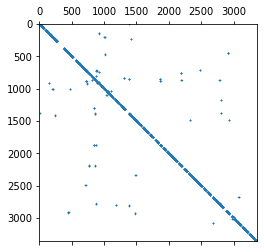

In [166]:
#take submat

print(annotation.iloc[0])
jaccard_connectmat = sparse.COO(jaccard_connectmat)
submat = jaccard_connectmat[annotation.iloc[0].qstart:annotation.iloc[0].qend ,: ]
submat = submat[: , annotation.iloc[0].qstart:annotation.iloc[0].qend  ]


plt.spy(submat.to_scipy_sparse(), markersize =.51)
plt.show()

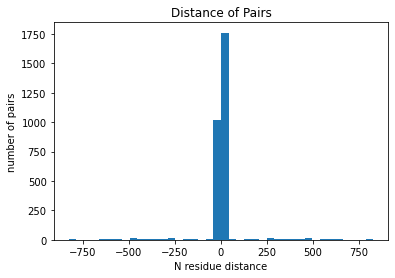

In [167]:
pairs = list(zip(submat.coords[0], submat.coords[1]))

off_diag = [ (p[0]-p[1])/3 for p in pairs ]
plt.hist(off_diag , bins = 40)
plt.title('Distance of Pairs')
plt.xlabel('N residue distance')
plt.ylabel('number of pairs')


plt.show()


In [168]:
pairs = list(zip(submat.coords[0], submat.coords[1]))
pairs = [ (int(p[0]/3), int(p[1]/3)) for p in pairs if np.abs(p[0]-p[1]) > 0]
print(len(pairs))

print(np.array(pairs))

2226
[[   0    1]
 [   0  461]
 [   1    0]
 ...
 [1118 1115]
 [1118 1116]
 [1118 1117]]


In [169]:
subthresh_thresh['7DZW'].keys()

dict_keys(['C', ('A', 'B'), ('A', 'C')])

In [170]:
threshmat = subthresh_thresh['7DZW']['C']+subthresh_thresh['7DZW'][('A', 'C')]+subthresh_thresh['7DZW'][('A', 'B')]
connectmat = subthresh_connected['7DZW']['C'] + subthresh_connected['7DZW'][('A', 'C')] + subthresh_connected['7DZW'][('A', 'B')]


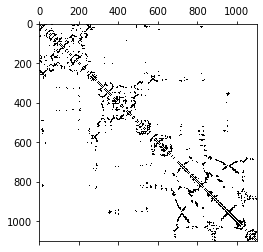

In [171]:
plt.spy(threshmat)
plt.show()

999
[[   0    1]
 [   0    2]
 [   0    3]
 ...
 [1100 1097]
 [1100 1098]
 [1100 1099]]


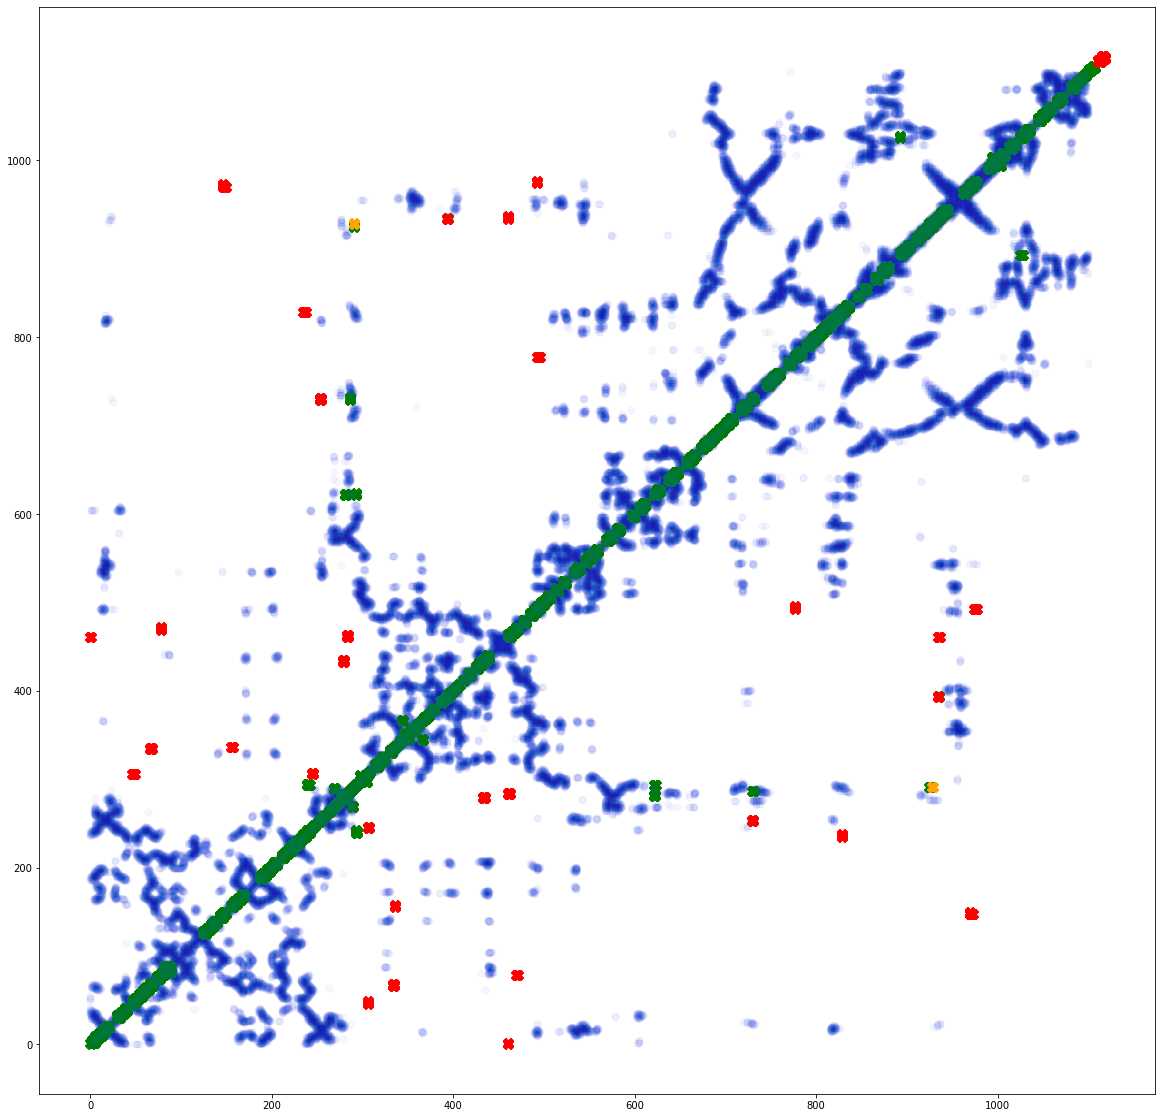

In [172]:
green , orange , red  = struct_hits_filter( pairs , threshmat, connectmat , verbose = False , radius = 10 )

999
[[   0    1]
 [   0    2]
 [   0    3]
 ...
 [1100 1097]
 [1100 1098]
 [1100 1099]]


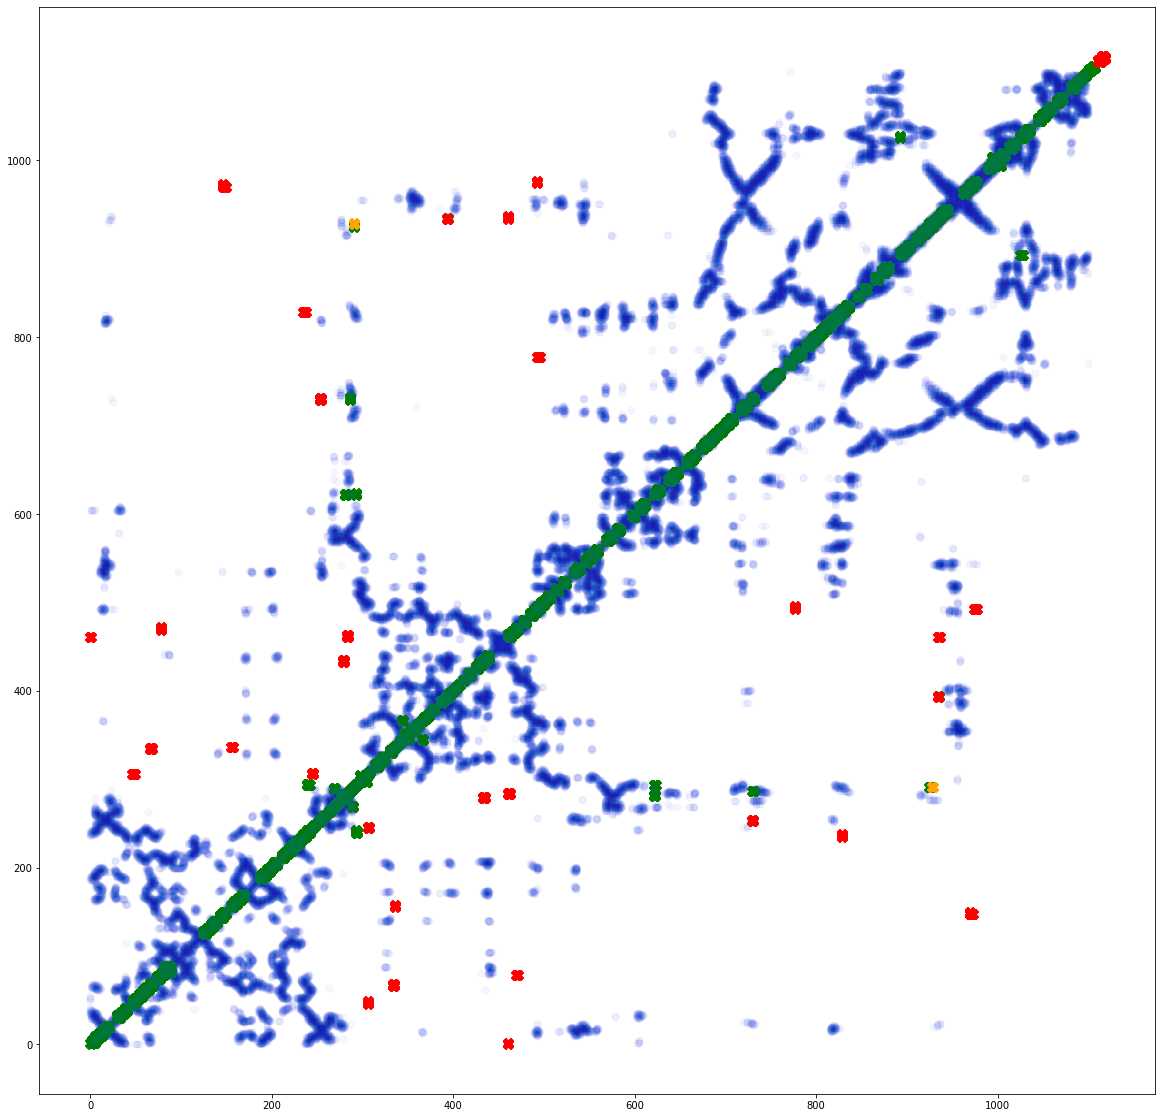

999
[[   0    1]
 [   0    2]
 [   0    3]
 ...
 [1100 1097]
 [1100 1098]
 [1100 1099]]


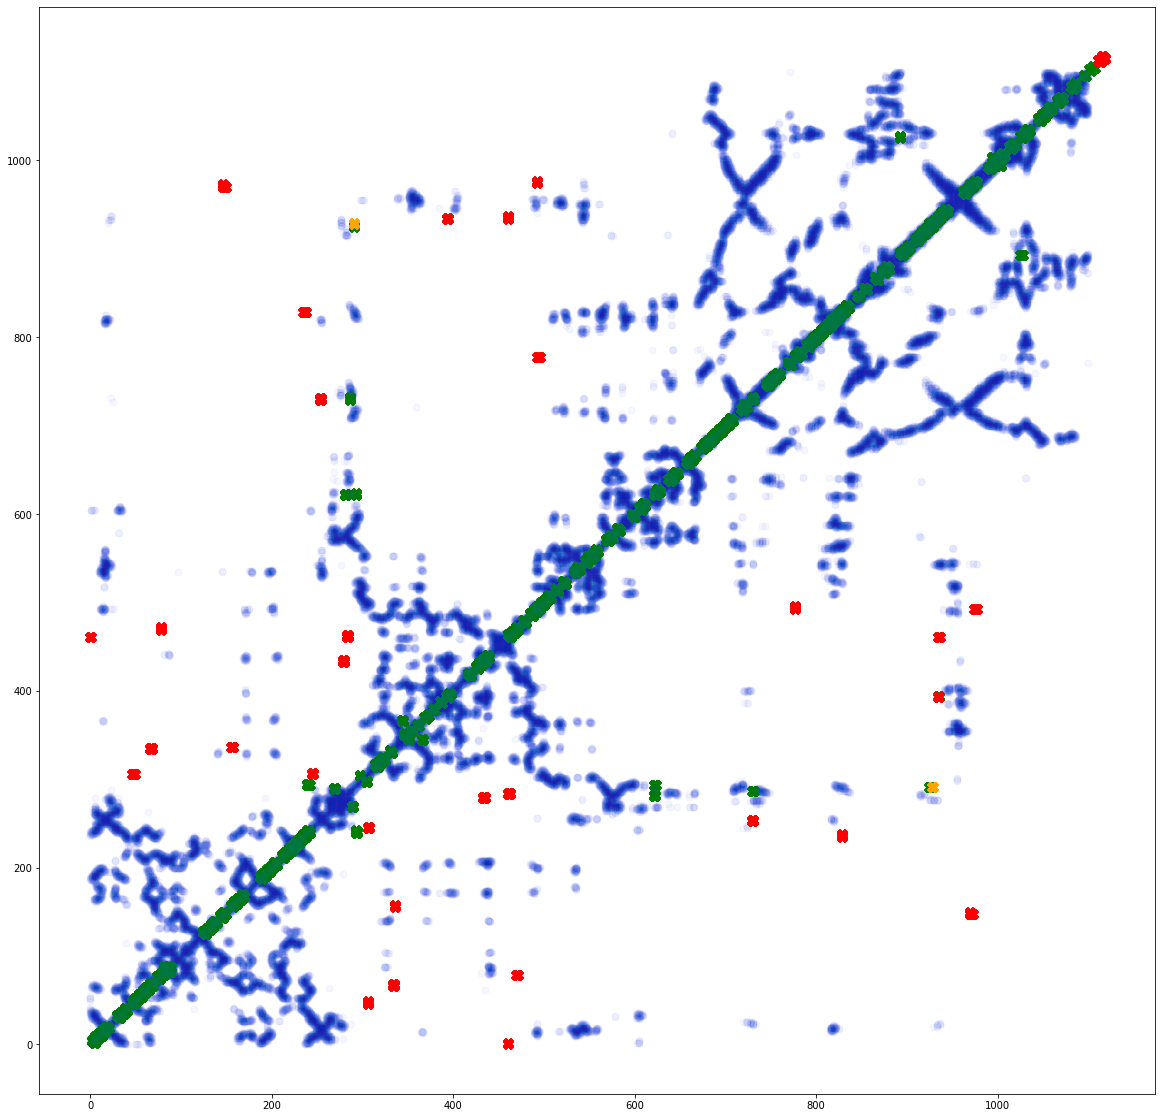

999
[[   0    1]
 [   0    2]
 [   0    3]
 ...
 [1100 1097]
 [1100 1098]
 [1100 1099]]


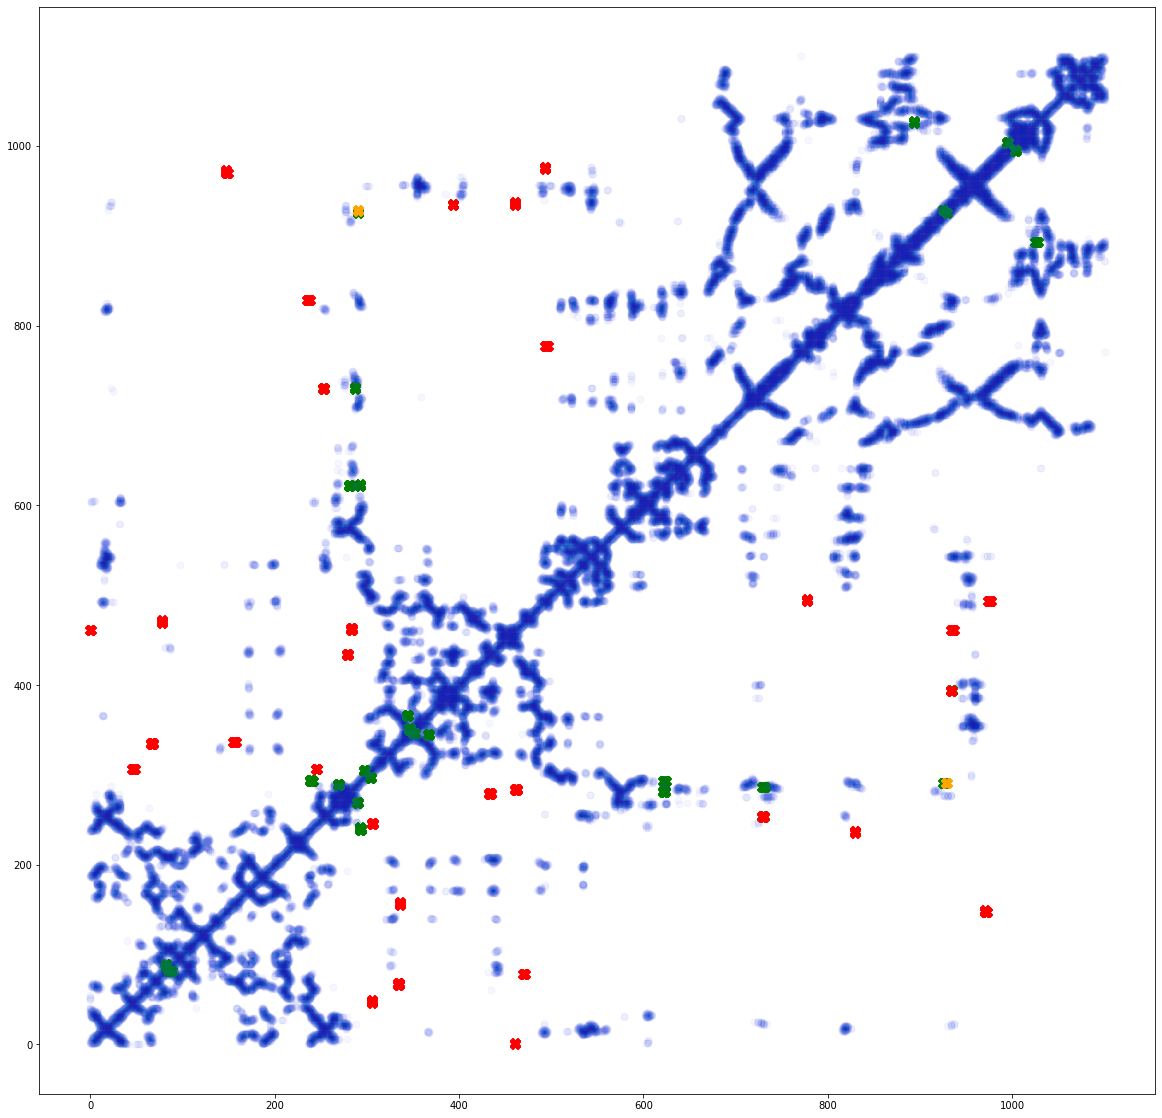

Distance 0
Distance 5
Distance 10


OSError: [Errno 36] File name too long: '[0.03515625, 0.03515625, 0.017578125, 0.017578125, 0.017578125, 0.017578125, 0.107421875, 0.107421875, 0.107421875, 0.107421875, 0.107421875, 0.107421875, 0.021484375, 0.021484375, 0.021484375, 0.021484375, 0.048828125, 0.048828125, 0.048828125, 0.048828125, 0.048828125, 0.048828125, 0.048828125, 0.048828125, 0.0703125, 0.03515625, 0.03515625, 0.03515625, 0.03515625, 0.03515625, 0.03515625, 0.015625, 0.015625, 0.015625, 0.015625, 0.013671875, 0.013671875, 0.013671875, 0.013671875, 0.0859375, 0.04296875, 0.0859375, 0.04296875, 0.0859375, 0.04296875, 0.04296875, 0.109375, 0.109375, 0.109375, 0.109375, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.01171875, 0.16796875, 0.16796875, 0.16796875, 0.16796875, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.033203125, 0.033203125, 0.033203125, 0.033203125, 0.033203125, 0.033203125, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.16796875, 0.16796875, 0.16796875, 0.16796875, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.0859375, 0.0859375, 0.0859375, 0.04296875, 0.0078125, 0.0078125, 0.0078125, 0.0078125, 0.04296875, 0.04296875, 0.04296875, 0.107421875, 0.099609375, 0.107421875, 0.099609375, 0.107421875, 0.107421875, 0.099609375, 0.099609375, 0.017578125, 0.017578125, 0.017578125, 0.017578125, 0.109375, 0.109375, 0.109375, 0.109375, 0.107421875, 0.107421875, 0.107421875, 0.107421875, 0.107421875, 0.107421875, 0.015625, 0.015625, 0.015625, 0.015625, 0.025390625, 0.029296875, 0.025390625, 0.029296875, 0.1015625, 0.1015625, 0.09765625, 0.1015625, 0.09765625, 0.1015625, 0.1015625, 0.1015625, 0.09765625, 0.09765625, 0.025390625, 0.025390625, 0.029296875, 0.029296875, 0.0234375, 0.0234375, 0.021484375, 0.021484375, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.03515625, 0.03515625, 0.033203125, 0.033203125, 0.048828125, 0.048828125, 0.048828125, 0.048828125, 0.033203125, 0.033203125, 0.033203125, 0.033203125, 0.021484375, 0.021484375, 0.021484375, 0.021484375, 0.0703125, 0.099609375, 0.099609375, 0.099609375, 0.099609375, 0.0703125, 0.0703125, 0.0703125, 0.125, 0.125, 0.0078125, 0.125, 0.125, 0.0078125, 0.125, 0.125, 0.0078125, 0.0078125, 0.01171875, 0.01171875, 0.0078125, 0.01171875, 0.01171875, 0.0078125, 0.01171875, 0.01171875, 0.0078125, 0.0078125, 0.0703125, 0.0703125, 0.0703125, 0.0703125, 0.013671875, 0.013671875, 0.013671875, 0.013671875, 0.06640625, 0.06640625, 0.06640625, 0.06640625, 0.0078125, 1.0, 0.0078125, 0.0078125, 0.0078125, 1.0, 0.0234375, 0.021484375, 0.048828125, 0.0234375, 0.021484375, 0.048828125, 0.048828125, 0.048828125, 0.0703125, 0.03515625, 0.03515625, 0.03515625, 0.03515625, 0.03515625, 0.03515625, 0.099609375, 0.099609375, 0.099609375, 0.099609375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.06640625, 0.06640625, 0.06640625, 0.06640625]_ROC.svg'

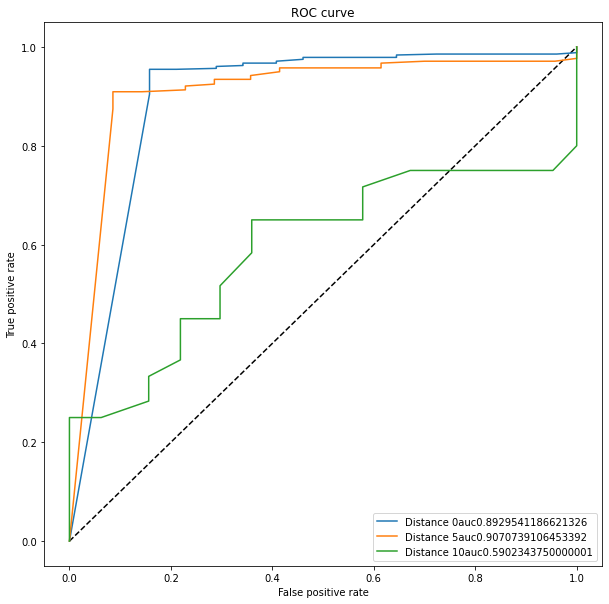

In [177]:
results = {}
threshes = [0,5,10]
for thresh in threshes:
    pairs = list(zip(submat.coords[0], submat.coords[1]))
    pairs = [ (int(p[0]/3), int(p[1]/3)) for p in pairs if np.abs(p[0]-p[1]) > thresh]
    green , orange , red  = struct_hits_filter( pairs , threshmat, connectmat , verbose = False , radius = 10 )
    Trues = list(np.logical_or( green , orange ))
    labels = np.zeros( ( len(Trues) ) ) 
    scores = submat.data
    labels[Trues] = 1
    pairs = list(zip(submat.coords[0], submat.coords[1]))
    data = [ submat.data[i] for i, p in enumerate(pairs) if np.abs(p[0]-p[1]) > thresh]
    
    results['Distance ' + str(thresh)] = {'Ytrue':Trues , 'Ypred':data }
    
    
ROC_curve( results , data)
